##### Copyright 2018 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

&lt;style&gt; td {   text-align: center; }  th {   text-align: center; } &lt;/style&gt;

# ビジュアルアテンションを用いた画像キャプショニング

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/text/image_captioning"> <img src="https://www.tensorflow.org/images/tf_logo_32px.png"> TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/text/image_captioning.ipynb"> <img src="https://www.tensorflow.org/images/colab_logo_32px.png"> Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/text/image_captioning.ipynb"> <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png"> GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/text/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

以下の例のような画像が与えられた場合、目標は「波に乗っているサーファー」などのキャプションを生成することです。

<table style="text-align: center;">
<tr>
  <td><img src="https://tensorflow.org/images/surf.jpg"></td>
</tr>
<tr>
  <th>サーフィンしている男性（出典: <a href="https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg">wikimedia</a>）</th>
</tr>
</table>

ここで使用されているモデルアーキテクチャは、「[Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044)」からアイデアを得たものですが、2 レイヤー Transformer デコーダを使用するように更新されています。このチュートリアルを最大限に活用するには、[テキスト生成](https://www.tensorflow.org/text/tutorials/text_generation)、[seq2seq モデルとアテンション](https://www.tensorflow.org/text/tutorials/nmt_with_attention)、または [transformer](https://www.tensorflow.org/text/tutorials/transformer) の使用経験があるとよいでしょう。

以下は、このチュートリアルに組み込まれるモデルアーキテクチャです。特徴量は画像から抽出され、Transformer デコーダのクロスアテンションレイヤーに渡されています。

<table>
<tr>
  <th>モデルアーキテクチャ</th>
</tr>
<tr>
  <td>    <img width="400" src="https://tensorflow.org/images/tutorials/transformer/ImageCaptioning.png"> </td>
</tr>
</table>

Transformer デコーダは主に、アテンションレイヤーから構築されます。セルフアテンションを使用して、生成されるシーケンスを処理し、クロスアテンションを使用して、画像に注意を向けます。

クロスアテンションレイヤーのアテンションの重みを検査することで、モデルが単語を生成する過程で、モデルが画像のどの部分を見ているかを知ることができます。

![予測](https://tensorflow.org/images/imcap_prediction.png)

このノートブックは、エンドツーエンドの例を示します。このノートブックを実行すると、データセットのダウンロード、画像特徴量の抽出とキャッシュ処理、そしてデコーダモデルのトレーニングが行われます。その後で、モデルを使用して、新しい画像のキャプションが生成されるようになります。

## セットアップ

In [2]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [3]:
!pip uninstall -y tensorflow estimator keras

Found existing installation: tensorflow 2.15.0.post1


Uninstalling tensorflow-2.15.0.post1:


  Successfully uninstalled tensorflow-2.15.0.post1


Found existing installation: keras 2.15.0


Uninstalling keras-2.15.0:
  Successfully uninstalled keras-2.15.0


In [4]:
!pip install -U tensorflow_text tensorflow tensorflow_datasets

  Using cached tensorflow-2.15.0.post1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)


  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)


Using cached tensorflow-2.15.0.post1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)


Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)


In [5]:
!pip install einops

このチュートリアルでは多数の import を使用します。ほとんどがデータセットの読み込み目的です。

In [6]:
#@title
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

2024-01-11 19:14:21.407842: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 19:14:21.407891: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 19:14:21.409458: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## [オプション] データ処理

このセクションでは、captions データセットをダウンロードして、トレーニングの準備を行います。入力テキストをトークン化し、事前トレーニング済みの特徴量抽出器モデルを通じてすべての画像の実行結果をキャッシュします。このセクションの内容を完全に理解することは重要ではありません。

 <section class="expandable tfo-display-only-on-site">
 <button type="button" class="button-red button expand-control">セクションをトグル</button>
</section>


### データセットを選択する

このチュートリアルは、データセットの選択肢を提供するようにセットアップされています。[Flickr8k](https://www.ijcai.org/Proceedings/15/Papers/593.pdf)、または [Conceptual Captions](https://ai.google.com/research/ConceptualCaptions/) データセットの小さなスライスのいずれかを選択します。これらはゼロからダウンロードして変換されますが、[TensorFlow Datasets](https://www.tensorflow.org/datasets) で提供されている [Coco Captions](https://www.tensorflow.org/datasets/catalog/coco_captions) と完全な [Conceptual Captions](https://www.tensorflow.org/datasets/community_catalog/huggingface/conceptual_captions) というキャプションデータセットを使用するようにチュートリアルを変更することは困難ではありません。


#### Flickr8k

In [7]:
def flickr8k(path='flickr8k'):
  path = pathlib.Path(path)

  if len(list(path.rglob('*'))) < 16197:
    tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=True)
    tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=True)
    
  captions = (path/"Flickr8k.token.txt").read_text().splitlines()
  captions = (line.split('\t') for line in captions)
  captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)

  cap_dict = collections.defaultdict(list)
  for fname, cap in captions:
    cap_dict[fname].append(cap)

  train_files = (path/'Flickr_8k.trainImages.txt').read_text().splitlines()
  train_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in train_files]

  test_files = (path/'Flickr_8k.testImages.txt').read_text().splitlines()
  test_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in test_files]

  train_ds = tf.data.experimental.from_list(train_captions)
  test_ds = tf.data.experimental.from_list(test_captions)

  return train_ds, test_ds

#### Conceptual Captions

In [8]:
def conceptual_captions(*, data_dir="conceptual_captions", num_train, num_val):
  def iter_index(index_path):
    with open(index_path) as f:
      for line in f:
        caption, url = line.strip().split('\t')
        yield caption, url

  def download_image_urls(data_dir, urls):
    ex = concurrent.futures.ThreadPoolExecutor(max_workers=100)
    def save_image(url):
      hash = hashlib.sha1(url.encode())
      # Name the files after the hash of the URL.
      file_path = data_dir/f'{hash.hexdigest()}.jpeg'
      if file_path.exists():
        # Only download each file once.
        return file_path

      try:
        result = requests.get(url, timeout=5)
      except Exception:
        file_path = None
      else:
        file_path.write_bytes(result.content)
      return file_path
    
    result = []
    out_paths = ex.map(save_image, urls)
    for file_path in tqdm.tqdm(out_paths, total=len(urls)):
      result.append(file_path)

    return result

  def ds_from_index_file(index_path, data_dir, count):
    data_dir.mkdir(exist_ok=True)
    index = list(itertools.islice(iter_index(index_path), count))
    captions = [caption for caption, url in index]
    urls = [url for caption, url in index]

    paths = download_image_urls(data_dir, urls)

    new_captions = []
    new_paths = []
    for cap, path in zip(captions, paths):
      if path is None:
        # Download failed, so skip this pair.
        continue
      new_captions.append(cap)
      new_paths.append(path)
    
    new_paths = [str(p) for p in new_paths]

    ds = tf.data.Dataset.from_tensor_slices((new_paths, new_captions))
    ds = ds.map(lambda path,cap: (path, cap[tf.newaxis])) # 1 caption per image
    return ds

  data_dir = pathlib.Path(data_dir)
  train_index_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/gcc-data/Train/GCC-training.tsv',
    cache_subdir=data_dir,
    cache_dir='.')
  
  val_index_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/gcc-data/Validation/GCC-1.1.0-Validation.tsv',
    cache_subdir=data_dir,
    cache_dir='.')
  
  train_raw = ds_from_index_file(train_index_path, data_dir=data_dir/'train', count=num_train)
  test_raw = ds_from_index_file(val_index_path, data_dir=data_dir/'val', count=num_val)

  return train_raw, test_raw

#### データセットをダウンロードする

Flickr8k には 1 つの画像につき 5 つのキャプションが含まれているため、より小さなダウンロードサイズでより多くのデータを得られる良い選択肢と言えます。

In [9]:
choose = 'flickr8k'

if choose == 'flickr8k':
  train_raw, test_raw = flickr8k()
else:
  train_raw, test_raw = conceptual_captions(num_train=10000, num_val=5000)

      8192/1115419746 [..............................] - ETA: 0s

   1081344/1115419746 [..............................] - ETA: 52s

  11649024/1115419746 [..............................] - ETA: 9s 

  23724032/1115419746 [..............................] - ETA: 6s

  36372480/1115419746 [..............................] - ETA: 5s

  49192960/1115419746 [>.............................] - ETA: 5s

  62660608/1115419746 [>.............................] - ETA: 5s

  75972608/1115419746 [=>............................] - ETA: 4s

  89522176/1115419746 [=>............................] - ETA: 4s

 102498304/1115419746 [=>............................] - ETA: 4s

 116219904/1115419746 [==>...........................] - ETA: 4s

 129646592/1115419746 [==>...........................] - ETA: 4s

 143450112/1115419746 [==>...........................] - ETA: 4s

 156254208/1115419746 [===>..........................] - ETA: 3s

 168476672/1115419746 [===>..........................] - ETA: 3s

 181141504/1115419746 [===>..........................] - ETA: 3s

 194297856/1115419746 [====>.........................] - ETA: 3s

 207429632/1115419746 [====>.........................] - ETA: 3s

 219807744/1115419746 [====>.........................] - ETA: 3s

 232308736/1115419746 [=====>........................] - ETA: 3s

 244506624/1115419746 [=====>........................] - ETA: 3s

 257114112/1115419746 [=====>........................] - ETA: 3s

 269828096/1115419746 [======>.......................] - ETA: 3s

 283090944/1115419746 [======>.......................] - ETA: 3s

 295895040/1115419746 [======>.......................] - ETA: 3s

 309248000/1115419746 [=======>......................] - ETA: 3s

 322191360/1115419746 [=======>......................] - ETA: 3s

 335716352/1115419746 [========>.....................] - ETA: 3s

 349085696/1115419746 [========>.....................] - ETA: 3s

 362217472/1115419746 [========>.....................] - ETA: 3s

 375144448/1115419746 [=========>....................] - ETA: 2s

 388022272/1115419746 [=========>....................] - ETA: 2s

 401129472/1115419746 [=========>....................] - ETA: 2s

 414269440/1115419746 [==========>...................] - ETA: 2s

 427769856/1115419746 [==========>...................] - ETA: 2s

 440844288/1115419746 [==========>...................] - ETA: 2s

 453705728/1115419746 [===========>..................] - ETA: 2s

 467255296/1115419746 [===========>..................] - ETA: 2s

 480337920/1115419746 [===========>..................] - ETA: 2s

 493010944/1115419746 [============>.................] - ETA: 2s

 506396672/1115419746 [============>.................] - ETA: 2s

 520642560/1115419746 [=============>................] - ETA: 2s

 534233088/1115419746 [=============>................] - ETA: 2s

 548454400/1115419746 [=============>................] - ETA: 2s

 562053120/1115419746 [==============>...............] - ETA: 2s

 575709184/1115419746 [==============>...............] - ETA: 2s

 589406208/1115419746 [==============>...............] - ETA: 2s

 602324992/1115419746 [===============>..............] - ETA: 2s

 614965248/1115419746 [===============>..............] - ETA: 1s

 628572160/1115419746 [===============>..............] - ETA: 1s

 641990656/1115419746 [================>.............] - ETA: 1s

 655409152/1115419746 [================>.............] - ETA: 1s

 669351936/1115419746 [=================>............] - ETA: 1s

 683180032/1115419746 [=================>............] - ETA: 1s

 696352768/1115419746 [=================>............] - ETA: 1s

 709148672/1115419746 [==================>...........] - ETA: 1s

 722739200/1115419746 [==================>...........] - ETA: 1s

 735674368/1115419746 [==================>...........] - ETA: 1s

 749133824/1115419746 [===================>..........] - ETA: 1s

 762626048/1115419746 [===================>..........] - ETA: 1s

 776347648/1115419746 [===================>..........] - ETA: 1s

 789282816/1115419746 [====================>.........] - ETA: 1s

 802390016/1115419746 [====================>.........] - ETA: 1s

 815775744/1115419746 [====================>.........] - ETA: 1s

 829095936/1115419746 [=====================>........] - ETA: 1s

 842072064/1115419746 [=====================>........] - ETA: 1s

 855212032/1115419746 [======================>.......] - ETA: 1s

 868474880/1115419746 [======================>.......] - ETA: 0s

 882933760/1115419746 [======================>.......] - ETA: 0s

 897286144/1115419746 [=======================>......] - ETA: 0s

 911540224/1115419746 [=======================>......] - ETA: 0s

 924639232/1115419746 [=======================>......] - ETA: 0s

 938360832/1115419746 [========================>.....] - ETA: 0s

 952377344/1115419746 [========================>.....] - ETA: 0s

 966631424/1115419746 [========================>.....] - ETA: 0s

 980484096/1115419746 [=========================>....] - ETA: 0s

 994115584/1115419746 [=========================>....] - ETA: 0s

1007730688/1115419746 [==========================>...] - ETA: 0s

1022435328/1115419746 [==========================>...] - ETA: 0s

1036910592/1115419746 [==========================>...] - ETA: 0s

1051164672/1115419746 [===========================>..] - ETA: 0s

1065402368/1115419746 [===========================>..] - ETA: 0s

1080156160/1115419746 [============================>.] - ETA: 0s

1094680576/1115419746 [============================>.] - ETA: 0s

1109245952/1115419746 [============================>.] - ETA: 0s

1115419746/1115419746 [==============================] - 4s 0us/step


   8192/2340801 [..............................] - ETA: 0s

1032192/2340801 [============>.................] - ETA: 0s

2340801/2340801 [==============================] - 0s 0us/step


上記のいずれのデータセットのローダーも、`(image_path, captions)` ペアを含む `tf.data.Dataset` を返します。Flickr8k データセットには 1 つの画像につき 5 つのキャプションが含まれているのに対し、Conceptual Captions のキャプションは 1 つです。

In [10]:
train_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.string, name=None))

In [11]:
for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'flickr8k/Flicker8k_Dataset/2513260012_03d33305cf.jpg', shape=(), dtype=string)
tf.Tensor(
[b'A black dog is running after a white dog in the snow .'
 b'Black dog chasing brown dog through snow'
 b'Two dogs chase each other across the snowy ground .'
 b'Two dogs play together in the snow .'
 b'Two dogs running through a low lying body of water .'], shape=(5,), dtype=string)


### 画像特徴量抽出器

画像モデル（imagenet で事前トレーニング済み）を使用して各画像から特徴量を抽出します。このモデルは画像分類器としてトレーニングされていますが、設定 `include_top=False` は最終的な分類レイヤーなしのモデルを返すため、特徴量マップの最後のレイヤーを使用できます。


In [12]:
IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
mobilenet.trainable=False

   8192/4334752 [..............................] - ETA: 0s

4334752/4334752 [==============================] - 0s 0us/step


以下は、画像を読み込んでモデルに合わせてサイズを変更する関数です。

In [13]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

モデルは、入力バッチで各画像の特徴量マップを返します。

In [14]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(mobilenet(test_img_batch).shape)

(1, 224, 224, 3)


(1, 7, 7, 576)


### テキストトークナイザ/ベクタナイザをセットアップする

次の手順で、[TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) レイヤーを使用して、テキストキャプションを整数シーケンスに変換します。

- [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) を使用して、すべてのキャプションをイテレートし、キャプションを単語に分割して、上位の単語の語彙を計算します。
- 各単語を語彙のインデックスにマッピングして、すべてのキャプションをトークン化します。すべての出力シーケンスは、長さ 50 までパディングされます。
- 結果を表示するために、単語からインデックスおよびインデックスから単語へのマッピングを作成します。

In [15]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [16]:
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.

In [17]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

In [18]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'is', 'and']

In [19]:
t = tokenizer([['a cat in a hat'], ['a robot dog']])
t

<tf.RaggedTensor [[3, 2, 655, 5, 2, 97, 4], [3, 2, 1937, 10, 4]]>

In [20]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [21]:
w = index_to_word(t)
w.to_list()

[[b'[START]', b'a', b'cat', b'in', b'a', b'hat', b'[END]'],
 [b'[START]', b'a', b'robot', b'dog', b'[END]']]

In [22]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] a cat in a hat [END]', b'[START] a robot dog [END]'],
      dtype=object)

### データセットを準備する

`train_raw` と `test_raw` データセットには、一対多の `(image, captions)` ペアが含まれます。

この関数は、画像とキャプションが 1:1 になるように、画像を複製します。

In [23]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [24]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)


image paths: (32,)
captions: (32, 5)

image_paths: (160,)
captions: (160,)


Keras トレーニングと互換性を持たせるため、データセットには `(inputs, labels)` ペアを含める必要があります。テキスト生成では、トークンは、入力とラベルのいずれでもあり、1 ステップずつシフトされます。この関数は、`(images, texts)` ペアを `((images, input_tokens), label_tokens)` ペアに変換します。

In [25]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

この関数は、以下の手順でデータセットに演算を追加します。

1. 画像を読み込みます（読み込みに失敗する画像は無視されます）。
2. キャプションの数に合わせて画像を複製します。
3. `image, caption` ペアをシャッフルして再バッチ化します。
4. テキストをトークン化し、トークンをシフトして `label_tokens` を追加します。
5. `RaggedTensor` 表現のテキストをパディング付きの高密度 `Tensor` 表現に変換します。

In [26]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

以下のようにして、特徴量抽出器をモデルにインストールし、データセットでトレーニングすることが可能です。

In [27]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [28]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

### [オプション] 画像特徴量をキャッシュする

画像特徴量抽出器には変化がなく、このチュートリアルでは画像拡張を使用していないため、画像特徴量をキャッシュすることができます。テキストトークン化についても同様です。キャッシュをセットアップするのに時間がかかりますが、その時間は、トレーニングと検証中に、各エポックで取り返すことができます。以下のコードでは、`save_dataset` と `load_dataset` の 2 つの関数を定義しています。 

In [29]:
def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=32):
  # Load the images and make batches.
  ds = (ds
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  # Run the feature extractor on each batch
  # Don't do this in a .map, because tf.data runs on the CPU. 
  def gen():
    for (images, captions) in tqdm.tqdm(ds): 
      feature_maps = image_model(images)

      feature_maps, captions = match_shapes(feature_maps, captions)
      yield feature_maps, captions

  # Wrap the generator in a new tf.data.Dataset.
  new_ds = tf.data.Dataset.from_generator(
      gen,
      output_signature=(
          tf.TensorSpec(shape=image_model.output_shape),
          tf.TensorSpec(shape=(None,), dtype=tf.string)))

  # Apply the tokenization 
  new_ds = (new_ds
            .map(prepare_txt, tf.data.AUTOTUNE)
            .unbatch()
            .shuffle(1000))

  # Save the dataset into shard files.
  def shard_func(i, item):
    return i % shards
  new_ds.enumerate().save(save_path, shard_func=shard_func)

def load_dataset(save_path, batch_size=32, shuffle=1000, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(1000)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)
  
  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
  return ds

In [30]:
save_dataset(train_raw, 'train_cache', mobilenet, tokenizer)
save_dataset(test_raw, 'test_cache', mobilenet, tokenizer)

0it [00:00, ?it/s]

1it [00:01,  1.45s/it]

2it [00:01,  1.49it/s]

3it [00:01,  2.35it/s]

4it [00:01,  3.25it/s]

5it [00:01,  4.18it/s]

6it [00:02,  5.07it/s]

7it [00:02,  5.88it/s]

8it [00:02,  6.42it/s]

9it [00:02,  6.81it/s]

10it [00:02,  7.31it/s]

11it [00:02,  7.66it/s]

12it [00:02,  7.94it/s]

13it [00:02,  8.16it/s]

14it [00:03,  8.05it/s]

15it [00:03,  7.94it/s]

16it [00:03,  8.16it/s]

17it [00:03,  8.05it/s]

18it [00:03,  8.26it/s]

19it [00:03,  8.42it/s]

20it [00:03,  8.16it/s]

21it [00:03,  8.30it/s]

22it [00:03,  8.38it/s]

23it [00:04,  8.40it/s]

24it [00:04,  8.24it/s]

25it [00:04,  8.40it/s]

26it [00:04,  8.47it/s]

27it [00:04,  8.50it/s]

28it [00:04,  8.53it/s]

29it [00:04,  8.58it/s]

30it [00:04,  8.35it/s]

31it [00:05,  8.38it/s]

32it [00:05,  8.44it/s]

33it [00:05,  8.42it/s]

34it [00:05,  8.54it/s]

35it [00:05,  8.61it/s]

36it [00:05,  8.68it/s]

37it [00:05,  8.70it/s]

38it [00:05,  8.73it/s]

39it [00:05,  8.62it/s]

40it [00:06,  8.66it/s]

41it [00:06,  8.69it/s]

42it [00:06,  8.64it/s]

43it [00:06,  8.65it/s]

44it [00:06,  8.43it/s]

45it [00:06,  8.41it/s]

46it [00:06,  8.43it/s]

47it [00:06,  8.46it/s]

48it [00:07,  8.49it/s]

49it [00:07,  8.49it/s]

50it [00:07,  8.55it/s]

51it [00:07,  8.58it/s]

52it [00:07,  8.62it/s]

53it [00:07,  8.62it/s]

54it [00:07,  8.63it/s]

55it [00:07,  8.63it/s]

56it [00:07,  8.55it/s]

57it [00:08,  8.51it/s]

58it [00:08,  8.20it/s]

59it [00:08,  8.30it/s]

60it [00:08,  8.36it/s]

61it [00:08,  8.39it/s]

62it [00:08,  8.39it/s]

63it [00:08,  8.48it/s]

64it [00:08,  8.46it/s]

65it [00:09,  8.50it/s]

66it [00:09,  8.50it/s]

67it [00:09,  8.49it/s]

68it [00:09,  8.47it/s]

69it [00:09,  8.54it/s]

70it [00:09,  8.39it/s]

71it [00:09,  8.45it/s]

72it [00:09,  8.46it/s]

73it [00:09,  8.39it/s]

74it [00:10,  8.38it/s]

75it [00:10,  8.27it/s]

76it [00:10,  8.34it/s]

77it [00:10,  8.37it/s]

78it [00:10,  8.36it/s]

79it [00:10,  8.34it/s]

80it [00:10,  8.44it/s]

81it [00:10,  8.48it/s]

82it [00:11,  8.53it/s]

83it [00:11,  8.55it/s]

84it [00:11,  8.62it/s]

85it [00:11,  8.56it/s]

86it [00:11,  8.61it/s]

87it [00:11,  8.65it/s]

88it [00:11,  8.62it/s]

89it [00:11,  8.62it/s]

90it [00:11,  8.64it/s]

91it [00:12,  8.67it/s]

92it [00:12,  8.66it/s]

93it [00:12,  8.67it/s]

94it [00:12,  8.71it/s]

95it [00:12,  8.65it/s]

96it [00:12,  8.62it/s]

97it [00:12,  8.60it/s]

98it [00:12,  8.63it/s]

99it [00:13,  8.63it/s]

100it [00:13,  8.61it/s]

101it [00:13,  8.60it/s]

102it [00:13,  8.63it/s]

103it [00:13,  8.65it/s]

104it [00:13,  8.68it/s]

105it [00:13,  8.70it/s]

106it [00:13,  8.71it/s]

107it [00:13,  8.68it/s]

108it [00:14,  8.67it/s]

109it [00:14,  8.70it/s]

110it [00:14,  8.70it/s]

111it [00:14,  8.68it/s]

112it [00:14,  8.65it/s]

113it [00:14,  8.66it/s]

114it [00:14,  8.63it/s]

115it [00:14,  8.59it/s]

116it [00:14,  8.54it/s]

117it [00:15,  8.53it/s]

118it [00:15,  8.57it/s]

119it [00:15,  8.62it/s]

120it [00:15,  8.55it/s]

121it [00:15,  8.57it/s]

122it [00:15,  8.58it/s]

123it [00:15,  8.63it/s]

124it [00:15,  8.64it/s]

125it [00:16,  8.67it/s]

126it [00:16,  8.68it/s]

127it [00:16,  8.72it/s]

128it [00:16,  8.65it/s]

129it [00:16,  8.60it/s]

130it [00:16,  8.57it/s]

131it [00:16,  8.57it/s]

132it [00:16,  8.62it/s]

133it [00:16,  8.60it/s]

134it [00:17,  8.66it/s]

135it [00:17,  8.66it/s]

136it [00:17,  8.65it/s]

137it [00:17,  8.56it/s]

138it [00:17,  8.47it/s]

139it [00:17,  8.49it/s]

140it [00:17,  8.31it/s]

141it [00:17,  8.34it/s]

142it [00:18,  8.30it/s]

143it [00:18,  8.34it/s]

144it [00:18,  8.42it/s]

145it [00:18,  8.48it/s]

146it [00:18,  8.52it/s]

147it [00:18,  8.59it/s]

148it [00:18,  8.57it/s]

149it [00:18,  8.58it/s]

150it [00:18,  8.62it/s]

151it [00:19,  8.60it/s]

152it [00:19,  8.59it/s]

153it [00:19,  8.61it/s]

154it [00:19,  8.61it/s]

155it [00:19,  8.67it/s]

156it [00:19,  8.70it/s]

157it [00:19,  8.71it/s]

158it [00:19,  8.68it/s]

159it [00:20,  8.65it/s]

160it [00:20,  8.61it/s]

161it [00:20,  8.64it/s]

162it [00:20,  8.69it/s]

163it [00:20,  8.76it/s]

164it [00:20,  8.72it/s]

165it [00:20,  8.70it/s]

166it [00:20,  8.63it/s]

167it [00:20,  8.53it/s]

168it [00:21,  8.63it/s]

169it [00:21,  8.68it/s]

170it [00:21,  8.72it/s]

171it [00:21,  8.71it/s]

172it [00:21,  8.70it/s]

173it [00:21,  8.67it/s]

174it [00:21,  8.65it/s]

175it [00:21,  8.69it/s]

176it [00:21,  8.67it/s]

177it [00:22,  8.68it/s]

178it [00:22,  8.63it/s]

179it [00:22,  8.65it/s]

180it [00:22,  8.57it/s]

181it [00:22,  8.56it/s]

182it [00:22,  8.59it/s]

183it [00:22,  8.64it/s]

184it [00:22,  8.29it/s]

185it [00:23,  8.41it/s]

186it [00:23,  8.47it/s]

187it [00:23,  8.61it/s]

188it [00:23,  7.22it/s]

188it [00:23,  8.02it/s]

0it [00:00, ?it/s]

1it [00:00,  3.38it/s]

2it [00:00,  5.31it/s]

3it [00:00,  6.51it/s]

4it [00:00,  6.99it/s]

5it [00:00,  7.47it/s]

6it [00:00,  7.83it/s]

7it [00:01,  7.82it/s]

8it [00:01,  7.86it/s]

9it [00:01,  8.12it/s]

10it [00:01,  8.22it/s]

11it [00:01,  8.38it/s]

12it [00:01,  8.23it/s]

13it [00:01,  8.06it/s]

14it [00:01,  8.19it/s]

15it [00:01,  8.31it/s]

16it [00:02,  8.41it/s]

17it [00:02,  8.45it/s]

18it [00:02,  8.50it/s]

19it [00:02,  8.28it/s]

20it [00:02,  8.40it/s]

21it [00:02,  8.42it/s]

22it [00:02,  8.48it/s]

23it [00:02,  8.48it/s]

24it [00:03,  8.49it/s]

25it [00:03,  8.50it/s]

26it [00:03,  8.50it/s]

27it [00:03,  8.46it/s]

28it [00:03,  8.51it/s]

29it [00:03,  8.54it/s]

30it [00:03,  8.58it/s]

31it [00:03,  8.68it/s]

32it [00:04,  7.52it/s]

32it [00:04,  7.95it/s]

 </section>


## トレーニングの準備が完了したデータ

前処理手順が完了したら、データセットは以下のようになります。

In [31]:
train_ds = load_dataset('train_cache')
test_ds = load_dataset('test_cache')

In [32]:
train_ds.element_spec

((TensorSpec(shape=(None, 7, 7, 576), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

このデータセットは、Keras でのトレーニングに適した `(input, label)` ペアを返すようになりました。`inputs` は `(images, input_tokens)` ペアです。`images` は特徴量抽出器モデルで処理が完了しています。`input_tokens` の各場所では、モデルはそれまでのテキストを見て、`labels` 内の同じ位置に並んでいる次のテキストを予測しようとします。

In [33]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

(32, 7, 7, 576)
(32, 18)
(32, 18)


入力トークンとラベルは、1 ステップずつシフトしているだけで、同じです。

In [34]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[   3   29 1708  648   13   24  620    5    2 2857    0    0    0    0
    0    0    0    0]
[  29 1708  648   13   24  620    5    2 2857    4    0    0    0    0
    0    0    0    0]


## Transformer デコーダモデル

このモデルは、事前トレーニング済みの画像エンコーダが十分であることを前提としているため、テキストエンコーダの構築のみに焦点を当てています。このチュートリアルでは 2 レイヤーの Transformer デコーダを使用します。

実装は、[Transformers チュートリアル](https://www.tensorflow.org/text/tutorials/transformer)とほぼ同一です。詳細は、そちらをご覧ください。

<table>
<tr>
  <th>Transformer エンコーダとデコーダ</th>
</tr>
<tr>
  <td>    <img width="400" src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"> </td>
</tr>
</table>

モデルは、主に以下の 3 つのパーツで実装されます。

1. 入力 - トークン埋め込みと位置エンコーディング（`SeqEmbedding`）。
2. デコーダ - Transformer デコーダレイヤーのスタック（`DecoderLayer`）で、それぞれに以下が含まれます。
    1. カジュアルなセルフアテンションレイヤー（`CausalSelfAttention`）。出力の各場所はそれまでの出力に注目します。
    2. クロスアテンションレイヤー（`CrossAttention`）。出力の各場所は入力画像に注目します。
    3. フィードフォワードネットワーク（`FeedForward`）レイヤー。各出力場所をさらに個別に処理します。
3. 出力 - 出力語彙に対するマルチクラス分類。


### 入力

入力テキストはすでにトークンに分割され、ID のシーケンスに変換されています。

CNN や RNN とは異なり、Transformer のアテンションレイヤーは、シーケンスの順序に対して不変であることを思い出しましょう。なんらかの位置入力がないと、シーケンスではなく順序付けられていないセットが表示されます。そのため、Embedding レイヤーには、各トークンの単純なベクトル埋め込みの他に、シーケンスの各位置の埋め込みも含められます。

`SeqEmbedding` レイヤーは以下のように定義されています。

- 各トークンの埋め込みベクトルをルックアップします。
- 各シーケンス位置の埋め込みベクトルをルックアップします。
- その両方を追加します。
- `mask_zero=True` を使用して、モデルの keras-masks を初期化します。

注意: この実装は、[Transformer チュートリアル](https://www.tensorflow.org/text/tutorials/transformer)のように固定埋め込みを使用する代わりに、位置埋め込みを学習します。埋め込みの学習ではコードがわずかに少なくなりますが、より長いシーケンスには一般化されません。

In [35]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)
    
    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

### デコーダ

デコーダは標準的な Transformer デコーダで、それぞれに `CausalSelfAttention`、`CrossAttention`、および `FeedForward`-decoder の 3 つのサブレイヤーを含む `DecoderLayers` のスタックが含まれます。実装は [Transformer チュートリアル](https://www.tensorflow.org/text/tutorials/transformer)とほぼ同一であるため、詳細はそちらをご覧ください。

以下は、`CausalSelfAttention` レイヤーです。

In [36]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)


以下は、`CrossAttention` レイヤーです。`return_attention_scores` の使用に注意してください。

In [37]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)
    
    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

以下は、`FeedForward` レイヤーです。`layers.Dense` レイヤーは入力の最後の軸に適用されることを思い出しましょう。入力は `(batch, sequence, channels)` の形状になるため、`batch` と `sequence` 軸にポイントワイズが自動的に適用されます。 

In [38]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)


次に、これらの 3 つのレイヤーをより大きな `DecoderLayer` に配置します。各デコーダレイヤーは、3 つの小さなレイヤーをシーケンスで適用します。各サブレイヤーの後、`out_seq` の形状は `(batch, sequence, channels)` になります。デコーダレイヤーは、後で可視化できる `attention_scores` も返します。

In [39]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()
    
    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
      

  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)
    
    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

### 出力

最低でも、出力レイヤーには、各位置で各トークンのロジット予測を生成するための `layers.Dense` レイヤーが必要です。

しかし、この動作を少しでも改良するために追加できる他の特徴量は少ししかありません。

1. **不正なトークンを処理する**: モデルはテキストを生成します。パディング、不明、または開始トークン（`''`、`'[UNK]'`、`'[START]'`）を絶対に生成してはいけません。したがって、これらのバイアスは大きな負の値に設定します。

    > 注意: これらのトークンは、損失関数ででも無視する必要があります。

2. **スマート初期化**: 高密度レイヤーのデフォルトの初期化では、最初にほぼ一様の尤度で各トークンを予測するモデルが得られます。実際のトークン分布は一様からはほど遠いものです。出力レイヤーの初期バイアスの最適な値は、各トークンの確率の対数です。したがって、`adapt` メソッドを含めてトークンをカウントし、最適な初期バイアスを設定します。こうすることで、初期損失が一様分布のエントロピー（`log(vocabulary_size)`）から分布の限界エントロピー（`-p*log(p)`）に減少します。


In [40]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()
    
    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias


スマート初期化によって、初期損失をが大幅に減少します。

In [41]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<03:22,  4.64it/s]

  4%|▎         | 34/938 [00:00<00:06, 134.21it/s]

  8%|▊         | 71/938 [00:00<00:03, 218.79it/s]

 12%|█▏        | 109/938 [00:00<00:03, 271.24it/s]

 16%|█▌        | 147/938 [00:00<00:02, 305.37it/s]

 20%|█▉        | 187/938 [00:00<00:02, 332.79it/s]

 24%|██▍       | 225/938 [00:00<00:02, 346.57it/s]

 28%|██▊       | 262/938 [00:00<00:01, 353.39it/s]

 32%|███▏      | 300/938 [00:01<00:01, 360.77it/s]

 36%|███▌      | 338/938 [00:01<00:01, 365.18it/s]

 40%|████      | 376/938 [00:01<00:01, 363.45it/s]

 44%|████▍     | 414/938 [00:01<00:01, 366.37it/s]

 48%|████▊     | 453/938 [00:01<00:01, 371.14it/s]

 52%|█████▏    | 492/938 [00:01<00:01, 374.93it/s]

 57%|█████▋    | 531/938 [00:01<00:01, 376.74it/s]

 61%|██████    | 570/938 [00:01<00:00, 378.59it/s]

 65%|██████▍   | 608/938 [00:01<00:00, 378.12it/s]

 69%|██████▉   | 646/938 [00:01<00:00, 376.87it/s]

 73%|███████▎  | 684/938 [00:02<00:00, 373.96it/s]

 77%|███████▋  | 722/938 [00:02<00:00, 374.18it/s]

 81%|████████  | 760/938 [00:02<00:00, 372.58it/s]

 85%|████████▌ | 798/938 [00:02<00:00, 373.06it/s]

 89%|████████▉ | 836/938 [00:02<00:00, 371.76it/s]

 93%|█████████▎| 874/938 [00:02<00:00, 370.08it/s]

 99%|█████████▊| 924/938 [00:02<00:00, 408.22it/s]

100%|██████████| 938/938 [00:02<00:00, 351.19it/s]


Uniform entropy: 8.52
Marginal entropy: 5.29


### モデルを構築する

モデルを構築するには、複数のパーツを組み合わせる必要があります。

1. 画像 `feature_extractor` とテキスト `tokenizer`。
2. `seq_embedding` レイヤー。トークン ID のバッチをベクトル `(batch, sequence, channels)` に変換します。
3. テキストと画像データを処理する `DecoderLayers` レイヤーのスタック。
4. `output_layer`。次の単語のポイントワイズの予測を返します。

In [42]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

トレーニングにモデルを呼び出すと、`image, txt` ペアが返されます。この関数をさらに使いやすくするために、入力について柔軟になりましょう。

- 画像に 3 つのチャンネルがある場合、feature_extractor に通します。そうでない場合は、すでに通過済みであることを前提とします。
- テキストに dtype `tf.string` がある場合、tokenizer に通します。

その後のモデルの実行はほんの数ステップです。

1. 抽出された画像特徴量をフラット化し、デコーダレイヤーに入力できるようにします。
2. トークン埋め込みをルックアップします。
3. 画像特徴量とテキスト埋め込みで `DecoderLayer` を実行します。
4. 出力レイヤーを実行して、各位置の次のトークンを予測します。


In [43]:
  @Captioner.add_method
  def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)
    
    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))
      
    txt = self.output_layer(txt)

    return txt

In [44]:
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

### キャプションを生成する

トレーニングに進む前に、キャプションを生成するコードを記述します。これを使用して、トレーニングの進捗状況を確認します。

テスト画像のダウンロードから始めましょう。

In [45]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

 8192/64400 [==>...........................] - ETA: 0s

64400/64400 [==============================] - 0s 0us/step


このモデルで画像にキャプションを付けるには、以下のようにします。

- `img_features` を抽出します。
- `[START]` トークンで出力トークンのリストを初期化します。
- `img_features` と `tokens` をモデルに渡します。
    - ロジットのリストが返されます。
    - これらのロジットに基づいて、次のトークンを選択します。
    - それをトークンのリストに追加し、ループを続けます。
    - `'[END]'` トークンが生成されたら、ループを抜けます。

では、これを行うだけの「単純な」メソッドを追加しましょう。

In [46]:
@Captioner.add_method
def simple_gen(self, image, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

以下は、その画像に生成されたいくつかのキャプションです。モデルはトレーニングされていないため、まだあまり意味を成しません。

In [47]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, temperature=t)
  print(result)

a a a


a a a in a


a helmet two big


temperature パラメータを使うと、3 つのモード間を補間できます。

1. Greedy デコーディング（`temperature=0.0`）- 各ステップで最も可能性の高い次のトークンを選択します。
2. ロジットに基づくランダムサンプリング（`temperature=1.0`）。
3. 一様のランダムサンプリング（`temperature >> 1.0`）。

モデルはトレーニングされていないため、また頻度ベースの初期化を使用しているため、"greedy" 出力（最初の出力）には通常、最も一般的なトークン tokens: `['a', '.', '[END]']` のみが含まれます。

## トレーニング

モデルをトレーニングするには、追加コンポーネントがいくつか必要となります。

- 損失と指標
- オプティマイザ
- オプションのコールバック

### 損失と指標

以下は、マスクされた損失と精度の実装です。

損失のマスクを計算する際は、`loss < 1e8` に注意してください。この項は、`banned_tokens` の人為的で、ありえないほど大きな損失を破棄します。

In [48]:
def masked_loss(labels, preds):  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

### コールバック

トレーニング中のフィードバックでは、`keras.callbacks.Callback` を、サーファーの画像のキャプションを各エポックの最後に生成するようにセットアップします。

In [49]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)
    print()


これは、前の例のような 3 つの出力文字列を生成します。前と同様に、最初に「greedy」を使用し、各ステップでロジットの argmax を選択します。

In [50]:
g = GenerateText()
g.model = model
g.on_epoch_end(0)

a a a



with red



また、`callbacks.EarlyStopping` を使用して、モデルが過学習し始めたらトレーニングを終了するようにします。

In [51]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)]

### トレーニング

トレーニングを構成して実行します。

In [52]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

より頻繁にレポートするには、`Dataset.repeat()` メソッドを使用し、`steps_per_epoch` と `validation_steps` 引数を `Model.fit` に設定します。

`Flickr8k` でこのようにセットアップすると、データセット全体の完全なパスは 900 以上のバッチですが、レポートエポックより下は 100 ステップとなります。

In [53]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100


I0000 00:00:1705000527.710429  116283 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/100 [..............................] - ETA: 16:52 - loss: 5.3591 - masked_acc: 0.1182

  2/100 [..............................] - ETA: 11s - loss: 5.4093 - masked_acc: 0.1281  

  3/100 [..............................] - ETA: 15s - loss: 5.3745 - masked_acc: 0.1221

  4/100 [>.............................] - ETA: 14s - loss: 5.3924 - masked_acc: 0.1241

  5/100 [>.............................] - ETA: 16s - loss: 5.4008 - masked_acc: 0.1215

  6/100 [>.............................] - ETA: 16s - loss: 5.3610 - masked_acc: 0.1258

  7/100 [=>............................] - ETA: 15s - loss: 5.3551 - masked_acc: 0.1315

  8/100 [=>............................] - ETA: 14s - loss: 5.3301 - masked_acc: 0.1328

  9/100 [=>............................] - ETA: 15s - loss: 5.3246 - masked_acc: 0.1303

 10/100 [==>...........................] - ETA: 14s - loss: 5.3009 - masked_acc: 0.1336

 11/100 [==>...........................] - ETA: 14s - loss: 5.2916 - masked_acc: 0.1344

 12/100 [==>...........................] - ETA: 13s - loss: 5.2632 - masked_acc: 0.1382

 13/100 [==>...........................] - ETA: 13s - loss: 5.2604 - masked_acc: 0.1391

 14/100 [===>..........................] - ETA: 13s - loss: 5.2606 - masked_acc: 0.1418

 15/100 [===>..........................] - ETA: 13s - loss: 5.2620 - masked_acc: 0.1429

 16/100 [===>..........................] - ETA: 13s - loss: 5.2466 - masked_acc: 0.1461

 17/100 [====>.........................] - ETA: 12s - loss: 5.2503 - masked_acc: 0.1469

 18/100 [====>.........................] - ETA: 12s - loss: 5.2330 - masked_acc: 0.1484

 19/100 [====>.........................] - ETA: 12s - loss: 5.2254 - masked_acc: 0.1499

 20/100 [=====>........................] - ETA: 12s - loss: 5.2294 - masked_acc: 0.1513

 21/100 [=====>........................] - ETA: 11s - loss: 5.2359 - masked_acc: 0.1521

 22/100 [=====>........................] - ETA: 11s - loss: 5.2360 - masked_acc: 0.1523

 23/100 [=====>........................] - ETA: 11s - loss: 5.2338 - masked_acc: 0.1531

 25/100 [======>.......................] - ETA: 10s - loss: 5.2237 - masked_acc: 0.1539

 27/100 [=======>......................] - ETA: 10s - loss: 5.2134 - masked_acc: 0.1546

 28/100 [=======>......................] - ETA: 9s - loss: 5.2103 - masked_acc: 0.1549 

 30/100 [========>.....................] - ETA: 9s - loss: 5.2050 - masked_acc: 0.1559

 31/100 [========>.....................] - ETA: 9s - loss: 5.2025 - masked_acc: 0.1566

 32/100 [========>.....................] - ETA: 9s - loss: 5.1995 - masked_acc: 0.1570

 33/100 [========>.....................] - ETA: 9s - loss: 5.1995 - masked_acc: 0.1582

 35/100 [=========>....................] - ETA: 8s - loss: 5.1939 - masked_acc: 0.1589

 36/100 [=========>....................] - ETA: 8s - loss: 5.1904 - masked_acc: 0.1597

 38/100 [==========>...................] - ETA: 7s - loss: 5.1827 - masked_acc: 0.1618

 40/100 [===========>..................] - ETA: 7s - loss: 5.1868 - masked_acc: 0.1623

 42/100 [===========>..................] - ETA: 7s - loss: 5.1854 - masked_acc: 0.1629

 44/100 [============>.................] - ETA: 6s - loss: 5.1746 - masked_acc: 0.1651

 45/100 [============>.................] - ETA: 6s - loss: 5.1712 - masked_acc: 0.1658

 46/100 [============>.................] - ETA: 6s - loss: 5.1696 - masked_acc: 0.1668

 48/100 [=============>................] - ETA: 6s - loss: 5.1652 - masked_acc: 0.1691

 50/100 [==============>...............] - ETA: 5s - loss: 5.1628 - masked_acc: 0.1711

 52/100 [==============>...............] - ETA: 5s - loss: 5.1573 - masked_acc: 0.1721

 54/100 [===============>..............] - ETA: 4s - loss: 5.1553 - masked_acc: 0.1736

 56/100 [===============>..............] - ETA: 4s - loss: 5.1547 - masked_acc: 0.1750

 58/100 [================>.............] - ETA: 4s - loss: 5.1464 - masked_acc: 0.1763

 61/100 [=================>............] - ETA: 3s - loss: 5.1384 - masked_acc: 0.1784

 63/100 [=================>............] - ETA: 3s - loss: 5.1353 - masked_acc: 0.1796

 65/100 [==================>...........] - ETA: 3s - loss: 5.1297 - masked_acc: 0.1807

 66/100 [==================>...........] - ETA: 3s - loss: 5.1240 - masked_acc: 0.1810

 68/100 [===================>..........] - ETA: 2s - loss: 5.1184 - masked_acc: 0.1819

 71/100 [====================>.........] - ETA: 2s - loss: 5.1089 - masked_acc: 0.1831

 73/100 [====================>.........] - ETA: 2s - loss: 5.1054 - masked_acc: 0.1836

 74/100 [=====================>........] - ETA: 2s - loss: 5.1012 - masked_acc: 0.1838

 76/100 [=====================>........] - ETA: 2s - loss: 5.0922 - masked_acc: 0.1852

 77/100 [======================>.......] - ETA: 1s - loss: 5.0893 - masked_acc: 0.1857

 79/100 [======================>.......] - ETA: 1s - loss: 5.0792 - masked_acc: 0.1872

 81/100 [=======================>......] - ETA: 1s - loss: 5.0709 - masked_acc: 0.1885

 83/100 [=======================>......] - ETA: 1s - loss: 5.0668 - masked_acc: 0.1890

 85/100 [========================>.....] - ETA: 1s - loss: 5.0622 - masked_acc: 0.1897

 87/100 [=========================>....] - ETA: 1s - loss: 5.0562 - masked_acc: 0.1904

 89/100 [=========================>....] - ETA: 0s - loss: 5.0503 - masked_acc: 0.1918

 92/100 [==========================>...] - ETA: 0s - loss: 5.0476 - masked_acc: 0.1924

 94/100 [===========================>..] - ETA: 0s - loss: 5.0406 - masked_acc: 0.1935

 97/100 [============================>.] - ETA: 0s - loss: 5.0283 - masked_acc: 0.1949

 98/100 [============================>.] - ETA: 0s - loss: 5.0276 - masked_acc: 0.1952

100/100 [==============================] - ETA: 0s - loss: 5.0230 - masked_acc: 0.1957

a man in a man in the


a man in a man of a small


a man in a white boys in mountains



100/100 [==============================] - 21s 107ms/step - loss: 5.0230 - masked_acc: 0.1957 - val_loss: 4.6377 - val_masked_acc: 0.2405


Epoch 2/100


  1/100 [..............................] - ETA: 3s - loss: 4.8558 - masked_acc: 0.2134

  3/100 [..............................] - ETA: 3s - loss: 4.8490 - masked_acc: 0.2180

  5/100 [>.............................] - ETA: 2s - loss: 4.7844 - masked_acc: 0.2312

  7/100 [=>............................] - ETA: 2s - loss: 4.7584 - masked_acc: 0.2370

  8/100 [=>............................] - ETA: 3s - loss: 4.7943 - masked_acc: 0.2337

 10/100 [==>...........................] - ETA: 3s - loss: 4.7949 - masked_acc: 0.2346

 11/100 [==>...........................] - ETA: 4s - loss: 4.7758 - masked_acc: 0.2368

 13/100 [==>...........................] - ETA: 3s - loss: 4.7520 - masked_acc: 0.2424

 15/100 [===>..........................] - ETA: 3s - loss: 4.7312 - masked_acc: 0.2428

 17/100 [====>.........................] - ETA: 3s - loss: 4.7495 - masked_acc: 0.2408

 19/100 [====>.........................] - ETA: 3s - loss: 4.7548 - masked_acc: 0.2414

 21/100 [=====>........................] - ETA: 2s - loss: 4.7511 - masked_acc: 0.2413

 23/100 [=====>........................] - ETA: 2s - loss: 4.7612 - masked_acc: 0.2400

 25/100 [======>.......................] - ETA: 2s - loss: 4.7630 - masked_acc: 0.2410

 26/100 [======>.......................] - ETA: 3s - loss: 4.7579 - masked_acc: 0.2411

 28/100 [=======>......................] - ETA: 2s - loss: 4.7711 - masked_acc: 0.2400

 29/100 [=======>......................] - ETA: 3s - loss: 4.7677 - masked_acc: 0.2405

 31/100 [========>.....................] - ETA: 2s - loss: 4.7661 - masked_acc: 0.2420

 34/100 [=========>....................] - ETA: 2s - loss: 4.7538 - masked_acc: 0.2424

 37/100 [==========>...................] - ETA: 2s - loss: 4.7462 - masked_acc: 0.2427

 39/100 [==========>...................] - ETA: 2s - loss: 4.7505 - masked_acc: 0.2419

 41/100 [===========>..................] - ETA: 2s - loss: 4.7451 - masked_acc: 0.2429

 43/100 [===========>..................] - ETA: 2s - loss: 4.7367 - masked_acc: 0.2438

 45/100 [============>.................] - ETA: 2s - loss: 4.7284 - masked_acc: 0.2439

 48/100 [=============>................] - ETA: 2s - loss: 4.7269 - masked_acc: 0.2434

 51/100 [==============>...............] - ETA: 1s - loss: 4.7247 - masked_acc: 0.2439

 53/100 [==============>...............] - ETA: 1s - loss: 4.7219 - masked_acc: 0.2442

 55/100 [===============>..............] - ETA: 1s - loss: 4.7239 - masked_acc: 0.2441

 56/100 [===============>..............] - ETA: 1s - loss: 4.7174 - masked_acc: 0.2453

 58/100 [================>.............] - ETA: 1s - loss: 4.7116 - masked_acc: 0.2461

 60/100 [=================>............] - ETA: 1s - loss: 4.7080 - masked_acc: 0.2466

 62/100 [=================>............] - ETA: 1s - loss: 4.7029 - masked_acc: 0.2470

 64/100 [==================>...........] - ETA: 1s - loss: 4.6955 - masked_acc: 0.2482

 66/100 [==================>...........] - ETA: 1s - loss: 4.6936 - masked_acc: 0.2486

 68/100 [===================>..........] - ETA: 1s - loss: 4.6912 - masked_acc: 0.2490

 70/100 [====================>.........] - ETA: 1s - loss: 4.6901 - masked_acc: 0.2493

 72/100 [====================>.........] - ETA: 1s - loss: 4.6896 - masked_acc: 0.2488

 74/100 [=====================>........] - ETA: 0s - loss: 4.6907 - masked_acc: 0.2486

 76/100 [=====================>........] - ETA: 0s - loss: 4.6854 - masked_acc: 0.2493

 79/100 [======================>.......] - ETA: 0s - loss: 4.6798 - masked_acc: 0.2494

 82/100 [=======================>......] - ETA: 0s - loss: 4.6751 - masked_acc: 0.2500

 85/100 [========================>.....] - ETA: 0s - loss: 4.6714 - masked_acc: 0.2502

 87/100 [=========================>....] - ETA: 0s - loss: 4.6673 - masked_acc: 0.2502

 89/100 [=========================>....] - ETA: 0s - loss: 4.6611 - masked_acc: 0.2503

 91/100 [==========================>...] - ETA: 0s - loss: 4.6552 - masked_acc: 0.2512

 93/100 [==========================>...] - ETA: 0s - loss: 4.6505 - masked_acc: 0.2512

 95/100 [===========================>..] - ETA: 0s - loss: 4.6495 - masked_acc: 0.2510

 97/100 [============================>.] - ETA: 0s - loss: 4.6462 - masked_acc: 0.2517

 99/100 [============================>.] - ETA: 0s - loss: 4.6417 - masked_acc: 0.2523

a man in a white dog is in the water


a man in a white and into the with a man


a blue wooden is jumps in the ice

100/100 [==============================] - 6s 64ms/step - loss: 4.6396 - masked_acc: 0.2525 - val_loss: 4.4101 - val_masked_acc: 0.2747


Epoch 3/100


  1/100 [..............................] - ETA: 3s - loss: 4.3095 - masked_acc: 0.2709

  3/100 [..............................] - ETA: 7s - loss: 4.3342 - masked_acc: 0.2785

  4/100 [>.............................] - ETA: 8s - loss: 4.3302 - masked_acc: 0.2760

  6/100 [>.............................] - ETA: 6s - loss: 4.3852 - masked_acc: 0.2726

  8/100 [=>............................] - ETA: 5s - loss: 4.4664 - masked_acc: 0.2672

 10/100 [==>...........................] - ETA: 4s - loss: 4.4356 - masked_acc: 0.2688

 12/100 [==>...........................] - ETA: 4s - loss: 4.4187 - masked_acc: 0.2656

 14/100 [===>..........................] - ETA: 3s - loss: 4.4280 - masked_acc: 0.2664

 16/100 [===>..........................] - ETA: 3s - loss: 4.4088 - masked_acc: 0.2694

 18/100 [====>.........................] - ETA: 3s - loss: 4.4176 - masked_acc: 0.2694

 21/100 [=====>........................] - ETA: 3s - loss: 4.4284 - masked_acc: 0.2710

 23/100 [=====>........................] - ETA: 2s - loss: 4.4291 - masked_acc: 0.2702

 26/100 [======>.......................] - ETA: 2s - loss: 4.4266 - masked_acc: 0.2701

 28/100 [=======>......................] - ETA: 2s - loss: 4.4264 - masked_acc: 0.2710

 30/100 [========>.....................] - ETA: 2s - loss: 4.4203 - masked_acc: 0.2717

 32/100 [========>.....................] - ETA: 2s - loss: 4.4169 - masked_acc: 0.2719

 34/100 [=========>....................] - ETA: 2s - loss: 4.4195 - masked_acc: 0.2705

 37/100 [==========>...................] - ETA: 2s - loss: 4.4086 - masked_acc: 0.2713

 40/100 [===========>..................] - ETA: 1s - loss: 4.4149 - masked_acc: 0.2711

 43/100 [===========>..................] - ETA: 1s - loss: 4.4071 - masked_acc: 0.2728

 45/100 [============>.................] - ETA: 1s - loss: 4.4072 - masked_acc: 0.2730

 47/100 [=============>................] - ETA: 1s - loss: 4.4150 - masked_acc: 0.2721

 49/100 [=============>................] - ETA: 1s - loss: 4.4096 - masked_acc: 0.2721

 51/100 [==============>...............] - ETA: 1s - loss: 4.4102 - masked_acc: 0.2728

 54/100 [===============>..............] - ETA: 1s - loss: 4.4114 - masked_acc: 0.2724

 57/100 [================>.............] - ETA: 1s - loss: 4.4055 - masked_acc: 0.2735

 60/100 [=================>............] - ETA: 1s - loss: 4.4015 - masked_acc: 0.2744

 62/100 [=================>............] - ETA: 1s - loss: 4.4026 - masked_acc: 0.2746

 65/100 [==================>...........] - ETA: 1s - loss: 4.4021 - masked_acc: 0.2752

 68/100 [===================>..........] - ETA: 0s - loss: 4.3939 - masked_acc: 0.2751

 69/100 [===================>..........] - ETA: 0s - loss: 4.3960 - masked_acc: 0.2751

 71/100 [====================>.........] - ETA: 0s - loss: 4.3954 - masked_acc: 0.2751

 74/100 [=====================>........] - ETA: 0s - loss: 4.3986 - masked_acc: 0.2744

 76/100 [=====================>........] - ETA: 0s - loss: 4.3971 - masked_acc: 0.2751

 78/100 [======================>.......] - ETA: 0s - loss: 4.3994 - masked_acc: 0.2750

 80/100 [=======================>......] - ETA: 0s - loss: 4.4008 - masked_acc: 0.2753

 82/100 [=======================>......] - ETA: 0s - loss: 4.3955 - masked_acc: 0.2756

 84/100 [========================>.....] - ETA: 0s - loss: 4.3945 - masked_acc: 0.2760

 86/100 [========================>.....] - ETA: 0s - loss: 4.3886 - masked_acc: 0.2762

 89/100 [=========================>....] - ETA: 0s - loss: 4.3838 - masked_acc: 0.2764

 92/100 [==========================>...] - ETA: 0s - loss: 4.3808 - masked_acc: 0.2763

 95/100 [===========================>..] - ETA: 0s - loss: 4.3790 - masked_acc: 0.2770

 97/100 [============================>.] - ETA: 0s - loss: 4.3753 - masked_acc: 0.2774

 99/100 [============================>.] - ETA: 0s - loss: 4.3708 - masked_acc: 0.2776

a man in a red and a red and a red and a red and a red and a red and a


a are is is is playing is running


a girl is is the ocean

100/100 [==============================] - 6s 62ms/step - loss: 4.3703 - masked_acc: 0.2778 - val_loss: 4.1879 - val_masked_acc: 0.2814


Epoch 4/100


  1/100 [..............................] - ETA: 3s - loss: 4.6241 - masked_acc: 0.2345

  3/100 [..............................] - ETA: 2s - loss: 4.5129 - masked_acc: 0.2627

  5/100 [>.............................] - ETA: 5s - loss: 4.4209 - masked_acc: 0.2664

  7/100 [=>............................] - ETA: 4s - loss: 4.3599 - masked_acc: 0.2863

  9/100 [=>............................] - ETA: 3s - loss: 4.2913 - masked_acc: 0.2877

 11/100 [==>...........................] - ETA: 3s - loss: 4.2968 - masked_acc: 0.2857

 13/100 [==>...........................] - ETA: 3s - loss: 4.2813 - masked_acc: 0.2862

 15/100 [===>..........................] - ETA: 2s - loss: 4.2761 - masked_acc: 0.2891

 17/100 [====>.........................] - ETA: 2s - loss: 4.2788 - masked_acc: 0.2896

 20/100 [=====>........................] - ETA: 2s - loss: 4.2832 - masked_acc: 0.2885

 22/100 [=====>........................] - ETA: 2s - loss: 4.2884 - masked_acc: 0.2871

 25/100 [======>.......................] - ETA: 2s - loss: 4.2977 - masked_acc: 0.2855

 27/100 [=======>......................] - ETA: 2s - loss: 4.2958 - masked_acc: 0.2846

 30/100 [========>.....................] - ETA: 2s - loss: 4.3033 - masked_acc: 0.2865

 33/100 [========>.....................] - ETA: 1s - loss: 4.3034 - masked_acc: 0.2856

 36/100 [=========>....................] - ETA: 1s - loss: 4.3078 - masked_acc: 0.2865

 38/100 [==========>...................] - ETA: 1s - loss: 4.3093 - masked_acc: 0.2865

 40/100 [===========>..................] - ETA: 1s - loss: 4.3074 - masked_acc: 0.2869

 42/100 [===========>..................] - ETA: 1s - loss: 4.2917 - masked_acc: 0.2887

 44/100 [============>.................] - ETA: 1s - loss: 4.2873 - masked_acc: 0.2893

 47/100 [=============>................] - ETA: 1s - loss: 4.2839 - masked_acc: 0.2897

 49/100 [=============>................] - ETA: 1s - loss: 4.2828 - masked_acc: 0.2899

 52/100 [==============>...............] - ETA: 1s - loss: 4.2811 - masked_acc: 0.2896

 54/100 [===============>..............] - ETA: 1s - loss: 4.2825 - masked_acc: 0.2891

 57/100 [================>.............] - ETA: 1s - loss: 4.2934 - masked_acc: 0.2879

 58/100 [================>.............] - ETA: 1s - loss: 4.2983 - masked_acc: 0.2877

 60/100 [=================>............] - ETA: 1s - loss: 4.3003 - masked_acc: 0.2870

 62/100 [=================>............] - ETA: 1s - loss: 4.2974 - masked_acc: 0.2878

 64/100 [==================>...........] - ETA: 1s - loss: 4.2926 - masked_acc: 0.2883

 66/100 [==================>...........] - ETA: 0s - loss: 4.2900 - masked_acc: 0.2885

 69/100 [===================>..........] - ETA: 0s - loss: 4.2830 - masked_acc: 0.2883

 71/100 [====================>.........] - ETA: 0s - loss: 4.2828 - masked_acc: 0.2887

 73/100 [====================>.........] - ETA: 0s - loss: 4.2817 - masked_acc: 0.2891

 75/100 [=====================>........] - ETA: 0s - loss: 4.2838 - masked_acc: 0.2892

 78/100 [======================>.......] - ETA: 0s - loss: 4.2848 - masked_acc: 0.2890

 80/100 [=======================>......] - ETA: 0s - loss: 4.2785 - masked_acc: 0.2896

 82/100 [=======================>......] - ETA: 0s - loss: 4.2789 - masked_acc: 0.2896

 84/100 [========================>.....] - ETA: 0s - loss: 4.2742 - masked_acc: 0.2899

 87/100 [=========================>....] - ETA: 0s - loss: 4.2721 - masked_acc: 0.2903

 89/100 [=========================>....] - ETA: 0s - loss: 4.2670 - masked_acc: 0.2908

 90/100 [==========================>...] - ETA: 0s - loss: 4.2660 - masked_acc: 0.2912

 92/100 [==========================>...] - ETA: 0s - loss: 4.2650 - masked_acc: 0.2917

 94/100 [===========================>..] - ETA: 0s - loss: 4.2650 - masked_acc: 0.2917

 96/100 [===========================>..] - ETA: 0s - loss: 4.2634 - masked_acc: 0.2922

 98/100 [============================>.] - ETA: 0s - loss: 4.2631 - masked_acc: 0.2926

a man in a red and a red and white dog is in the water


a man in a white and white and a green and white dog is running on the water


a black one machine in the child is is while water

100/100 [==============================] - 7s 68ms/step - loss: 4.2637 - masked_acc: 0.2927 - val_loss: 4.0670 - val_masked_acc: 0.3107


Epoch 5/100


  1/100 [..............................] - ETA: 3s - loss: 4.1088 - masked_acc: 0.3351

  3/100 [..............................] - ETA: 7s - loss: 4.1487 - masked_acc: 0.3136

  5/100 [>.............................] - ETA: 5s - loss: 4.2383 - masked_acc: 0.2900

  7/100 [=>............................] - ETA: 4s - loss: 4.1874 - masked_acc: 0.2930

  9/100 [=>............................] - ETA: 3s - loss: 4.1562 - masked_acc: 0.2977

 11/100 [==>...........................] - ETA: 3s - loss: 4.1623 - masked_acc: 0.2972

 13/100 [==>...........................] - ETA: 3s - loss: 4.1258 - masked_acc: 0.3010

 15/100 [===>..........................] - ETA: 3s - loss: 4.1350 - masked_acc: 0.2984

 17/100 [====>.........................] - ETA: 2s - loss: 4.1183 - masked_acc: 0.3009

 20/100 [=====>........................] - ETA: 2s - loss: 4.1174 - masked_acc: 0.3016

 23/100 [=====>........................] - ETA: 2s - loss: 4.1600 - masked_acc: 0.2992

 25/100 [======>.......................] - ETA: 2s - loss: 4.1515 - masked_acc: 0.2994

 28/100 [=======>......................] - ETA: 2s - loss: 4.1666 - masked_acc: 0.2999

 30/100 [========>.....................] - ETA: 2s - loss: 4.1656 - masked_acc: 0.2999

 33/100 [========>.....................] - ETA: 1s - loss: 4.1691 - masked_acc: 0.2994

 35/100 [=========>....................] - ETA: 1s - loss: 4.1691 - masked_acc: 0.2992

 37/100 [==========>...................] - ETA: 1s - loss: 4.1743 - masked_acc: 0.2989

 39/100 [==========>...................] - ETA: 1s - loss: 4.1697 - masked_acc: 0.2990

 41/100 [===========>..................] - ETA: 1s - loss: 4.1660 - masked_acc: 0.2993

 44/100 [============>.................] - ETA: 1s - loss: 4.1695 - masked_acc: 0.3005

 47/100 [=============>................] - ETA: 1s - loss: 4.1671 - masked_acc: 0.3006

 49/100 [=============>................] - ETA: 1s - loss: 4.1635 - masked_acc: 0.3010

 51/100 [==============>...............] - ETA: 1s - loss: 4.1591 - masked_acc: 0.3020

 53/100 [==============>...............] - ETA: 1s - loss: 4.1611 - masked_acc: 0.3020

 56/100 [===============>..............] - ETA: 1s - loss: 4.1580 - masked_acc: 0.3025

 58/100 [================>.............] - ETA: 1s - loss: 4.1584 - masked_acc: 0.3026

 60/100 [=================>............] - ETA: 1s - loss: 4.1672 - masked_acc: 0.3025

 63/100 [=================>............] - ETA: 1s - loss: 4.1679 - masked_acc: 0.3029

 66/100 [==================>...........] - ETA: 0s - loss: 4.1629 - masked_acc: 0.3030

 69/100 [===================>..........] - ETA: 0s - loss: 4.1660 - masked_acc: 0.3027

 72/100 [====================>.........] - ETA: 0s - loss: 4.1625 - masked_acc: 0.3029

 75/100 [=====================>........] - ETA: 0s - loss: 4.1588 - masked_acc: 0.3031

 78/100 [======================>.......] - ETA: 0s - loss: 4.1591 - masked_acc: 0.3030

 81/100 [=======================>......] - ETA: 0s - loss: 4.1532 - masked_acc: 0.3040

 84/100 [========================>.....] - ETA: 0s - loss: 4.1479 - masked_acc: 0.3051

 85/100 [========================>.....] - ETA: 0s - loss: 4.1475 - masked_acc: 0.3050

 87/100 [=========================>....] - ETA: 0s - loss: 4.1484 - masked_acc: 0.3043

 89/100 [=========================>....] - ETA: 0s - loss: 4.1499 - masked_acc: 0.3044

 91/100 [==========================>...] - ETA: 0s - loss: 4.1497 - masked_acc: 0.3040

 93/100 [==========================>...] - ETA: 0s - loss: 4.1468 - masked_acc: 0.3043

 95/100 [===========================>..] - ETA: 0s - loss: 4.1450 - masked_acc: 0.3047

 98/100 [============================>.] - ETA: 0s - loss: 4.1463 - masked_acc: 0.3050

a man in a red shirt is running in the water


a man with a water


a man is playing running jacket in the sits

100/100 [==============================] - 5s 55ms/step - loss: 4.1437 - masked_acc: 0.3057 - val_loss: 4.0103 - val_masked_acc: 0.3149


Epoch 6/100


  1/100 [..............................] - ETA: 3s - loss: 3.9826 - masked_acc: 0.3154

  3/100 [..............................] - ETA: 3s - loss: 4.0292 - masked_acc: 0.3067

  5/100 [>.............................] - ETA: 3s - loss: 4.0212 - masked_acc: 0.3205

  7/100 [=>............................] - ETA: 2s - loss: 4.0411 - masked_acc: 0.3218

  9/100 [=>............................] - ETA: 2s - loss: 4.0138 - masked_acc: 0.3280

 11/100 [==>...........................] - ETA: 2s - loss: 3.9986 - masked_acc: 0.3278

 13/100 [==>...........................] - ETA: 2s - loss: 3.9973 - masked_acc: 0.3274

 15/100 [===>..........................] - ETA: 2s - loss: 3.9957 - masked_acc: 0.3231

 18/100 [====>.........................] - ETA: 2s - loss: 3.9800 - masked_acc: 0.3257

 20/100 [=====>........................] - ETA: 2s - loss: 3.9692 - masked_acc: 0.3277

 23/100 [=====>........................] - ETA: 2s - loss: 3.9839 - masked_acc: 0.3246

 26/100 [======>.......................] - ETA: 2s - loss: 4.0082 - masked_acc: 0.3226

 28/100 [=======>......................] - ETA: 1s - loss: 4.0238 - masked_acc: 0.3210

 31/100 [========>.....................] - ETA: 1s - loss: 4.0216 - masked_acc: 0.3210

 34/100 [=========>....................] - ETA: 1s - loss: 4.0182 - masked_acc: 0.3208

 37/100 [==========>...................] - ETA: 1s - loss: 4.0183 - masked_acc: 0.3206

 39/100 [==========>...................] - ETA: 1s - loss: 4.0179 - masked_acc: 0.3201

 42/100 [===========>..................] - ETA: 1s - loss: 4.0200 - masked_acc: 0.3190

 45/100 [============>.................] - ETA: 1s - loss: 4.0158 - masked_acc: 0.3200

 48/100 [=============>................] - ETA: 1s - loss: 4.0147 - masked_acc: 0.3196

 51/100 [==============>...............] - ETA: 1s - loss: 4.0173 - masked_acc: 0.3196

 53/100 [==============>...............] - ETA: 1s - loss: 4.0261 - masked_acc: 0.3189

 56/100 [===============>..............] - ETA: 1s - loss: 4.0274 - masked_acc: 0.3186

 59/100 [================>.............] - ETA: 1s - loss: 4.0323 - masked_acc: 0.3174

 61/100 [=================>............] - ETA: 0s - loss: 4.0360 - masked_acc: 0.3178

 63/100 [=================>............] - ETA: 0s - loss: 4.0314 - masked_acc: 0.3183

 65/100 [==================>...........] - ETA: 0s - loss: 4.0350 - masked_acc: 0.3183

 67/100 [===================>..........] - ETA: 0s - loss: 4.0342 - masked_acc: 0.3184

 70/100 [====================>.........] - ETA: 0s - loss: 4.0310 - masked_acc: 0.3193

 73/100 [====================>.........] - ETA: 0s - loss: 4.0295 - masked_acc: 0.3194

 75/100 [=====================>........] - ETA: 0s - loss: 4.0249 - masked_acc: 0.3197

 78/100 [======================>.......] - ETA: 0s - loss: 4.0210 - masked_acc: 0.3198

 80/100 [=======================>......] - ETA: 0s - loss: 4.0173 - masked_acc: 0.3207

 82/100 [=======================>......] - ETA: 0s - loss: 4.0184 - masked_acc: 0.3201

 85/100 [========================>.....] - ETA: 0s - loss: 4.0171 - masked_acc: 0.3203

 87/100 [=========================>....] - ETA: 0s - loss: 4.0134 - masked_acc: 0.3204

 89/100 [=========================>....] - ETA: 0s - loss: 4.0115 - masked_acc: 0.3202

 91/100 [==========================>...] - ETA: 0s - loss: 4.0104 - masked_acc: 0.3198

 94/100 [===========================>..] - ETA: 0s - loss: 4.0129 - masked_acc: 0.3197

 97/100 [============================>.] - ETA: 0s - loss: 4.0132 - masked_acc: 0.3197

100/100 [==============================] - ETA: 0s - loss: 4.0124 - masked_acc: 0.3196

a man in a red shirt is running in the water


a man is running on a blue shirt


a young man in its person in the water

100/100 [==============================] - 5s 55ms/step - loss: 4.0124 - masked_acc: 0.3196 - val_loss: 3.8682 - val_masked_acc: 0.3220


Epoch 7/100


  1/100 [..............................] - ETA: 3s - loss: 3.8371 - masked_acc: 0.3644

  3/100 [..............................] - ETA: 3s - loss: 3.9309 - masked_acc: 0.3363

  5/100 [>.............................] - ETA: 2s - loss: 3.9793 - masked_acc: 0.3284

  7/100 [=>............................] - ETA: 2s - loss: 3.9822 - masked_acc: 0.3216

 10/100 [==>...........................] - ETA: 2s - loss: 3.9588 - masked_acc: 0.3237

 12/100 [==>...........................] - ETA: 2s - loss: 3.9356 - masked_acc: 0.3219

 14/100 [===>..........................] - ETA: 2s - loss: 3.9444 - masked_acc: 0.3212

 17/100 [====>.........................] - ETA: 2s - loss: 3.9233 - masked_acc: 0.3257

 20/100 [=====>........................] - ETA: 2s - loss: 3.9103 - masked_acc: 0.3282

 22/100 [=====>........................] - ETA: 2s - loss: 3.9163 - masked_acc: 0.3287

 24/100 [======>.......................] - ETA: 2s - loss: 3.9106 - masked_acc: 0.3292

 27/100 [=======>......................] - ETA: 1s - loss: 3.9469 - masked_acc: 0.3265

 30/100 [========>.....................] - ETA: 1s - loss: 3.9282 - masked_acc: 0.3253

 32/100 [========>.....................] - ETA: 1s - loss: 3.9363 - masked_acc: 0.3249

 34/100 [=========>....................] - ETA: 1s - loss: 3.9236 - masked_acc: 0.3250

 37/100 [==========>...................] - ETA: 1s - loss: 3.9059 - masked_acc: 0.3269

 40/100 [===========>..................] - ETA: 1s - loss: 3.9153 - masked_acc: 0.3253

 42/100 [===========>..................] - ETA: 1s - loss: 3.9153 - masked_acc: 0.3249

 44/100 [============>.................] - ETA: 1s - loss: 3.9108 - masked_acc: 0.3250

 47/100 [=============>................] - ETA: 1s - loss: 3.9161 - masked_acc: 0.3243

 50/100 [==============>...............] - ETA: 1s - loss: 3.9240 - masked_acc: 0.3232

 52/100 [==============>...............] - ETA: 1s - loss: 3.9237 - masked_acc: 0.3235

 54/100 [===============>..............] - ETA: 1s - loss: 3.9237 - masked_acc: 0.3234

 57/100 [================>.............] - ETA: 1s - loss: 3.9269 - masked_acc: 0.3236

 60/100 [=================>............] - ETA: 1s - loss: 3.9243 - masked_acc: 0.3239

 63/100 [=================>............] - ETA: 0s - loss: 3.9272 - masked_acc: 0.3242

 66/100 [==================>...........] - ETA: 0s - loss: 3.9279 - masked_acc: 0.3245

 69/100 [===================>..........] - ETA: 0s - loss: 3.9251 - masked_acc: 0.3244

 72/100 [====================>.........] - ETA: 0s - loss: 3.9251 - masked_acc: 0.3246

 74/100 [=====================>........] - ETA: 0s - loss: 3.9266 - masked_acc: 0.3245

 76/100 [=====================>........] - ETA: 0s - loss: 3.9245 - masked_acc: 0.3241

 78/100 [======================>.......] - ETA: 0s - loss: 3.9245 - masked_acc: 0.3242

 81/100 [=======================>......] - ETA: 0s - loss: 3.9265 - masked_acc: 0.3246

 84/100 [========================>.....] - ETA: 0s - loss: 3.9255 - masked_acc: 0.3246

 87/100 [=========================>....] - ETA: 0s - loss: 3.9261 - masked_acc: 0.3249

 90/100 [==========================>...] - ETA: 0s - loss: 3.9301 - masked_acc: 0.3249

 92/100 [==========================>...] - ETA: 0s - loss: 3.9279 - masked_acc: 0.3249

 93/100 [==========================>...] - ETA: 0s - loss: 3.9294 - masked_acc: 0.3245

 95/100 [===========================>..] - ETA: 0s - loss: 3.9330 - masked_acc: 0.3238

 97/100 [============================>.] - ETA: 0s - loss: 3.9348 - masked_acc: 0.3238

 99/100 [============================>.] - ETA: 0s - loss: 3.9354 - masked_acc: 0.3244

a man in a red shirt is running through the water


a young boy is walking in the water


a football of people run climbing through an racquet

100/100 [==============================] - 5s 54ms/step - loss: 3.9313 - masked_acc: 0.3248 - val_loss: 3.8342 - val_masked_acc: 0.3298


Epoch 8/100


  1/100 [..............................] - ETA: 3s - loss: 3.6123 - masked_acc: 0.3603

  3/100 [..............................] - ETA: 2s - loss: 3.7704 - masked_acc: 0.3452

  5/100 [>.............................] - ETA: 2s - loss: 3.8072 - masked_acc: 0.3456

  7/100 [=>............................] - ETA: 2s - loss: 3.8568 - masked_acc: 0.3301

  9/100 [=>............................] - ETA: 2s - loss: 3.8728 - masked_acc: 0.3296

 11/100 [==>...........................] - ETA: 2s - loss: 3.8824 - masked_acc: 0.3288

 13/100 [==>...........................] - ETA: 2s - loss: 3.8693 - masked_acc: 0.3321

 15/100 [===>..........................] - ETA: 2s - loss: 3.8877 - masked_acc: 0.3310

 18/100 [====>.........................] - ETA: 2s - loss: 3.9182 - masked_acc: 0.3265

 20/100 [=====>........................] - ETA: 2s - loss: 3.9148 - masked_acc: 0.3250

 22/100 [=====>........................] - ETA: 2s - loss: 3.8929 - masked_acc: 0.3272

 24/100 [======>.......................] - ETA: 2s - loss: 3.8839 - masked_acc: 0.3273

 27/100 [=======>......................] - ETA: 1s - loss: 3.8798 - masked_acc: 0.3278

 30/100 [========>.....................] - ETA: 1s - loss: 3.8687 - masked_acc: 0.3297

 32/100 [========>.....................] - ETA: 1s - loss: 3.8608 - masked_acc: 0.3296

 33/100 [========>.....................] - ETA: 1s - loss: 3.8712 - masked_acc: 0.3285

 35/100 [=========>....................] - ETA: 1s - loss: 3.8736 - masked_acc: 0.3281

 37/100 [==========>...................] - ETA: 1s - loss: 3.8675 - masked_acc: 0.3285

 40/100 [===========>..................] - ETA: 1s - loss: 3.8586 - masked_acc: 0.3282

 42/100 [===========>..................] - ETA: 1s - loss: 3.8571 - masked_acc: 0.3287

 44/100 [============>.................] - ETA: 1s - loss: 3.8608 - masked_acc: 0.3283

 46/100 [============>.................] - ETA: 1s - loss: 3.8583 - masked_acc: 0.3288

 49/100 [=============>................] - ETA: 1s - loss: 3.8552 - masked_acc: 0.3297

 51/100 [==============>...............] - ETA: 1s - loss: 3.8560 - masked_acc: 0.3300

 53/100 [==============>...............] - ETA: 1s - loss: 3.8529 - masked_acc: 0.3305

 55/100 [===============>..............] - ETA: 1s - loss: 3.8445 - masked_acc: 0.3312

 57/100 [================>.............] - ETA: 1s - loss: 3.8437 - masked_acc: 0.3318

 59/100 [================>.............] - ETA: 1s - loss: 3.8439 - masked_acc: 0.3319

 61/100 [=================>............] - ETA: 1s - loss: 3.8412 - masked_acc: 0.3329

 63/100 [=================>............] - ETA: 1s - loss: 3.8465 - masked_acc: 0.3323

 66/100 [==================>...........] - ETA: 0s - loss: 3.8464 - masked_acc: 0.3327

 68/100 [===================>..........] - ETA: 0s - loss: 3.8465 - masked_acc: 0.3329

 70/100 [====================>.........] - ETA: 0s - loss: 3.8463 - masked_acc: 0.3328

 72/100 [====================>.........] - ETA: 0s - loss: 3.8454 - masked_acc: 0.3331

 74/100 [=====================>........] - ETA: 0s - loss: 3.8440 - masked_acc: 0.3328

 76/100 [=====================>........] - ETA: 0s - loss: 3.8440 - masked_acc: 0.3323

 78/100 [======================>.......] - ETA: 0s - loss: 3.8456 - masked_acc: 0.3327

 80/100 [=======================>......] - ETA: 0s - loss: 3.8491 - masked_acc: 0.3321

 83/100 [=======================>......] - ETA: 0s - loss: 3.8452 - masked_acc: 0.3322

 86/100 [========================>.....] - ETA: 0s - loss: 3.8425 - masked_acc: 0.3320

 88/100 [=========================>....] - ETA: 0s - loss: 3.8437 - masked_acc: 0.3320

 90/100 [==========================>...] - ETA: 0s - loss: 3.8424 - masked_acc: 0.3321

 93/100 [==========================>...] - ETA: 0s - loss: 3.8437 - masked_acc: 0.3321

 96/100 [===========================>..] - ETA: 0s - loss: 3.8401 - masked_acc: 0.3321

 99/100 [============================>.] - ETA: 0s - loss: 3.8373 - masked_acc: 0.3323

a man in a blue shirt is running in the water


a person is jumping into a pool


four blue over a shoreline to snowy construction into a pool of

100/100 [==============================] - 6s 56ms/step - loss: 3.8370 - masked_acc: 0.3322 - val_loss: 3.6488 - val_masked_acc: 0.3390


Epoch 9/100


  1/100 [..............................] - ETA: 3s - loss: 3.8781 - masked_acc: 0.3377

  3/100 [..............................] - ETA: 2s - loss: 3.7873 - masked_acc: 0.3392

  5/100 [>.............................] - ETA: 2s - loss: 3.7738 - masked_acc: 0.3299

  7/100 [=>............................] - ETA: 2s - loss: 3.8286 - masked_acc: 0.3321

  9/100 [=>............................] - ETA: 2s - loss: 3.7990 - masked_acc: 0.3353

 11/100 [==>...........................] - ETA: 2s - loss: 3.8557 - masked_acc: 0.3289

 14/100 [===>..........................] - ETA: 2s - loss: 3.8369 - masked_acc: 0.3311

 16/100 [===>..........................] - ETA: 2s - loss: 3.8161 - masked_acc: 0.3341

 19/100 [====>.........................] - ETA: 2s - loss: 3.8096 - masked_acc: 0.3351

 22/100 [=====>........................] - ETA: 2s - loss: 3.8039 - masked_acc: 0.3351

 24/100 [======>.......................] - ETA: 2s - loss: 3.8044 - masked_acc: 0.3343

 26/100 [======>.......................] - ETA: 1s - loss: 3.8071 - masked_acc: 0.3353

 28/100 [=======>......................] - ETA: 1s - loss: 3.8156 - masked_acc: 0.3329

 31/100 [========>.....................] - ETA: 1s - loss: 3.8115 - masked_acc: 0.3342

 33/100 [========>.....................] - ETA: 1s - loss: 3.8108 - masked_acc: 0.3340

 35/100 [=========>....................] - ETA: 1s - loss: 3.8081 - masked_acc: 0.3345

 37/100 [==========>...................] - ETA: 1s - loss: 3.8115 - masked_acc: 0.3337

 40/100 [===========>..................] - ETA: 1s - loss: 3.8134 - masked_acc: 0.3330

 43/100 [===========>..................] - ETA: 1s - loss: 3.8177 - masked_acc: 0.3313

 46/100 [============>.................] - ETA: 1s - loss: 3.8355 - masked_acc: 0.3297

 49/100 [=============>................] - ETA: 1s - loss: 3.8181 - masked_acc: 0.3325

 52/100 [==============>...............] - ETA: 1s - loss: 3.8193 - masked_acc: 0.3321

 54/100 [===============>..............] - ETA: 1s - loss: 3.8186 - masked_acc: 0.3327

 57/100 [================>.............] - ETA: 1s - loss: 3.8122 - masked_acc: 0.3339

 60/100 [=================>............] - ETA: 1s - loss: 3.8073 - masked_acc: 0.3339

 62/100 [=================>............] - ETA: 0s - loss: 3.8010 - masked_acc: 0.3340

 65/100 [==================>...........] - ETA: 0s - loss: 3.8063 - masked_acc: 0.3336

 68/100 [===================>..........] - ETA: 0s - loss: 3.8036 - masked_acc: 0.3337

 71/100 [====================>.........] - ETA: 0s - loss: 3.8020 - masked_acc: 0.3342

 74/100 [=====================>........] - ETA: 0s - loss: 3.8029 - masked_acc: 0.3339

 77/100 [======================>.......] - ETA: 0s - loss: 3.7988 - masked_acc: 0.3339

 79/100 [======================>.......] - ETA: 0s - loss: 3.8015 - masked_acc: 0.3333

 82/100 [=======================>......] - ETA: 0s - loss: 3.8002 - masked_acc: 0.3330

 85/100 [========================>.....] - ETA: 0s - loss: 3.8039 - masked_acc: 0.3330

 88/100 [=========================>....] - ETA: 0s - loss: 3.8036 - masked_acc: 0.3327

 91/100 [==========================>...] - ETA: 0s - loss: 3.8011 - masked_acc: 0.3328

 94/100 [===========================>..] - ETA: 0s - loss: 3.7987 - masked_acc: 0.3330

 96/100 [===========================>..] - ETA: 0s - loss: 3.7959 - masked_acc: 0.3330

 98/100 [============================>.] - ETA: 0s - loss: 3.7955 - masked_acc: 0.3333

100/100 [==============================] - ETA: 0s - loss: 3.7920 - masked_acc: 0.3338

a man in a blue shirt is running in the water


a man in the water


a red shirt and a phone in a pink of a blue game

100/100 [==============================] - 5s 54ms/step - loss: 3.7920 - masked_acc: 0.3338 - val_loss: 3.6070 - val_masked_acc: 0.3498


Epoch 10/100


  1/100 [..............................] - ETA: 3s - loss: 3.8262 - masked_acc: 0.3333

  3/100 [..............................] - ETA: 3s - loss: 3.8644 - masked_acc: 0.3246

  5/100 [>.............................] - ETA: 3s - loss: 3.8437 - masked_acc: 0.3303

  7/100 [=>............................] - ETA: 2s - loss: 3.7918 - masked_acc: 0.3365

  9/100 [=>............................] - ETA: 2s - loss: 3.7834 - masked_acc: 0.3348

 11/100 [==>...........................] - ETA: 2s - loss: 3.7856 - masked_acc: 0.3397

 13/100 [==>...........................] - ETA: 2s - loss: 3.7661 - masked_acc: 0.3415

 16/100 [===>..........................] - ETA: 2s - loss: 3.7732 - masked_acc: 0.3431

 19/100 [====>.........................] - ETA: 2s - loss: 3.7736 - masked_acc: 0.3418

 22/100 [=====>........................] - ETA: 2s - loss: 3.7764 - masked_acc: 0.3413

 24/100 [======>.......................] - ETA: 2s - loss: 3.7727 - masked_acc: 0.3402

 27/100 [=======>......................] - ETA: 1s - loss: 3.7828 - masked_acc: 0.3380

 30/100 [========>.....................] - ETA: 1s - loss: 3.7818 - masked_acc: 0.3380

 33/100 [========>.....................] - ETA: 1s - loss: 3.7786 - masked_acc: 0.3387

 36/100 [=========>....................] - ETA: 1s - loss: 3.7910 - masked_acc: 0.3374

 38/100 [==========>...................] - ETA: 1s - loss: 3.7910 - masked_acc: 0.3370

 40/100 [===========>..................] - ETA: 1s - loss: 3.7982 - masked_acc: 0.3373

 42/100 [===========>..................] - ETA: 1s - loss: 3.8039 - masked_acc: 0.3366

 44/100 [============>.................] - ETA: 1s - loss: 3.7938 - masked_acc: 0.3369

 47/100 [=============>................] - ETA: 1s - loss: 3.7857 - masked_acc: 0.3372

 49/100 [=============>................] - ETA: 1s - loss: 3.7869 - masked_acc: 0.3375

 51/100 [==============>...............] - ETA: 1s - loss: 3.7815 - masked_acc: 0.3380

 53/100 [==============>...............] - ETA: 1s - loss: 3.7795 - masked_acc: 0.3384

 56/100 [===============>..............] - ETA: 1s - loss: 3.7729 - masked_acc: 0.3389

 58/100 [================>.............] - ETA: 1s - loss: 3.7702 - masked_acc: 0.3388

 61/100 [=================>............] - ETA: 1s - loss: 3.7629 - masked_acc: 0.3387

 64/100 [==================>...........] - ETA: 0s - loss: 3.7619 - masked_acc: 0.3394

 67/100 [===================>..........] - ETA: 0s - loss: 3.7660 - masked_acc: 0.3394

 70/100 [====================>.........] - ETA: 0s - loss: 3.7603 - masked_acc: 0.3404

 72/100 [====================>.........] - ETA: 0s - loss: 3.7540 - masked_acc: 0.3404

 75/100 [=====================>........] - ETA: 0s - loss: 3.7581 - masked_acc: 0.3400

 77/100 [======================>.......] - ETA: 0s - loss: 3.7588 - masked_acc: 0.3400

 80/100 [=======================>......] - ETA: 0s - loss: 3.7582 - masked_acc: 0.3403

 82/100 [=======================>......] - ETA: 0s - loss: 3.7543 - masked_acc: 0.3402

 84/100 [========================>.....] - ETA: 0s - loss: 3.7580 - masked_acc: 0.3402

 87/100 [=========================>....] - ETA: 0s - loss: 3.7558 - masked_acc: 0.3405

 90/100 [==========================>...] - ETA: 0s - loss: 3.7487 - masked_acc: 0.3405

 93/100 [==========================>...] - ETA: 0s - loss: 3.7465 - masked_acc: 0.3404

 96/100 [===========================>..] - ETA: 0s - loss: 3.7443 - masked_acc: 0.3405

 98/100 [============================>.] - ETA: 0s - loss: 3.7419 - masked_acc: 0.3404

a man in a blue shirt is running through the water


a person in a blue is running through a pool


a little girl in the water

100/100 [==============================] - 5s 54ms/step - loss: 3.7437 - masked_acc: 0.3407 - val_loss: 3.6021 - val_masked_acc: 0.3429


Epoch 11/100


  1/100 [..............................] - ETA: 3s - loss: 3.6353 - masked_acc: 0.3455

  3/100 [..............................] - ETA: 3s - loss: 3.5389 - masked_acc: 0.3655

  5/100 [>.............................] - ETA: 3s - loss: 3.5336 - masked_acc: 0.3720

  7/100 [=>............................] - ETA: 2s - loss: 3.5645 - masked_acc: 0.3649

  9/100 [=>............................] - ETA: 2s - loss: 3.6293 - masked_acc: 0.3549

 11/100 [==>...........................] - ETA: 2s - loss: 3.5764 - masked_acc: 0.3617

 13/100 [==>...........................] - ETA: 2s - loss: 3.6017 - masked_acc: 0.3586

 15/100 [===>..........................] - ETA: 2s - loss: 3.6186 - masked_acc: 0.3537

 18/100 [====>.........................] - ETA: 2s - loss: 3.6690 - masked_acc: 0.3466

 21/100 [=====>........................] - ETA: 2s - loss: 3.6683 - masked_acc: 0.3459

 23/100 [=====>........................] - ETA: 2s - loss: 3.6620 - masked_acc: 0.3475

 25/100 [======>.......................] - ETA: 1s - loss: 3.6522 - masked_acc: 0.3472

 27/100 [=======>......................] - ETA: 1s - loss: 3.6374 - masked_acc: 0.3486

 29/100 [=======>......................] - ETA: 1s - loss: 3.6410 - masked_acc: 0.3467

 32/100 [========>.....................] - ETA: 1s - loss: 3.6331 - masked_acc: 0.3495

 35/100 [=========>....................] - ETA: 1s - loss: 3.6644 - masked_acc: 0.3483

 38/100 [==========>...................] - ETA: 1s - loss: 3.6789 - masked_acc: 0.3461

 40/100 [===========>..................] - ETA: 1s - loss: 3.6724 - masked_acc: 0.3460

 42/100 [===========>..................] - ETA: 1s - loss: 3.6689 - masked_acc: 0.3473

 45/100 [============>.................] - ETA: 1s - loss: 3.6712 - masked_acc: 0.3467

 47/100 [=============>................] - ETA: 1s - loss: 3.6741 - masked_acc: 0.3469

 49/100 [=============>................] - ETA: 1s - loss: 3.6781 - masked_acc: 0.3467

 52/100 [==============>...............] - ETA: 1s - loss: 3.6667 - masked_acc: 0.3474

 55/100 [===============>..............] - ETA: 1s - loss: 3.6595 - masked_acc: 0.3474

 58/100 [================>.............] - ETA: 1s - loss: 3.6670 - masked_acc: 0.3456

 61/100 [=================>............] - ETA: 0s - loss: 3.6681 - masked_acc: 0.3447

 63/100 [=================>............] - ETA: 0s - loss: 3.6641 - masked_acc: 0.3453

 65/100 [==================>...........] - ETA: 0s - loss: 3.6616 - masked_acc: 0.3457

 67/100 [===================>..........] - ETA: 0s - loss: 3.6603 - masked_acc: 0.3463

 70/100 [====================>.........] - ETA: 0s - loss: 3.6601 - masked_acc: 0.3461

 73/100 [====================>.........] - ETA: 0s - loss: 3.6601 - masked_acc: 0.3464

 75/100 [=====================>........] - ETA: 0s - loss: 3.6510 - masked_acc: 0.3479

 77/100 [======================>.......] - ETA: 0s - loss: 3.6523 - masked_acc: 0.3478

 79/100 [======================>.......] - ETA: 0s - loss: 3.6554 - masked_acc: 0.3473

 82/100 [=======================>......] - ETA: 0s - loss: 3.6534 - masked_acc: 0.3480

 85/100 [========================>.....] - ETA: 0s - loss: 3.6559 - masked_acc: 0.3476

 87/100 [=========================>....] - ETA: 0s - loss: 3.6576 - masked_acc: 0.3472

 90/100 [==========================>...] - ETA: 0s - loss: 3.6534 - masked_acc: 0.3481

 92/100 [==========================>...] - ETA: 0s - loss: 3.6537 - masked_acc: 0.3483

 95/100 [===========================>..] - ETA: 0s - loss: 3.6532 - masked_acc: 0.3482

 97/100 [============================>.] - ETA: 0s - loss: 3.6516 - masked_acc: 0.3482

100/100 [==============================] - ETA: 0s - loss: 3.6540 - masked_acc: 0.3476

a man in a blue shirt is jumping over a pool


a man in a blue shirt is walking in the water


a sits over a helmet are playing in a red chairs near a sprinkler

100/100 [==============================] - 6s 58ms/step - loss: 3.6540 - masked_acc: 0.3476 - val_loss: 3.5582 - val_masked_acc: 0.3435


Epoch 12/100


  1/100 [..............................] - ETA: 3s - loss: 3.8026 - masked_acc: 0.3548

  3/100 [..............................] - ETA: 3s - loss: 3.6008 - masked_acc: 0.3546

  5/100 [>.............................] - ETA: 2s - loss: 3.5754 - masked_acc: 0.3662

  7/100 [=>............................] - ETA: 2s - loss: 3.6533 - masked_acc: 0.3546

 10/100 [==>...........................] - ETA: 2s - loss: 3.6654 - masked_acc: 0.3514

 12/100 [==>...........................] - ETA: 2s - loss: 3.6389 - masked_acc: 0.3528

 14/100 [===>..........................] - ETA: 2s - loss: 3.6558 - masked_acc: 0.3534

 16/100 [===>..........................] - ETA: 2s - loss: 3.6635 - masked_acc: 0.3521

 18/100 [====>.........................] - ETA: 2s - loss: 3.6594 - masked_acc: 0.3520

 21/100 [=====>........................] - ETA: 2s - loss: 3.6501 - masked_acc: 0.3511

 23/100 [=====>........................] - ETA: 2s - loss: 3.6529 - masked_acc: 0.3491

 25/100 [======>.......................] - ETA: 1s - loss: 3.6496 - masked_acc: 0.3477

 27/100 [=======>......................] - ETA: 1s - loss: 3.6506 - masked_acc: 0.3477

 29/100 [=======>......................] - ETA: 1s - loss: 3.6448 - masked_acc: 0.3473

 32/100 [========>.....................] - ETA: 1s - loss: 3.6494 - masked_acc: 0.3463

 35/100 [=========>....................] - ETA: 1s - loss: 3.6458 - masked_acc: 0.3453

 38/100 [==========>...................] - ETA: 1s - loss: 3.6357 - masked_acc: 0.3469

 41/100 [===========>..................] - ETA: 1s - loss: 3.6202 - masked_acc: 0.3481

 43/100 [===========>..................] - ETA: 1s - loss: 3.6150 - masked_acc: 0.3486

 45/100 [============>.................] - ETA: 1s - loss: 3.6128 - masked_acc: 0.3490

 47/100 [=============>................] - ETA: 1s - loss: 3.6070 - masked_acc: 0.3497

 50/100 [==============>...............] - ETA: 1s - loss: 3.6129 - masked_acc: 0.3490

 53/100 [==============>...............] - ETA: 1s - loss: 3.6203 - masked_acc: 0.3479

 56/100 [===============>..............] - ETA: 1s - loss: 3.6222 - masked_acc: 0.3479

 59/100 [================>.............] - ETA: 1s - loss: 3.6174 - masked_acc: 0.3485

 61/100 [=================>............] - ETA: 0s - loss: 3.6113 - masked_acc: 0.3494

 63/100 [=================>............] - ETA: 0s - loss: 3.6096 - masked_acc: 0.3490

 66/100 [==================>...........] - ETA: 0s - loss: 3.6103 - masked_acc: 0.3497

 69/100 [===================>..........] - ETA: 0s - loss: 3.6068 - masked_acc: 0.3492

 72/100 [====================>.........] - ETA: 0s - loss: 3.6010 - masked_acc: 0.3499

 75/100 [=====================>........] - ETA: 0s - loss: 3.5963 - masked_acc: 0.3499

 77/100 [======================>.......] - ETA: 0s - loss: 3.5992 - masked_acc: 0.3494

 79/100 [======================>.......] - ETA: 0s - loss: 3.5989 - masked_acc: 0.3494

 81/100 [=======================>......] - ETA: 0s - loss: 3.5931 - masked_acc: 0.3498

 84/100 [========================>.....] - ETA: 0s - loss: 3.5872 - masked_acc: 0.3507

 86/100 [========================>.....] - ETA: 0s - loss: 3.5870 - masked_acc: 0.3506

 88/100 [=========================>....] - ETA: 0s - loss: 3.5873 - masked_acc: 0.3501

 90/100 [==========================>...] - ETA: 0s - loss: 3.5878 - masked_acc: 0.3494

 93/100 [==========================>...] - ETA: 0s - loss: 3.5867 - masked_acc: 0.3498

 95/100 [===========================>..] - ETA: 0s - loss: 3.5871 - masked_acc: 0.3498

 98/100 [============================>.] - ETA: 0s - loss: 3.5842 - masked_acc: 0.3503

a man in a blue shirt is riding a pool


a man is jumping over a pool


a skier with a blue and orange shirt is into the water

100/100 [==============================] - 5s 52ms/step - loss: 3.5862 - masked_acc: 0.3499 - val_loss: 3.5619 - val_masked_acc: 0.3502


Epoch 13/100


  1/100 [..............................] - ETA: 3s - loss: 3.4826 - masked_acc: 0.3814

  3/100 [..............................] - ETA: 2s - loss: 3.6165 - masked_acc: 0.3617

  5/100 [>.............................] - ETA: 2s - loss: 3.5445 - masked_acc: 0.3719

  7/100 [=>............................] - ETA: 2s - loss: 3.5441 - masked_acc: 0.3681

  9/100 [=>............................] - ETA: 2s - loss: 3.5684 - masked_acc: 0.3629

 11/100 [==>...........................] - ETA: 2s - loss: 3.5792 - masked_acc: 0.3618

 14/100 [===>..........................] - ETA: 2s - loss: 3.5703 - masked_acc: 0.3595

 16/100 [===>..........................] - ETA: 2s - loss: 3.5682 - masked_acc: 0.3557

 19/100 [====>.........................] - ETA: 2s - loss: 3.5762 - masked_acc: 0.3556

 22/100 [=====>........................] - ETA: 2s - loss: 3.5783 - masked_acc: 0.3536

 25/100 [======>.......................] - ETA: 2s - loss: 3.5819 - masked_acc: 0.3526

 27/100 [=======>......................] - ETA: 1s - loss: 3.5790 - masked_acc: 0.3523

 29/100 [=======>......................] - ETA: 1s - loss: 3.5717 - masked_acc: 0.3537

 32/100 [========>.....................] - ETA: 1s - loss: 3.5827 - masked_acc: 0.3546

 35/100 [=========>....................] - ETA: 1s - loss: 3.5674 - masked_acc: 0.3550

 37/100 [==========>...................] - ETA: 1s - loss: 3.5570 - masked_acc: 0.3556

 40/100 [===========>..................] - ETA: 1s - loss: 3.5528 - masked_acc: 0.3563

 43/100 [===========>..................] - ETA: 1s - loss: 3.5554 - masked_acc: 0.3566

 46/100 [============>.................] - ETA: 1s - loss: 3.5600 - masked_acc: 0.3559

 49/100 [=============>................] - ETA: 1s - loss: 3.5629 - masked_acc: 0.3557

 52/100 [==============>...............] - ETA: 1s - loss: 3.5738 - masked_acc: 0.3544

 55/100 [===============>..............] - ETA: 1s - loss: 3.5749 - masked_acc: 0.3540

 57/100 [================>.............] - ETA: 1s - loss: 3.5807 - masked_acc: 0.3537

 60/100 [=================>............] - ETA: 1s - loss: 3.5869 - masked_acc: 0.3525

 62/100 [=================>............] - ETA: 0s - loss: 3.5816 - masked_acc: 0.3526

 65/100 [==================>...........] - ETA: 0s - loss: 3.5829 - masked_acc: 0.3518

 67/100 [===================>..........] - ETA: 0s - loss: 3.5884 - masked_acc: 0.3511

 69/100 [===================>..........] - ETA: 0s - loss: 3.5855 - masked_acc: 0.3511

 72/100 [====================>.........] - ETA: 0s - loss: 3.5935 - masked_acc: 0.3500

 74/100 [=====================>........] - ETA: 0s - loss: 3.5922 - masked_acc: 0.3497

 77/100 [======================>.......] - ETA: 0s - loss: 3.5894 - masked_acc: 0.3507

 79/100 [======================>.......] - ETA: 0s - loss: 3.5878 - masked_acc: 0.3506

 82/100 [=======================>......] - ETA: 0s - loss: 3.5890 - masked_acc: 0.3512

 85/100 [========================>.....] - ETA: 0s - loss: 3.5854 - masked_acc: 0.3508

 88/100 [=========================>....] - ETA: 0s - loss: 3.5794 - masked_acc: 0.3509

 90/100 [==========================>...] - ETA: 0s - loss: 3.5760 - masked_acc: 0.3510

 93/100 [==========================>...] - ETA: 0s - loss: 3.5766 - masked_acc: 0.3510

 95/100 [===========================>..] - ETA: 0s - loss: 3.5791 - masked_acc: 0.3503

 97/100 [============================>.] - ETA: 0s - loss: 3.5800 - masked_acc: 0.3505

100/100 [==============================] - ETA: 0s - loss: 3.5751 - masked_acc: 0.3505

a man in a blue shirt is swimming pool


a boy in a red shirt is swimming in the water


a girl riding a up into a snowy doing a pool

100/100 [==============================] - 5s 55ms/step - loss: 3.5751 - masked_acc: 0.3505 - val_loss: 3.4562 - val_masked_acc: 0.3515


Epoch 14/100


  1/100 [..............................] - ETA: 3s - loss: 3.4480 - masked_acc: 0.3737

  3/100 [..............................] - ETA: 3s - loss: 3.4368 - masked_acc: 0.3663

  5/100 [>.............................] - ETA: 3s - loss: 3.4114 - masked_acc: 0.3783

  7/100 [=>............................] - ETA: 2s - loss: 3.4299 - masked_acc: 0.3734

  9/100 [=>............................] - ETA: 2s - loss: 3.4304 - masked_acc: 0.3662

 11/100 [==>...........................] - ETA: 2s - loss: 3.4502 - masked_acc: 0.3647

 13/100 [==>...........................] - ETA: 2s - loss: 3.4305 - masked_acc: 0.3665

 16/100 [===>..........................] - ETA: 2s - loss: 3.4555 - masked_acc: 0.3637

 18/100 [====>.........................] - ETA: 2s - loss: 3.4813 - masked_acc: 0.3622

 21/100 [=====>........................] - ETA: 2s - loss: 3.4795 - masked_acc: 0.3637

 24/100 [======>.......................] - ETA: 2s - loss: 3.4668 - masked_acc: 0.3639

 27/100 [=======>......................] - ETA: 1s - loss: 3.4628 - masked_acc: 0.3637

 30/100 [========>.....................] - ETA: 1s - loss: 3.4642 - masked_acc: 0.3624

 33/100 [========>.....................] - ETA: 1s - loss: 3.4609 - masked_acc: 0.3638

 35/100 [=========>....................] - ETA: 1s - loss: 3.4557 - masked_acc: 0.3640

 38/100 [==========>...................] - ETA: 1s - loss: 3.4681 - masked_acc: 0.3637

 41/100 [===========>..................] - ETA: 1s - loss: 3.4674 - masked_acc: 0.3643

 44/100 [============>.................] - ETA: 1s - loss: 3.4595 - masked_acc: 0.3633

 46/100 [============>.................] - ETA: 1s - loss: 3.4653 - masked_acc: 0.3622

 49/100 [=============>................] - ETA: 1s - loss: 3.4644 - masked_acc: 0.3621

 51/100 [==============>...............] - ETA: 1s - loss: 3.4676 - masked_acc: 0.3621

 54/100 [===============>..............] - ETA: 1s - loss: 3.4698 - masked_acc: 0.3619

 57/100 [================>.............] - ETA: 1s - loss: 3.4681 - masked_acc: 0.3619

 60/100 [=================>............] - ETA: 1s - loss: 3.4767 - masked_acc: 0.3614

 63/100 [=================>............] - ETA: 0s - loss: 3.4758 - masked_acc: 0.3613

 66/100 [==================>...........] - ETA: 0s - loss: 3.4721 - masked_acc: 0.3612

 69/100 [===================>..........] - ETA: 0s - loss: 3.4718 - masked_acc: 0.3616

 72/100 [====================>.........] - ETA: 0s - loss: 3.4710 - masked_acc: 0.3618

 75/100 [=====================>........] - ETA: 0s - loss: 3.4714 - masked_acc: 0.3613

 77/100 [======================>.......] - ETA: 0s - loss: 3.4664 - masked_acc: 0.3621

 79/100 [======================>.......] - ETA: 0s - loss: 3.4740 - masked_acc: 0.3611

 82/100 [=======================>......] - ETA: 0s - loss: 3.4741 - masked_acc: 0.3615

 84/100 [========================>.....] - ETA: 0s - loss: 3.4692 - masked_acc: 0.3620

 87/100 [=========================>....] - ETA: 0s - loss: 3.4655 - masked_acc: 0.3620

 89/100 [=========================>....] - ETA: 0s - loss: 3.4639 - masked_acc: 0.3620

 91/100 [==========================>...] - ETA: 0s - loss: 3.4629 - masked_acc: 0.3622

 94/100 [===========================>..] - ETA: 0s - loss: 3.4610 - masked_acc: 0.3625

 96/100 [===========================>..] - ETA: 0s - loss: 3.4636 - masked_acc: 0.3620

 99/100 [============================>.] - ETA: 0s - loss: 3.4632 - masked_acc: 0.3622

a man in a red shirt is jumping into a wave


a man in a blue shirt is in a yellow shirt is swimming pool


a man surfing a on a surfboard

100/100 [==============================] - 6s 56ms/step - loss: 3.4656 - masked_acc: 0.3621 - val_loss: 3.4556 - val_masked_acc: 0.3602


Epoch 15/100


  1/100 [..............................] - ETA: 3s - loss: 3.3980 - masked_acc: 0.3120

  3/100 [..............................] - ETA: 3s - loss: 3.5950 - masked_acc: 0.3244

  5/100 [>.............................] - ETA: 3s - loss: 3.6742 - masked_acc: 0.3206

  7/100 [=>............................] - ETA: 2s - loss: 3.6551 - masked_acc: 0.3258

  9/100 [=>............................] - ETA: 2s - loss: 3.5810 - masked_acc: 0.3328

 12/100 [==>...........................] - ETA: 2s - loss: 3.5636 - masked_acc: 0.3390

 15/100 [===>..........................] - ETA: 2s - loss: 3.5440 - masked_acc: 0.3439

 17/100 [====>.........................] - ETA: 2s - loss: 3.5279 - masked_acc: 0.3447

 19/100 [====>.........................] - ETA: 2s - loss: 3.5168 - masked_acc: 0.3472

 21/100 [=====>........................] - ETA: 2s - loss: 3.5277 - masked_acc: 0.3460

 23/100 [=====>........................] - ETA: 2s - loss: 3.5180 - masked_acc: 0.3451

 25/100 [======>.......................] - ETA: 2s - loss: 3.5125 - masked_acc: 0.3470

 27/100 [=======>......................] - ETA: 1s - loss: 3.5120 - masked_acc: 0.3484

 30/100 [========>.....................] - ETA: 1s - loss: 3.5022 - masked_acc: 0.3503

 32/100 [========>.....................] - ETA: 1s - loss: 3.5064 - masked_acc: 0.3512

 34/100 [=========>....................] - ETA: 1s - loss: 3.5057 - masked_acc: 0.3513

 37/100 [==========>...................] - ETA: 1s - loss: 3.5052 - masked_acc: 0.3508

 39/100 [==========>...................] - ETA: 1s - loss: 3.5064 - masked_acc: 0.3518

 42/100 [===========>..................] - ETA: 1s - loss: 3.5113 - masked_acc: 0.3512

 44/100 [============>.................] - ETA: 1s - loss: 3.4988 - masked_acc: 0.3532

 46/100 [============>.................] - ETA: 1s - loss: 3.5015 - masked_acc: 0.3531

 49/100 [=============>................] - ETA: 1s - loss: 3.5010 - masked_acc: 0.3536

 52/100 [==============>...............] - ETA: 1s - loss: 3.5146 - masked_acc: 0.3529

 54/100 [===============>..............] - ETA: 1s - loss: 3.5130 - masked_acc: 0.3534

 56/100 [===============>..............] - ETA: 1s - loss: 3.5157 - masked_acc: 0.3532

 58/100 [================>.............] - ETA: 1s - loss: 3.5156 - masked_acc: 0.3537

 60/100 [=================>............] - ETA: 1s - loss: 3.5151 - masked_acc: 0.3537

 63/100 [=================>............] - ETA: 0s - loss: 3.5145 - masked_acc: 0.3533

 66/100 [==================>...........] - ETA: 0s - loss: 3.5180 - masked_acc: 0.3538

 68/100 [===================>..........] - ETA: 0s - loss: 3.5075 - masked_acc: 0.3542

 71/100 [====================>.........] - ETA: 0s - loss: 3.5037 - masked_acc: 0.3544

 72/100 [====================>.........] - ETA: 0s - loss: 3.5051 - masked_acc: 0.3542

 74/100 [=====================>........] - ETA: 0s - loss: 3.5036 - masked_acc: 0.3545

 76/100 [=====================>........] - ETA: 0s - loss: 3.4992 - masked_acc: 0.3556

 78/100 [======================>.......] - ETA: 0s - loss: 3.5002 - masked_acc: 0.3553

 80/100 [=======================>......] - ETA: 0s - loss: 3.4982 - masked_acc: 0.3551

 83/100 [=======================>......] - ETA: 0s - loss: 3.4932 - masked_acc: 0.3557

 85/100 [========================>.....] - ETA: 0s - loss: 3.4950 - masked_acc: 0.3560

 87/100 [=========================>....] - ETA: 0s - loss: 3.4924 - masked_acc: 0.3559

 89/100 [=========================>....] - ETA: 0s - loss: 3.4948 - masked_acc: 0.3556

 91/100 [==========================>...] - ETA: 0s - loss: 3.5000 - masked_acc: 0.3555

 93/100 [==========================>...] - ETA: 0s - loss: 3.4968 - masked_acc: 0.3559

 95/100 [===========================>..] - ETA: 0s - loss: 3.4968 - masked_acc: 0.3561

 97/100 [============================>.] - ETA: 0s - loss: 3.4979 - masked_acc: 0.3558

 99/100 [============================>.] - ETA: 0s - loss: 3.5012 - masked_acc: 0.3557

a man in a red shirt is swimming pool


a person in a blue shirt is jumping into a wave


a range wearing a dog is dressed around a boy that is flying event on shallow water whilst to a house covered in on a green water

100/100 [==============================] - 7s 66ms/step - loss: 3.5006 - masked_acc: 0.3558 - val_loss: 3.3840 - val_masked_acc: 0.3604


Epoch 16/100


  1/100 [..............................] - ETA: 3s - loss: 3.5666 - masked_acc: 0.3197

  3/100 [..............................] - ETA: 3s - loss: 3.5419 - masked_acc: 0.3340

  5/100 [>.............................] - ETA: 2s - loss: 3.5425 - masked_acc: 0.3424

  7/100 [=>............................] - ETA: 2s - loss: 3.5449 - masked_acc: 0.3478

  9/100 [=>............................] - ETA: 2s - loss: 3.4952 - masked_acc: 0.3516

 12/100 [==>...........................] - ETA: 2s - loss: 3.5205 - masked_acc: 0.3536

 14/100 [===>..........................] - ETA: 2s - loss: 3.5165 - masked_acc: 0.3539

 17/100 [====>.........................] - ETA: 2s - loss: 3.5102 - masked_acc: 0.3564

 19/100 [====>.........................] - ETA: 2s - loss: 3.5110 - masked_acc: 0.3574

 21/100 [=====>........................] - ETA: 2s - loss: 3.4946 - masked_acc: 0.3605

 24/100 [======>.......................] - ETA: 2s - loss: 3.4806 - masked_acc: 0.3612

 26/100 [======>.......................] - ETA: 1s - loss: 3.4767 - masked_acc: 0.3624

 29/100 [=======>......................] - ETA: 1s - loss: 3.4639 - masked_acc: 0.3617

 32/100 [========>.....................] - ETA: 1s - loss: 3.4714 - masked_acc: 0.3604

 34/100 [=========>....................] - ETA: 1s - loss: 3.4892 - masked_acc: 0.3583

 37/100 [==========>...................] - ETA: 1s - loss: 3.4917 - masked_acc: 0.3569

 40/100 [===========>..................] - ETA: 1s - loss: 3.4971 - masked_acc: 0.3550

 43/100 [===========>..................] - ETA: 1s - loss: 3.5085 - masked_acc: 0.3527

 46/100 [============>.................] - ETA: 1s - loss: 3.5091 - masked_acc: 0.3527

 49/100 [=============>................] - ETA: 1s - loss: 3.4992 - masked_acc: 0.3535

 51/100 [==============>...............] - ETA: 1s - loss: 3.5021 - masked_acc: 0.3530

 53/100 [==============>...............] - ETA: 1s - loss: 3.4977 - masked_acc: 0.3538

 55/100 [===============>..............] - ETA: 1s - loss: 3.4951 - masked_acc: 0.3541

 58/100 [================>.............] - ETA: 1s - loss: 3.4855 - masked_acc: 0.3551

 61/100 [=================>............] - ETA: 1s - loss: 3.4869 - masked_acc: 0.3554

 63/100 [=================>............] - ETA: 1s - loss: 3.4909 - masked_acc: 0.3554

 66/100 [==================>...........] - ETA: 0s - loss: 3.4972 - masked_acc: 0.3546

 68/100 [===================>..........] - ETA: 0s - loss: 3.5008 - masked_acc: 0.3540

 70/100 [====================>.........] - ETA: 0s - loss: 3.5025 - masked_acc: 0.3535

 72/100 [====================>.........] - ETA: 0s - loss: 3.5073 - masked_acc: 0.3528

 75/100 [=====================>........] - ETA: 0s - loss: 3.5123 - masked_acc: 0.3522

 77/100 [======================>.......] - ETA: 0s - loss: 3.5075 - masked_acc: 0.3520

 80/100 [=======================>......] - ETA: 0s - loss: 3.5080 - masked_acc: 0.3520

 82/100 [=======================>......] - ETA: 0s - loss: 3.5077 - masked_acc: 0.3521

 85/100 [========================>.....] - ETA: 0s - loss: 3.5035 - masked_acc: 0.3528

 88/100 [=========================>....] - ETA: 0s - loss: 3.5037 - masked_acc: 0.3529

 91/100 [==========================>...] - ETA: 0s - loss: 3.4993 - masked_acc: 0.3532

 94/100 [===========================>..] - ETA: 0s - loss: 3.4920 - masked_acc: 0.3539

 96/100 [===========================>..] - ETA: 0s - loss: 3.4924 - masked_acc: 0.3540

 99/100 [============================>.] - ETA: 0s - loss: 3.4856 - masked_acc: 0.3542

a man in a red shirt is swimming in the water


a man in a red shirt is in a water


a girl looks is sliding on a slope with front of the river

100/100 [==============================] - 6s 58ms/step - loss: 3.4815 - masked_acc: 0.3543 - val_loss: 3.3792 - val_masked_acc: 0.3605


Epoch 17/100


  1/100 [..............................] - ETA: 3s - loss: 3.4966 - masked_acc: 0.3415

  3/100 [..............................] - ETA: 2s - loss: 3.4434 - masked_acc: 0.3403

  5/100 [>.............................] - ETA: 3s - loss: 3.5411 - masked_acc: 0.3353

  7/100 [=>............................] - ETA: 2s - loss: 3.5247 - masked_acc: 0.3518

  9/100 [=>............................] - ETA: 2s - loss: 3.5026 - masked_acc: 0.3553

 12/100 [==>...........................] - ETA: 2s - loss: 3.4479 - masked_acc: 0.3609

 15/100 [===>..........................] - ETA: 2s - loss: 3.4405 - masked_acc: 0.3631

 18/100 [====>.........................] - ETA: 2s - loss: 3.4305 - masked_acc: 0.3638

 21/100 [=====>........................] - ETA: 2s - loss: 3.4299 - masked_acc: 0.3640

 24/100 [======>.......................] - ETA: 2s - loss: 3.4327 - masked_acc: 0.3615

 27/100 [=======>......................] - ETA: 1s - loss: 3.4350 - masked_acc: 0.3601

 29/100 [=======>......................] - ETA: 1s - loss: 3.4423 - masked_acc: 0.3589

 31/100 [========>.....................] - ETA: 1s - loss: 3.4483 - masked_acc: 0.3587

 33/100 [========>.....................] - ETA: 1s - loss: 3.4552 - masked_acc: 0.3587

 36/100 [=========>....................] - ETA: 1s - loss: 3.4519 - masked_acc: 0.3598

 39/100 [==========>...................] - ETA: 1s - loss: 3.4445 - masked_acc: 0.3598

 42/100 [===========>..................] - ETA: 1s - loss: 3.4502 - masked_acc: 0.3589

 44/100 [============>.................] - ETA: 1s - loss: 3.4470 - masked_acc: 0.3592

 47/100 [=============>................] - ETA: 1s - loss: 3.4442 - masked_acc: 0.3595

 50/100 [==============>...............] - ETA: 1s - loss: 3.4445 - masked_acc: 0.3600

 52/100 [==============>...............] - ETA: 1s - loss: 3.4368 - masked_acc: 0.3611

 54/100 [===============>..............] - ETA: 1s - loss: 3.4379 - masked_acc: 0.3606

 56/100 [===============>..............] - ETA: 1s - loss: 3.4330 - masked_acc: 0.3618

 58/100 [================>.............] - ETA: 1s - loss: 3.4253 - masked_acc: 0.3627

 60/100 [=================>............] - ETA: 1s - loss: 3.4263 - masked_acc: 0.3630

 63/100 [=================>............] - ETA: 0s - loss: 3.4274 - masked_acc: 0.3626

 65/100 [==================>...........] - ETA: 0s - loss: 3.4255 - masked_acc: 0.3625

 67/100 [===================>..........] - ETA: 0s - loss: 3.4258 - masked_acc: 0.3627

 69/100 [===================>..........] - ETA: 0s - loss: 3.4305 - masked_acc: 0.3620

 71/100 [====================>.........] - ETA: 0s - loss: 3.4312 - masked_acc: 0.3620

 73/100 [====================>.........] - ETA: 0s - loss: 3.4340 - masked_acc: 0.3614

 76/100 [=====================>........] - ETA: 0s - loss: 3.4371 - masked_acc: 0.3611

 78/100 [======================>.......] - ETA: 0s - loss: 3.4369 - masked_acc: 0.3613

 81/100 [=======================>......] - ETA: 0s - loss: 3.4394 - masked_acc: 0.3616

 84/100 [========================>.....] - ETA: 0s - loss: 3.4424 - masked_acc: 0.3613

 86/100 [========================>.....] - ETA: 0s - loss: 3.4401 - masked_acc: 0.3614

 88/100 [=========================>....] - ETA: 0s - loss: 3.4412 - masked_acc: 0.3611

 91/100 [==========================>...] - ETA: 0s - loss: 3.4464 - masked_acc: 0.3609

 94/100 [===========================>..] - ETA: 0s - loss: 3.4420 - masked_acc: 0.3620

 97/100 [============================>.] - ETA: 0s - loss: 3.4397 - masked_acc: 0.3631

 99/100 [============================>.] - ETA: 0s - loss: 3.4383 - masked_acc: 0.3633

a man in a red shirt is swimming pool


a girl is in a blue wetsuit is swimming pool


two people riding on a baby sits very floating in the snow

100/100 [==============================] - 5s 55ms/step - loss: 3.4393 - masked_acc: 0.3631 - val_loss: 3.3682 - val_masked_acc: 0.3591


Epoch 18/100


  1/100 [..............................] - ETA: 3s - loss: 3.3714 - masked_acc: 0.3654

  3/100 [..............................] - ETA: 2s - loss: 3.3255 - masked_acc: 0.3716

  5/100 [>.............................] - ETA: 2s - loss: 3.4891 - masked_acc: 0.3570

  7/100 [=>............................] - ETA: 2s - loss: 3.4166 - masked_acc: 0.3689

 10/100 [==>...........................] - ETA: 2s - loss: 3.4300 - masked_acc: 0.3686

 12/100 [==>...........................] - ETA: 2s - loss: 3.4262 - masked_acc: 0.3686

 15/100 [===>..........................] - ETA: 2s - loss: 3.4111 - masked_acc: 0.3719

 18/100 [====>.........................] - ETA: 2s - loss: 3.3937 - masked_acc: 0.3727

 20/100 [=====>........................] - ETA: 2s - loss: 3.4037 - masked_acc: 0.3700

 22/100 [=====>........................] - ETA: 2s - loss: 3.3889 - masked_acc: 0.3714

 24/100 [======>.......................] - ETA: 1s - loss: 3.3966 - masked_acc: 0.3700

 26/100 [======>.......................] - ETA: 1s - loss: 3.3992 - masked_acc: 0.3697

 29/100 [=======>......................] - ETA: 1s - loss: 3.4107 - masked_acc: 0.3687

 31/100 [========>.....................] - ETA: 1s - loss: 3.4051 - masked_acc: 0.3683

 33/100 [========>.....................] - ETA: 1s - loss: 3.3965 - masked_acc: 0.3690

 35/100 [=========>....................] - ETA: 1s - loss: 3.4011 - masked_acc: 0.3685

 38/100 [==========>...................] - ETA: 1s - loss: 3.3970 - masked_acc: 0.3695

 40/100 [===========>..................] - ETA: 1s - loss: 3.4095 - masked_acc: 0.3674

 43/100 [===========>..................] - ETA: 1s - loss: 3.4134 - masked_acc: 0.3666

 46/100 [============>.................] - ETA: 1s - loss: 3.4192 - masked_acc: 0.3666

 48/100 [=============>................] - ETA: 1s - loss: 3.4163 - masked_acc: 0.3667

 51/100 [==============>...............] - ETA: 1s - loss: 3.4089 - masked_acc: 0.3669

 53/100 [==============>...............] - ETA: 1s - loss: 3.4092 - masked_acc: 0.3665

 55/100 [===============>..............] - ETA: 1s - loss: 3.4043 - masked_acc: 0.3666

 57/100 [================>.............] - ETA: 1s - loss: 3.4056 - masked_acc: 0.3666

 60/100 [=================>............] - ETA: 1s - loss: 3.4089 - masked_acc: 0.3656

 63/100 [=================>............] - ETA: 0s - loss: 3.4114 - masked_acc: 0.3656

 66/100 [==================>...........] - ETA: 0s - loss: 3.4155 - masked_acc: 0.3649

 69/100 [===================>..........] - ETA: 0s - loss: 3.4168 - masked_acc: 0.3643

 72/100 [====================>.........] - ETA: 0s - loss: 3.4206 - masked_acc: 0.3640

 75/100 [=====================>........] - ETA: 0s - loss: 3.4179 - masked_acc: 0.3647

 77/100 [======================>.......] - ETA: 0s - loss: 3.4183 - masked_acc: 0.3648

 80/100 [=======================>......] - ETA: 0s - loss: 3.4227 - masked_acc: 0.3645

 83/100 [=======================>......] - ETA: 0s - loss: 3.4230 - masked_acc: 0.3638

 86/100 [========================>.....] - ETA: 0s - loss: 3.4240 - masked_acc: 0.3633

 89/100 [=========================>....] - ETA: 0s - loss: 3.4246 - masked_acc: 0.3635

 92/100 [==========================>...] - ETA: 0s - loss: 3.4316 - masked_acc: 0.3632

 94/100 [===========================>..] - ETA: 0s - loss: 3.4301 - masked_acc: 0.3630

 96/100 [===========================>..] - ETA: 0s - loss: 3.4307 - masked_acc: 0.3631

 99/100 [============================>.] - ETA: 0s - loss: 3.4332 - masked_acc: 0.3625

a man in a red shirt is riding a wave


a person wearing a red shirt is in a wave


a football player on the pool in a blue shirt swims

100/100 [==============================] - 5s 54ms/step - loss: 3.4338 - masked_acc: 0.3628 - val_loss: 3.2944 - val_masked_acc: 0.3570


Epoch 19/100


  1/100 [..............................] - ETA: 3s - loss: 3.2177 - masked_acc: 0.3668

  3/100 [..............................] - ETA: 3s - loss: 3.3271 - masked_acc: 0.3797

  5/100 [>.............................] - ETA: 3s - loss: 3.2891 - masked_acc: 0.3849

  7/100 [=>............................] - ETA: 2s - loss: 3.3379 - masked_acc: 0.3792

  9/100 [=>............................] - ETA: 2s - loss: 3.3698 - masked_acc: 0.3753

 11/100 [==>...........................] - ETA: 2s - loss: 3.3848 - masked_acc: 0.3754

 14/100 [===>..........................] - ETA: 2s - loss: 3.3490 - masked_acc: 0.3792

 16/100 [===>..........................] - ETA: 2s - loss: 3.3499 - masked_acc: 0.3760

 19/100 [====>.........................] - ETA: 2s - loss: 3.3387 - masked_acc: 0.3757

 21/100 [=====>........................] - ETA: 2s - loss: 3.3595 - masked_acc: 0.3733

 23/100 [=====>........................] - ETA: 2s - loss: 3.3570 - masked_acc: 0.3737

 25/100 [======>.......................] - ETA: 1s - loss: 3.3536 - masked_acc: 0.3733

 27/100 [=======>......................] - ETA: 1s - loss: 3.3546 - masked_acc: 0.3748

 29/100 [=======>......................] - ETA: 1s - loss: 3.3458 - masked_acc: 0.3743

 32/100 [========>.....................] - ETA: 1s - loss: 3.3600 - masked_acc: 0.3718

 35/100 [=========>....................] - ETA: 1s - loss: 3.3623 - masked_acc: 0.3725

 37/100 [==========>...................] - ETA: 1s - loss: 3.3486 - masked_acc: 0.3734

 39/100 [==========>...................] - ETA: 1s - loss: 3.3479 - masked_acc: 0.3734

 41/100 [===========>..................] - ETA: 1s - loss: 3.3651 - masked_acc: 0.3716

 43/100 [===========>..................] - ETA: 1s - loss: 3.3627 - masked_acc: 0.3708

 45/100 [============>.................] - ETA: 1s - loss: 3.3603 - masked_acc: 0.3715

 47/100 [=============>................] - ETA: 1s - loss: 3.3697 - masked_acc: 0.3713

 49/100 [=============>................] - ETA: 1s - loss: 3.3795 - masked_acc: 0.3702

 51/100 [==============>...............] - ETA: 1s - loss: 3.3778 - masked_acc: 0.3697

 53/100 [==============>...............] - ETA: 1s - loss: 3.3782 - masked_acc: 0.3695

 56/100 [===============>..............] - ETA: 1s - loss: 3.3858 - masked_acc: 0.3688

 58/100 [================>.............] - ETA: 1s - loss: 3.3875 - masked_acc: 0.3683

 60/100 [=================>............] - ETA: 1s - loss: 3.3902 - masked_acc: 0.3684

 63/100 [=================>............] - ETA: 1s - loss: 3.3883 - masked_acc: 0.3683

 66/100 [==================>...........] - ETA: 0s - loss: 3.3886 - masked_acc: 0.3681

 68/100 [===================>..........] - ETA: 0s - loss: 3.3901 - masked_acc: 0.3677

 70/100 [====================>.........] - ETA: 0s - loss: 3.3892 - masked_acc: 0.3681

 73/100 [====================>.........] - ETA: 0s - loss: 3.3939 - masked_acc: 0.3673

 76/100 [=====================>........] - ETA: 0s - loss: 3.3907 - masked_acc: 0.3676

 78/100 [======================>.......] - ETA: 0s - loss: 3.3884 - masked_acc: 0.3676

 80/100 [=======================>......] - ETA: 0s - loss: 3.3884 - masked_acc: 0.3674

 82/100 [=======================>......] - ETA: 0s - loss: 3.3891 - masked_acc: 0.3667

 84/100 [========================>.....] - ETA: 0s - loss: 3.3859 - masked_acc: 0.3666

 87/100 [=========================>....] - ETA: 0s - loss: 3.3806 - masked_acc: 0.3668

 90/100 [==========================>...] - ETA: 0s - loss: 3.3834 - masked_acc: 0.3663

 92/100 [==========================>...] - ETA: 0s - loss: 3.3818 - masked_acc: 0.3663

 94/100 [===========================>..] - ETA: 0s - loss: 3.3800 - masked_acc: 0.3666

 96/100 [===========================>..] - ETA: 0s - loss: 3.3797 - masked_acc: 0.3665

 99/100 [============================>.] - ETA: 0s - loss: 3.3773 - masked_acc: 0.3665

a man in a red shirt is swimming pool


a surfer in a red and yellow shirt is running on a wave


a young surfer rides a lake

100/100 [==============================] - 5s 55ms/step - loss: 3.3794 - masked_acc: 0.3663 - val_loss: 3.3017 - val_masked_acc: 0.3632


Epoch 20/100


  1/100 [..............................] - ETA: 3s - loss: 3.3281 - masked_acc: 0.3886

  3/100 [..............................] - ETA: 2s - loss: 3.3026 - masked_acc: 0.3775

  5/100 [>.............................] - ETA: 2s - loss: 3.2552 - masked_acc: 0.3860

  7/100 [=>............................] - ETA: 2s - loss: 3.2501 - masked_acc: 0.3847

  9/100 [=>............................] - ETA: 2s - loss: 3.2542 - masked_acc: 0.3855

 11/100 [==>...........................] - ETA: 2s - loss: 3.2490 - masked_acc: 0.3814

 14/100 [===>..........................] - ETA: 2s - loss: 3.2423 - masked_acc: 0.3825

 16/100 [===>..........................] - ETA: 2s - loss: 3.2320 - masked_acc: 0.3852

 19/100 [====>.........................] - ETA: 2s - loss: 3.2206 - masked_acc: 0.3866

 21/100 [=====>........................] - ETA: 2s - loss: 3.2405 - masked_acc: 0.3855

 24/100 [======>.......................] - ETA: 2s - loss: 3.2657 - masked_acc: 0.3806

 27/100 [=======>......................] - ETA: 1s - loss: 3.2732 - masked_acc: 0.3780

 30/100 [========>.....................] - ETA: 1s - loss: 3.2633 - masked_acc: 0.3802

 32/100 [========>.....................] - ETA: 1s - loss: 3.2721 - masked_acc: 0.3786

 35/100 [=========>....................] - ETA: 1s - loss: 3.2705 - masked_acc: 0.3778

 38/100 [==========>...................] - ETA: 1s - loss: 3.2556 - masked_acc: 0.3781

 40/100 [===========>..................] - ETA: 1s - loss: 3.2655 - masked_acc: 0.3764

 43/100 [===========>..................] - ETA: 1s - loss: 3.2786 - masked_acc: 0.3751

 46/100 [============>.................] - ETA: 1s - loss: 3.2944 - masked_acc: 0.3731

 48/100 [=============>................] - ETA: 1s - loss: 3.2899 - masked_acc: 0.3730

 51/100 [==============>...............] - ETA: 1s - loss: 3.2941 - masked_acc: 0.3715

 53/100 [==============>...............] - ETA: 1s - loss: 3.2978 - masked_acc: 0.3704

 56/100 [===============>..............] - ETA: 1s - loss: 3.3027 - masked_acc: 0.3696

 59/100 [================>.............] - ETA: 1s - loss: 3.3099 - masked_acc: 0.3683

 61/100 [=================>............] - ETA: 0s - loss: 3.3100 - masked_acc: 0.3677

 64/100 [==================>...........] - ETA: 0s - loss: 3.3128 - masked_acc: 0.3679

 66/100 [==================>...........] - ETA: 0s - loss: 3.3221 - masked_acc: 0.3670

 68/100 [===================>..........] - ETA: 0s - loss: 3.3213 - masked_acc: 0.3668

 71/100 [====================>.........] - ETA: 0s - loss: 3.3201 - masked_acc: 0.3666

 73/100 [====================>.........] - ETA: 0s - loss: 3.3295 - masked_acc: 0.3662

 75/100 [=====================>........] - ETA: 0s - loss: 3.3314 - masked_acc: 0.3663

 78/100 [======================>.......] - ETA: 0s - loss: 3.3282 - masked_acc: 0.3669

 81/100 [=======================>......] - ETA: 0s - loss: 3.3221 - masked_acc: 0.3674

 83/100 [=======================>......] - ETA: 0s - loss: 3.3197 - masked_acc: 0.3676

 85/100 [========================>.....] - ETA: 0s - loss: 3.3153 - masked_acc: 0.3679

 88/100 [=========================>....] - ETA: 0s - loss: 3.3120 - masked_acc: 0.3688

 91/100 [==========================>...] - ETA: 0s - loss: 3.3112 - masked_acc: 0.3687

 93/100 [==========================>...] - ETA: 0s - loss: 3.3057 - masked_acc: 0.3693

 95/100 [===========================>..] - ETA: 0s - loss: 3.3030 - masked_acc: 0.3701

 97/100 [============================>.] - ETA: 0s - loss: 3.3036 - masked_acc: 0.3701

100/100 [==============================] - ETA: 0s - loss: 3.3034 - masked_acc: 0.3702

a man in a red shirt is swimming pool


a person in the water is riding a wave


the skier is playing a jump

100/100 [==============================] - 5s 51ms/step - loss: 3.3034 - masked_acc: 0.3702 - val_loss: 3.2649 - val_masked_acc: 0.3601


Epoch 21/100


  1/100 [..............................] - ETA: 3s - loss: 3.2324 - masked_acc: 0.3730

  3/100 [..............................] - ETA: 3s - loss: 3.1892 - masked_acc: 0.3941

  5/100 [>.............................] - ETA: 3s - loss: 3.2492 - masked_acc: 0.3801

  7/100 [=>............................] - ETA: 2s - loss: 3.2073 - masked_acc: 0.3800

  9/100 [=>............................] - ETA: 2s - loss: 3.2583 - masked_acc: 0.3783

 11/100 [==>...........................] - ETA: 2s - loss: 3.2575 - masked_acc: 0.3779

 13/100 [==>...........................] - ETA: 2s - loss: 3.2832 - masked_acc: 0.3750

 16/100 [===>..........................] - ETA: 2s - loss: 3.3041 - masked_acc: 0.3756

 19/100 [====>.........................] - ETA: 2s - loss: 3.3022 - masked_acc: 0.3782

 22/100 [=====>........................] - ETA: 2s - loss: 3.3229 - masked_acc: 0.3733

 25/100 [======>.......................] - ETA: 2s - loss: 3.3149 - masked_acc: 0.3743

 27/100 [=======>......................] - ETA: 2s - loss: 3.3037 - masked_acc: 0.3738

 29/100 [=======>......................] - ETA: 2s - loss: 3.3116 - masked_acc: 0.3755

 32/100 [========>.....................] - ETA: 1s - loss: 3.3070 - masked_acc: 0.3758

 34/100 [=========>....................] - ETA: 1s - loss: 3.3065 - masked_acc: 0.3758

 37/100 [==========>...................] - ETA: 1s - loss: 3.3038 - masked_acc: 0.3769

 39/100 [==========>...................] - ETA: 1s - loss: 3.3017 - masked_acc: 0.3771

 41/100 [===========>..................] - ETA: 1s - loss: 3.3000 - masked_acc: 0.3771

 43/100 [===========>..................] - ETA: 1s - loss: 3.2934 - masked_acc: 0.3783

 45/100 [============>.................] - ETA: 1s - loss: 3.2947 - masked_acc: 0.3776

 47/100 [=============>................] - ETA: 1s - loss: 3.3009 - masked_acc: 0.3774

 50/100 [==============>...............] - ETA: 1s - loss: 3.3000 - masked_acc: 0.3780

 53/100 [==============>...............] - ETA: 1s - loss: 3.2918 - masked_acc: 0.3798

 55/100 [===============>..............] - ETA: 1s - loss: 3.2962 - masked_acc: 0.3787

 57/100 [================>.............] - ETA: 1s - loss: 3.2881 - masked_acc: 0.3789

 59/100 [================>.............] - ETA: 1s - loss: 3.2826 - masked_acc: 0.3795

 62/100 [=================>............] - ETA: 1s - loss: 3.2844 - masked_acc: 0.3782

 64/100 [==================>...........] - ETA: 0s - loss: 3.2828 - masked_acc: 0.3790

 66/100 [==================>...........] - ETA: 0s - loss: 3.2823 - masked_acc: 0.3787

 68/100 [===================>..........] - ETA: 0s - loss: 3.2837 - masked_acc: 0.3784

 70/100 [====================>.........] - ETA: 0s - loss: 3.2818 - masked_acc: 0.3783

 72/100 [====================>.........] - ETA: 0s - loss: 3.2776 - masked_acc: 0.3787

 74/100 [=====================>........] - ETA: 0s - loss: 3.2810 - masked_acc: 0.3784

 76/100 [=====================>........] - ETA: 0s - loss: 3.2807 - masked_acc: 0.3784

 78/100 [======================>.......] - ETA: 0s - loss: 3.2842 - masked_acc: 0.3783

 80/100 [=======================>......] - ETA: 0s - loss: 3.2795 - masked_acc: 0.3787

 82/100 [=======================>......] - ETA: 0s - loss: 3.2826 - masked_acc: 0.3780

 84/100 [========================>.....] - ETA: 0s - loss: 3.2824 - masked_acc: 0.3779

 86/100 [========================>.....] - ETA: 0s - loss: 3.2885 - masked_acc: 0.3770

 88/100 [=========================>....] - ETA: 0s - loss: 3.2881 - masked_acc: 0.3768

 91/100 [==========================>...] - ETA: 0s - loss: 3.2833 - masked_acc: 0.3772

 93/100 [==========================>...] - ETA: 0s - loss: 3.2830 - masked_acc: 0.3773

 95/100 [===========================>..] - ETA: 0s - loss: 3.2824 - masked_acc: 0.3773

 98/100 [============================>.] - ETA: 0s - loss: 3.2798 - masked_acc: 0.3774

100/100 [==============================] - ETA: 0s - loss: 3.2813 - masked_acc: 0.3768

a man in a blue shirt is swimming pool


a surfer into a wave


a person in a red pool in a water stunt outside

100/100 [==============================] - 5s 51ms/step - loss: 3.2813 - masked_acc: 0.3768 - val_loss: 3.2765 - val_masked_acc: 0.3722


Epoch 22/100


  1/100 [..............................] - ETA: 3s - loss: 3.3002 - masked_acc: 0.3712

  3/100 [..............................] - ETA: 3s - loss: 3.2927 - masked_acc: 0.3818

  5/100 [>.............................] - ETA: 3s - loss: 3.1645 - masked_acc: 0.3868

  7/100 [=>............................] - ETA: 2s - loss: 3.1869 - masked_acc: 0.3774

  9/100 [=>............................] - ETA: 2s - loss: 3.2533 - masked_acc: 0.3728

 11/100 [==>...........................] - ETA: 2s - loss: 3.2191 - masked_acc: 0.3757

 13/100 [==>...........................] - ETA: 2s - loss: 3.2208 - masked_acc: 0.3748

 16/100 [===>..........................] - ETA: 2s - loss: 3.2200 - masked_acc: 0.3765

 19/100 [====>.........................] - ETA: 2s - loss: 3.2249 - masked_acc: 0.3758

 21/100 [=====>........................] - ETA: 2s - loss: 3.2682 - masked_acc: 0.3721

 24/100 [======>.......................] - ETA: 2s - loss: 3.2664 - masked_acc: 0.3727

 27/100 [=======>......................] - ETA: 1s - loss: 3.2566 - masked_acc: 0.3747

 29/100 [=======>......................] - ETA: 1s - loss: 3.2571 - masked_acc: 0.3739

 31/100 [========>.....................] - ETA: 1s - loss: 3.2549 - masked_acc: 0.3729

 33/100 [========>.....................] - ETA: 1s - loss: 3.2570 - masked_acc: 0.3735

 35/100 [=========>....................] - ETA: 1s - loss: 3.2635 - masked_acc: 0.3732

 38/100 [==========>...................] - ETA: 1s - loss: 3.2582 - masked_acc: 0.3745

 41/100 [===========>..................] - ETA: 1s - loss: 3.2673 - masked_acc: 0.3741

 44/100 [============>.................] - ETA: 1s - loss: 3.2627 - masked_acc: 0.3747

 47/100 [=============>................] - ETA: 1s - loss: 3.2652 - masked_acc: 0.3751

 50/100 [==============>...............] - ETA: 1s - loss: 3.2603 - masked_acc: 0.3765

 52/100 [==============>...............] - ETA: 1s - loss: 3.2559 - masked_acc: 0.3767

 54/100 [===============>..............] - ETA: 1s - loss: 3.2561 - masked_acc: 0.3765

 57/100 [================>.............] - ETA: 1s - loss: 3.2522 - masked_acc: 0.3765

 60/100 [=================>............] - ETA: 1s - loss: 3.2449 - masked_acc: 0.3775

 62/100 [=================>............] - ETA: 0s - loss: 3.2423 - masked_acc: 0.3775

 64/100 [==================>...........] - ETA: 0s - loss: 3.2417 - masked_acc: 0.3775

 67/100 [===================>..........] - ETA: 0s - loss: 3.2344 - masked_acc: 0.3784

 69/100 [===================>..........] - ETA: 0s - loss: 3.2454 - masked_acc: 0.3768

 71/100 [====================>.........] - ETA: 0s - loss: 3.2479 - masked_acc: 0.3768

 73/100 [====================>.........] - ETA: 0s - loss: 3.2499 - masked_acc: 0.3759

 76/100 [=====================>........] - ETA: 0s - loss: 3.2477 - masked_acc: 0.3760

 79/100 [======================>.......] - ETA: 0s - loss: 3.2396 - masked_acc: 0.3766

 81/100 [=======================>......] - ETA: 0s - loss: 3.2439 - masked_acc: 0.3758

 84/100 [========================>.....] - ETA: 0s - loss: 3.2504 - masked_acc: 0.3754

 87/100 [=========================>....] - ETA: 0s - loss: 3.2527 - masked_acc: 0.3755

 90/100 [==========================>...] - ETA: 0s - loss: 3.2568 - masked_acc: 0.3750

 93/100 [==========================>...] - ETA: 0s - loss: 3.2542 - masked_acc: 0.3752

 95/100 [===========================>..] - ETA: 0s - loss: 3.2520 - masked_acc: 0.3756

 97/100 [============================>.] - ETA: 0s - loss: 3.2502 - masked_acc: 0.3760

100/100 [==============================] - ETA: 0s - loss: 3.2487 - masked_acc: 0.3759

a man in a red shirt is swimming pool


a surfer is in a surfboard in a blue pool


a child wearing a red jacket is flies up a wave

100/100 [==============================] - 5s 54ms/step - loss: 3.2487 - masked_acc: 0.3759 - val_loss: 3.2264 - val_masked_acc: 0.3764


Epoch 23/100


  1/100 [..............................] - ETA: 3s - loss: 3.2844 - masked_acc: 0.3947

  3/100 [..............................] - ETA: 2s - loss: 3.1989 - masked_acc: 0.3962

  5/100 [>.............................] - ETA: 2s - loss: 3.2149 - masked_acc: 0.3935

  7/100 [=>............................] - ETA: 2s - loss: 3.1993 - masked_acc: 0.3925

  9/100 [=>............................] - ETA: 2s - loss: 3.2485 - masked_acc: 0.3851

 11/100 [==>...........................] - ETA: 2s - loss: 3.2573 - masked_acc: 0.3821

 13/100 [==>...........................] - ETA: 2s - loss: 3.2565 - masked_acc: 0.3795

 16/100 [===>..........................] - ETA: 2s - loss: 3.2477 - masked_acc: 0.3800

 19/100 [====>.........................] - ETA: 2s - loss: 3.2636 - masked_acc: 0.3800

 22/100 [=====>........................] - ETA: 2s - loss: 3.2734 - masked_acc: 0.3792

 24/100 [======>.......................] - ETA: 2s - loss: 3.2769 - masked_acc: 0.3787

 26/100 [======>.......................] - ETA: 1s - loss: 3.2717 - masked_acc: 0.3792

 28/100 [=======>......................] - ETA: 1s - loss: 3.2683 - masked_acc: 0.3808

 31/100 [========>.....................] - ETA: 1s - loss: 3.2493 - masked_acc: 0.3809

 34/100 [=========>....................] - ETA: 1s - loss: 3.2564 - masked_acc: 0.3795

 37/100 [==========>...................] - ETA: 1s - loss: 3.2482 - masked_acc: 0.3788

 40/100 [===========>..................] - ETA: 1s - loss: 3.2451 - masked_acc: 0.3781

 43/100 [===========>..................] - ETA: 1s - loss: 3.2475 - masked_acc: 0.3789

 45/100 [============>.................] - ETA: 1s - loss: 3.2505 - masked_acc: 0.3785

 48/100 [=============>................] - ETA: 1s - loss: 3.2574 - masked_acc: 0.3780

 50/100 [==============>...............] - ETA: 1s - loss: 3.2611 - masked_acc: 0.3776

 52/100 [==============>...............] - ETA: 1s - loss: 3.2568 - masked_acc: 0.3787

 54/100 [===============>..............] - ETA: 1s - loss: 3.2547 - masked_acc: 0.3799

 56/100 [===============>..............] - ETA: 1s - loss: 3.2493 - masked_acc: 0.3811

 58/100 [================>.............] - ETA: 1s - loss: 3.2560 - masked_acc: 0.3808

 60/100 [=================>............] - ETA: 1s - loss: 3.2634 - masked_acc: 0.3797

 63/100 [=================>............] - ETA: 0s - loss: 3.2670 - masked_acc: 0.3784

 65/100 [==================>...........] - ETA: 0s - loss: 3.2647 - masked_acc: 0.3785

 66/100 [==================>...........] - ETA: 0s - loss: 3.2637 - masked_acc: 0.3789

 68/100 [===================>..........] - ETA: 0s - loss: 3.2683 - masked_acc: 0.3778

 70/100 [====================>.........] - ETA: 0s - loss: 3.2712 - masked_acc: 0.3774

 72/100 [====================>.........] - ETA: 0s - loss: 3.2682 - masked_acc: 0.3777

 75/100 [=====================>........] - ETA: 0s - loss: 3.2619 - masked_acc: 0.3780

 77/100 [======================>.......] - ETA: 0s - loss: 3.2655 - masked_acc: 0.3777

 80/100 [=======================>......] - ETA: 0s - loss: 3.2617 - masked_acc: 0.3778

 82/100 [=======================>......] - ETA: 0s - loss: 3.2584 - masked_acc: 0.3776

 84/100 [========================>.....] - ETA: 0s - loss: 3.2596 - masked_acc: 0.3772

 87/100 [=========================>....] - ETA: 0s - loss: 3.2614 - masked_acc: 0.3770

 90/100 [==========================>...] - ETA: 0s - loss: 3.2571 - masked_acc: 0.3768

 93/100 [==========================>...] - ETA: 0s - loss: 3.2543 - masked_acc: 0.3771

 95/100 [===========================>..] - ETA: 0s - loss: 3.2570 - masked_acc: 0.3767

 97/100 [============================>.] - ETA: 0s - loss: 3.2579 - masked_acc: 0.3764

 99/100 [============================>.] - ETA: 0s - loss: 3.2551 - masked_acc: 0.3766

a man in a red shirt is swimming pool


a boy in a red shirt is surfing


a boat in shallow swimming pool on a wide

100/100 [==============================] - 5s 52ms/step - loss: 3.2565 - masked_acc: 0.3763 - val_loss: 3.2283 - val_masked_acc: 0.3718


Epoch 24/100


  1/100 [..............................] - ETA: 3s - loss: 3.1771 - masked_acc: 0.3930

  3/100 [..............................] - ETA: 2s - loss: 3.2544 - masked_acc: 0.3820

  5/100 [>.............................] - ETA: 3s - loss: 3.1756 - masked_acc: 0.3880

  7/100 [=>............................] - ETA: 2s - loss: 3.1561 - masked_acc: 0.3848

  9/100 [=>............................] - ETA: 2s - loss: 3.1465 - masked_acc: 0.3839

 11/100 [==>...........................] - ETA: 2s - loss: 3.1439 - masked_acc: 0.3857

 13/100 [==>...........................] - ETA: 2s - loss: 3.1560 - masked_acc: 0.3857

 15/100 [===>..........................] - ETA: 2s - loss: 3.1521 - masked_acc: 0.3858

 17/100 [====>.........................] - ETA: 2s - loss: 3.1800 - masked_acc: 0.3838

 20/100 [=====>........................] - ETA: 2s - loss: 3.1599 - masked_acc: 0.3858

 22/100 [=====>........................] - ETA: 2s - loss: 3.1709 - masked_acc: 0.3846

 24/100 [======>.......................] - ETA: 2s - loss: 3.1701 - masked_acc: 0.3835

 26/100 [======>.......................] - ETA: 2s - loss: 3.1653 - masked_acc: 0.3824

 29/100 [=======>......................] - ETA: 1s - loss: 3.1846 - masked_acc: 0.3797

 32/100 [========>.....................] - ETA: 1s - loss: 3.1876 - masked_acc: 0.3800

 34/100 [=========>....................] - ETA: 1s - loss: 3.1842 - masked_acc: 0.3803

 36/100 [=========>....................] - ETA: 1s - loss: 3.1793 - masked_acc: 0.3805

 38/100 [==========>...................] - ETA: 1s - loss: 3.1848 - masked_acc: 0.3796

 41/100 [===========>..................] - ETA: 1s - loss: 3.1808 - masked_acc: 0.3794

 44/100 [============>.................] - ETA: 1s - loss: 3.1786 - masked_acc: 0.3797

 47/100 [=============>................] - ETA: 1s - loss: 3.1876 - masked_acc: 0.3784

 49/100 [=============>................] - ETA: 1s - loss: 3.1888 - masked_acc: 0.3781

 52/100 [==============>...............] - ETA: 1s - loss: 3.1908 - masked_acc: 0.3782

 54/100 [===============>..............] - ETA: 1s - loss: 3.1981 - masked_acc: 0.3775

 56/100 [===============>..............] - ETA: 1s - loss: 3.1983 - masked_acc: 0.3774

 59/100 [================>.............] - ETA: 1s - loss: 3.1939 - masked_acc: 0.3779

 61/100 [=================>............] - ETA: 1s - loss: 3.1935 - masked_acc: 0.3784

 64/100 [==================>...........] - ETA: 0s - loss: 3.1945 - masked_acc: 0.3780

 67/100 [===================>..........] - ETA: 0s - loss: 3.1891 - masked_acc: 0.3792

 70/100 [====================>.........] - ETA: 0s - loss: 3.1907 - masked_acc: 0.3794

 72/100 [====================>.........] - ETA: 0s - loss: 3.1864 - masked_acc: 0.3800

 74/100 [=====================>........] - ETA: 0s - loss: 3.1863 - masked_acc: 0.3796

 76/100 [=====================>........] - ETA: 0s - loss: 3.1812 - masked_acc: 0.3806

 78/100 [======================>.......] - ETA: 0s - loss: 3.1811 - masked_acc: 0.3805

 80/100 [=======================>......] - ETA: 0s - loss: 3.1823 - masked_acc: 0.3805

 83/100 [=======================>......] - ETA: 0s - loss: 3.1840 - masked_acc: 0.3805

 86/100 [========================>.....] - ETA: 0s - loss: 3.1846 - masked_acc: 0.3813

 88/100 [=========================>....] - ETA: 0s - loss: 3.1868 - masked_acc: 0.3814

 91/100 [==========================>...] - ETA: 0s - loss: 3.1936 - masked_acc: 0.3808

 94/100 [===========================>..] - ETA: 0s - loss: 3.1904 - masked_acc: 0.3814

 96/100 [===========================>..] - ETA: 0s - loss: 3.1870 - masked_acc: 0.3821

 98/100 [============================>.] - ETA: 0s - loss: 3.1890 - masked_acc: 0.3819

a man in a red shirt is swimming pool


the man is surfing a wave


three hugging kids arm in the bird

100/100 [==============================] - 5s 50ms/step - loss: 3.1900 - masked_acc: 0.3816 - val_loss: 3.2111 - val_masked_acc: 0.3711


Epoch 25/100


  1/100 [..............................] - ETA: 3s - loss: 3.1631 - masked_acc: 0.4308

  3/100 [..............................] - ETA: 2s - loss: 3.2860 - masked_acc: 0.3928

  5/100 [>.............................] - ETA: 2s - loss: 3.2031 - masked_acc: 0.3926

  7/100 [=>............................] - ETA: 2s - loss: 3.2018 - masked_acc: 0.3921

  9/100 [=>............................] - ETA: 2s - loss: 3.2078 - masked_acc: 0.3893

 11/100 [==>...........................] - ETA: 2s - loss: 3.2129 - masked_acc: 0.3891

 13/100 [==>...........................] - ETA: 2s - loss: 3.2524 - masked_acc: 0.3810

 16/100 [===>..........................] - ETA: 2s - loss: 3.2355 - masked_acc: 0.3810

 19/100 [====>.........................] - ETA: 2s - loss: 3.2206 - masked_acc: 0.3821

 22/100 [=====>........................] - ETA: 2s - loss: 3.2183 - masked_acc: 0.3806

 24/100 [======>.......................] - ETA: 2s - loss: 3.2163 - masked_acc: 0.3823

 26/100 [======>.......................] - ETA: 1s - loss: 3.2258 - masked_acc: 0.3817

 28/100 [=======>......................] - ETA: 1s - loss: 3.2353 - masked_acc: 0.3805

 30/100 [========>.....................] - ETA: 1s - loss: 3.2434 - masked_acc: 0.3788

 32/100 [========>.....................] - ETA: 1s - loss: 3.2244 - masked_acc: 0.3816

 35/100 [=========>....................] - ETA: 1s - loss: 3.2246 - masked_acc: 0.3817

 37/100 [==========>...................] - ETA: 1s - loss: 3.2191 - masked_acc: 0.3818

 39/100 [==========>...................] - ETA: 1s - loss: 3.2172 - masked_acc: 0.3812

 41/100 [===========>..................] - ETA: 1s - loss: 3.2116 - masked_acc: 0.3828

 43/100 [===========>..................] - ETA: 1s - loss: 3.2181 - masked_acc: 0.3820

 45/100 [============>.................] - ETA: 1s - loss: 3.2127 - masked_acc: 0.3821

 47/100 [=============>................] - ETA: 1s - loss: 3.2208 - masked_acc: 0.3820

 50/100 [==============>...............] - ETA: 1s - loss: 3.2157 - masked_acc: 0.3828

 53/100 [==============>...............] - ETA: 1s - loss: 3.2176 - masked_acc: 0.3824

 55/100 [===============>..............] - ETA: 1s - loss: 3.2086 - masked_acc: 0.3843

 58/100 [================>.............] - ETA: 1s - loss: 3.2207 - masked_acc: 0.3818

 60/100 [=================>............] - ETA: 1s - loss: 3.2123 - masked_acc: 0.3817

 62/100 [=================>............] - ETA: 0s - loss: 3.2126 - masked_acc: 0.3816

 65/100 [==================>...........] - ETA: 0s - loss: 3.2030 - masked_acc: 0.3828

 67/100 [===================>..........] - ETA: 0s - loss: 3.2010 - masked_acc: 0.3827

 69/100 [===================>..........] - ETA: 0s - loss: 3.1999 - masked_acc: 0.3825

 71/100 [====================>.........] - ETA: 0s - loss: 3.2051 - masked_acc: 0.3820

 74/100 [=====================>........] - ETA: 0s - loss: 3.2064 - masked_acc: 0.3816

 76/100 [=====================>........] - ETA: 0s - loss: 3.2096 - masked_acc: 0.3813

 78/100 [======================>.......] - ETA: 0s - loss: 3.2113 - masked_acc: 0.3812

 81/100 [=======================>......] - ETA: 0s - loss: 3.2111 - masked_acc: 0.3813

 83/100 [=======================>......] - ETA: 0s - loss: 3.2114 - masked_acc: 0.3809

 86/100 [========================>.....] - ETA: 0s - loss: 3.2128 - masked_acc: 0.3804

 89/100 [=========================>....] - ETA: 0s - loss: 3.2117 - masked_acc: 0.3805

 92/100 [==========================>...] - ETA: 0s - loss: 3.2079 - masked_acc: 0.3802

 94/100 [===========================>..] - ETA: 0s - loss: 3.2066 - masked_acc: 0.3801

 97/100 [============================>.] - ETA: 0s - loss: 3.2052 - masked_acc: 0.3797

100/100 [==============================] - ETA: 0s - loss: 3.2031 - masked_acc: 0.3800

a man in a red shirt is riding a wave


a man in a red jacket is in the air in the water


a kid in a red helmet hanging the water

100/100 [==============================] - 5s 55ms/step - loss: 3.2031 - masked_acc: 0.3800 - val_loss: 3.2490 - val_masked_acc: 0.3742


Epoch 26/100


  1/100 [..............................] - ETA: 3s - loss: 3.3559 - masked_acc: 0.3487

  3/100 [..............................] - ETA: 3s - loss: 3.3331 - masked_acc: 0.3699

  5/100 [>.............................] - ETA: 3s - loss: 3.1851 - masked_acc: 0.3788

  7/100 [=>............................] - ETA: 2s - loss: 3.1806 - masked_acc: 0.3799

  9/100 [=>............................] - ETA: 3s - loss: 3.1779 - masked_acc: 0.3840

 11/100 [==>...........................] - ETA: 3s - loss: 3.1695 - masked_acc: 0.3865

 13/100 [==>...........................] - ETA: 3s - loss: 3.1565 - masked_acc: 0.3864

 15/100 [===>..........................] - ETA: 2s - loss: 3.1562 - masked_acc: 0.3850

 17/100 [====>.........................] - ETA: 2s - loss: 3.1344 - masked_acc: 0.3868

 20/100 [=====>........................] - ETA: 2s - loss: 3.1653 - masked_acc: 0.3834

 23/100 [=====>........................] - ETA: 2s - loss: 3.1692 - masked_acc: 0.3823

 26/100 [======>.......................] - ETA: 2s - loss: 3.1669 - masked_acc: 0.3810

 28/100 [=======>......................] - ETA: 2s - loss: 3.1723 - masked_acc: 0.3783

 31/100 [========>.....................] - ETA: 2s - loss: 3.1839 - masked_acc: 0.3777

 33/100 [========>.....................] - ETA: 1s - loss: 3.1826 - masked_acc: 0.3771

 35/100 [=========>....................] - ETA: 1s - loss: 3.1769 - masked_acc: 0.3784

 38/100 [==========>...................] - ETA: 1s - loss: 3.1666 - masked_acc: 0.3804

 41/100 [===========>..................] - ETA: 1s - loss: 3.1523 - masked_acc: 0.3818

 44/100 [============>.................] - ETA: 1s - loss: 3.1435 - masked_acc: 0.3828

 47/100 [=============>................] - ETA: 1s - loss: 3.1538 - masked_acc: 0.3806

 49/100 [=============>................] - ETA: 1s - loss: 3.1544 - masked_acc: 0.3808

 51/100 [==============>...............] - ETA: 1s - loss: 3.1591 - masked_acc: 0.3806

 53/100 [==============>...............] - ETA: 1s - loss: 3.1596 - masked_acc: 0.3808

 56/100 [===============>..............] - ETA: 1s - loss: 3.1641 - masked_acc: 0.3800

 58/100 [================>.............] - ETA: 1s - loss: 3.1638 - masked_acc: 0.3793

 60/100 [=================>............] - ETA: 1s - loss: 3.1626 - masked_acc: 0.3803

 63/100 [=================>............] - ETA: 1s - loss: 3.1621 - masked_acc: 0.3803

 66/100 [==================>...........] - ETA: 0s - loss: 3.1611 - masked_acc: 0.3810

 68/100 [===================>..........] - ETA: 0s - loss: 3.1624 - masked_acc: 0.3816

 71/100 [====================>.........] - ETA: 0s - loss: 3.1601 - masked_acc: 0.3814

 73/100 [====================>.........] - ETA: 0s - loss: 3.1650 - masked_acc: 0.3810

 76/100 [=====================>........] - ETA: 0s - loss: 3.1626 - masked_acc: 0.3814

 79/100 [======================>.......] - ETA: 0s - loss: 3.1653 - masked_acc: 0.3811

 82/100 [=======================>......] - ETA: 0s - loss: 3.1697 - masked_acc: 0.3803

 85/100 [========================>.....] - ETA: 0s - loss: 3.1646 - masked_acc: 0.3814

 87/100 [=========================>....] - ETA: 0s - loss: 3.1662 - masked_acc: 0.3814

 90/100 [==========================>...] - ETA: 0s - loss: 3.1623 - masked_acc: 0.3819

 92/100 [==========================>...] - ETA: 0s - loss: 3.1627 - masked_acc: 0.3818

 95/100 [===========================>..] - ETA: 0s - loss: 3.1618 - masked_acc: 0.3816

 97/100 [============================>.] - ETA: 0s - loss: 3.1613 - masked_acc: 0.3817

100/100 [==============================] - ETA: 0s - loss: 3.1655 - masked_acc: 0.3815

a man in a red shirt is swimming pool


a man in an orange jacket is swimming pool


a person sitting on a ropes beside a red jackets flips in the from the toilet ocean

100/100 [==============================] - 6s 58ms/step - loss: 3.1655 - masked_acc: 0.3815 - val_loss: 3.1300 - val_masked_acc: 0.3734


Epoch 27/100


  1/100 [..............................] - ETA: 3s - loss: 3.5116 - masked_acc: 0.3514

  3/100 [..............................] - ETA: 2s - loss: 3.2893 - masked_acc: 0.3734

  5/100 [>.............................] - ETA: 2s - loss: 3.2981 - masked_acc: 0.3729

  7/100 [=>............................] - ETA: 2s - loss: 3.2991 - masked_acc: 0.3686

  9/100 [=>............................] - ETA: 2s - loss: 3.3271 - masked_acc: 0.3712

 11/100 [==>...........................] - ETA: 2s - loss: 3.2822 - masked_acc: 0.3736

 14/100 [===>..........................] - ETA: 2s - loss: 3.2597 - masked_acc: 0.3785

 16/100 [===>..........................] - ETA: 2s - loss: 3.2292 - masked_acc: 0.3803

 18/100 [====>.........................] - ETA: 2s - loss: 3.2075 - masked_acc: 0.3805

 21/100 [=====>........................] - ETA: 2s - loss: 3.1953 - masked_acc: 0.3815

 24/100 [======>.......................] - ETA: 2s - loss: 3.1936 - masked_acc: 0.3797

 26/100 [======>.......................] - ETA: 2s - loss: 3.1869 - masked_acc: 0.3798

 29/100 [=======>......................] - ETA: 1s - loss: 3.1770 - masked_acc: 0.3810

 32/100 [========>.....................] - ETA: 1s - loss: 3.1709 - masked_acc: 0.3817

 34/100 [=========>....................] - ETA: 1s - loss: 3.1766 - masked_acc: 0.3809

 36/100 [=========>....................] - ETA: 1s - loss: 3.1761 - masked_acc: 0.3804

 39/100 [==========>...................] - ETA: 1s - loss: 3.1794 - masked_acc: 0.3798

 41/100 [===========>..................] - ETA: 1s - loss: 3.1765 - masked_acc: 0.3798

 43/100 [===========>..................] - ETA: 1s - loss: 3.1836 - masked_acc: 0.3792

 45/100 [============>.................] - ETA: 1s - loss: 3.1921 - masked_acc: 0.3788

 47/100 [=============>................] - ETA: 1s - loss: 3.1976 - masked_acc: 0.3773

 50/100 [==============>...............] - ETA: 1s - loss: 3.2057 - masked_acc: 0.3754

 52/100 [==============>...............] - ETA: 1s - loss: 3.2071 - masked_acc: 0.3754

 55/100 [===============>..............] - ETA: 1s - loss: 3.2084 - masked_acc: 0.3767

 57/100 [================>.............] - ETA: 1s - loss: 3.2098 - masked_acc: 0.3762

 59/100 [================>.............] - ETA: 1s - loss: 3.2040 - masked_acc: 0.3769

 61/100 [=================>............] - ETA: 1s - loss: 3.2015 - masked_acc: 0.3766

 64/100 [==================>...........] - ETA: 0s - loss: 3.2004 - masked_acc: 0.3768

 66/100 [==================>...........] - ETA: 0s - loss: 3.1966 - masked_acc: 0.3771

 69/100 [===================>..........] - ETA: 0s - loss: 3.1967 - masked_acc: 0.3774

 72/100 [====================>.........] - ETA: 0s - loss: 3.2000 - masked_acc: 0.3771

 75/100 [=====================>........] - ETA: 0s - loss: 3.1982 - masked_acc: 0.3775

 78/100 [======================>.......] - ETA: 0s - loss: 3.1976 - masked_acc: 0.3777

 81/100 [=======================>......] - ETA: 0s - loss: 3.2016 - masked_acc: 0.3781

 84/100 [========================>.....] - ETA: 0s - loss: 3.2029 - masked_acc: 0.3782

 87/100 [=========================>....] - ETA: 0s - loss: 3.2023 - masked_acc: 0.3782

 90/100 [==========================>...] - ETA: 0s - loss: 3.2008 - masked_acc: 0.3784

 93/100 [==========================>...] - ETA: 0s - loss: 3.2015 - masked_acc: 0.3785

 96/100 [===========================>..] - ETA: 0s - loss: 3.1966 - masked_acc: 0.3791

 99/100 [============================>.] - ETA: 0s - loss: 3.1930 - masked_acc: 0.3794

a man in a red wetsuit is swimming in the ocean


a man in a blue wave


a kid sitting on a surfboard seen in the water

100/100 [==============================] - 5s 52ms/step - loss: 3.1933 - masked_acc: 0.3796 - val_loss: 3.1306 - val_masked_acc: 0.3821


Epoch 28/100


  1/100 [..............................] - ETA: 3s - loss: 3.0122 - masked_acc: 0.3910

  3/100 [..............................] - ETA: 3s - loss: 3.0944 - masked_acc: 0.3767

  5/100 [>.............................] - ETA: 2s - loss: 3.1063 - masked_acc: 0.3708

  7/100 [=>............................] - ETA: 2s - loss: 3.1670 - masked_acc: 0.3631

  9/100 [=>............................] - ETA: 2s - loss: 3.1526 - masked_acc: 0.3726

 11/100 [==>...........................] - ETA: 2s - loss: 3.1741 - masked_acc: 0.3716

 13/100 [==>...........................] - ETA: 2s - loss: 3.2074 - masked_acc: 0.3673

 16/100 [===>..........................] - ETA: 2s - loss: 3.1916 - masked_acc: 0.3705

 19/100 [====>.........................] - ETA: 2s - loss: 3.1768 - masked_acc: 0.3742

 21/100 [=====>........................] - ETA: 2s - loss: 3.1501 - masked_acc: 0.3777

 23/100 [=====>........................] - ETA: 2s - loss: 3.1428 - masked_acc: 0.3783

 25/100 [======>.......................] - ETA: 2s - loss: 3.1354 - masked_acc: 0.3803

 27/100 [=======>......................] - ETA: 2s - loss: 3.1279 - masked_acc: 0.3811

 29/100 [=======>......................] - ETA: 2s - loss: 3.1278 - masked_acc: 0.3827

 31/100 [========>.....................] - ETA: 2s - loss: 3.1495 - masked_acc: 0.3822

 33/100 [========>.....................] - ETA: 1s - loss: 3.1454 - masked_acc: 0.3834

 35/100 [=========>....................] - ETA: 1s - loss: 3.1428 - masked_acc: 0.3835

 38/100 [==========>...................] - ETA: 1s - loss: 3.1465 - masked_acc: 0.3846

 41/100 [===========>..................] - ETA: 1s - loss: 3.1426 - masked_acc: 0.3857

 43/100 [===========>..................] - ETA: 1s - loss: 3.1462 - masked_acc: 0.3862

 45/100 [============>.................] - ETA: 1s - loss: 3.1459 - masked_acc: 0.3865

 48/100 [=============>................] - ETA: 1s - loss: 3.1478 - masked_acc: 0.3859

 50/100 [==============>...............] - ETA: 1s - loss: 3.1491 - masked_acc: 0.3852

 53/100 [==============>...............] - ETA: 1s - loss: 3.1517 - masked_acc: 0.3861

 55/100 [===============>..............] - ETA: 1s - loss: 3.1560 - masked_acc: 0.3854

 58/100 [================>.............] - ETA: 1s - loss: 3.1561 - masked_acc: 0.3857

 60/100 [=================>............] - ETA: 1s - loss: 3.1610 - masked_acc: 0.3857

 62/100 [=================>............] - ETA: 1s - loss: 3.1627 - masked_acc: 0.3856

 65/100 [==================>...........] - ETA: 0s - loss: 3.1545 - masked_acc: 0.3865

 68/100 [===================>..........] - ETA: 0s - loss: 3.1536 - masked_acc: 0.3867

 70/100 [====================>.........] - ETA: 0s - loss: 3.1521 - masked_acc: 0.3870

 72/100 [====================>.........] - ETA: 0s - loss: 3.1474 - masked_acc: 0.3879

 74/100 [=====================>........] - ETA: 0s - loss: 3.1535 - masked_acc: 0.3877

 76/100 [=====================>........] - ETA: 0s - loss: 3.1528 - masked_acc: 0.3879

 79/100 [======================>.......] - ETA: 0s - loss: 3.1463 - masked_acc: 0.3892

 82/100 [=======================>......] - ETA: 0s - loss: 3.1439 - masked_acc: 0.3896

 85/100 [========================>.....] - ETA: 0s - loss: 3.1395 - masked_acc: 0.3895

 87/100 [=========================>....] - ETA: 0s - loss: 3.1387 - masked_acc: 0.3894

 90/100 [==========================>...] - ETA: 0s - loss: 3.1394 - masked_acc: 0.3893

 93/100 [==========================>...] - ETA: 0s - loss: 3.1402 - masked_acc: 0.3893

 95/100 [===========================>..] - ETA: 0s - loss: 3.1426 - masked_acc: 0.3890

 97/100 [============================>.] - ETA: 0s - loss: 3.1424 - masked_acc: 0.3890

100/100 [==============================] - ETA: 0s - loss: 3.1420 - masked_acc: 0.3889

a man in a red shirt is swimming in the ocean


a man in a red shirt is riding on a wave


a wave gets feet as the air into a holds a helmet

100/100 [==============================] - 6s 58ms/step - loss: 3.1420 - masked_acc: 0.3889 - val_loss: 3.0921 - val_masked_acc: 0.3799


Epoch 29/100


  1/100 [..............................] - ETA: 3s - loss: 3.1112 - masked_acc: 0.3814

  3/100 [..............................] - ETA: 3s - loss: 3.1688 - masked_acc: 0.3750

  5/100 [>.............................] - ETA: 2s - loss: 3.2002 - masked_acc: 0.3675

  7/100 [=>............................] - ETA: 2s - loss: 3.1547 - masked_acc: 0.3768

  9/100 [=>............................] - ETA: 2s - loss: 3.1521 - masked_acc: 0.3702

 12/100 [==>...........................] - ETA: 2s - loss: 3.1510 - masked_acc: 0.3687

 14/100 [===>..........................] - ETA: 2s - loss: 3.1330 - masked_acc: 0.3713

 16/100 [===>..........................] - ETA: 2s - loss: 3.1421 - masked_acc: 0.3716

 18/100 [====>.........................] - ETA: 2s - loss: 3.1431 - masked_acc: 0.3710

 21/100 [=====>........................] - ETA: 2s - loss: 3.1592 - masked_acc: 0.3720

 24/100 [======>.......................] - ETA: 2s - loss: 3.1699 - masked_acc: 0.3719

 27/100 [=======>......................] - ETA: 2s - loss: 3.1585 - masked_acc: 0.3751

 30/100 [========>.....................] - ETA: 2s - loss: 3.1310 - masked_acc: 0.3770

 32/100 [========>.....................] - ETA: 1s - loss: 3.1304 - masked_acc: 0.3783

 34/100 [=========>....................] - ETA: 1s - loss: 3.1246 - masked_acc: 0.3782

 36/100 [=========>....................] - ETA: 1s - loss: 3.1255 - masked_acc: 0.3778

 39/100 [==========>...................] - ETA: 1s - loss: 3.1182 - masked_acc: 0.3797

 42/100 [===========>..................] - ETA: 1s - loss: 3.1196 - masked_acc: 0.3790

 44/100 [============>.................] - ETA: 1s - loss: 3.1148 - masked_acc: 0.3807

 47/100 [=============>................] - ETA: 1s - loss: 3.1038 - masked_acc: 0.3832

 50/100 [==============>...............] - ETA: 1s - loss: 3.1079 - masked_acc: 0.3837

 53/100 [==============>...............] - ETA: 1s - loss: 3.1086 - masked_acc: 0.3836

 56/100 [===============>..............] - ETA: 1s - loss: 3.1006 - masked_acc: 0.3841

 59/100 [================>.............] - ETA: 1s - loss: 3.0982 - masked_acc: 0.3852

 62/100 [=================>............] - ETA: 1s - loss: 3.0973 - masked_acc: 0.3856

 65/100 [==================>...........] - ETA: 0s - loss: 3.0988 - masked_acc: 0.3852

 67/100 [===================>..........] - ETA: 0s - loss: 3.0952 - masked_acc: 0.3857

 70/100 [====================>.........] - ETA: 0s - loss: 3.0968 - masked_acc: 0.3861

 73/100 [====================>.........] - ETA: 0s - loss: 3.0980 - masked_acc: 0.3861

 75/100 [=====================>........] - ETA: 0s - loss: 3.0984 - masked_acc: 0.3854

 77/100 [======================>.......] - ETA: 0s - loss: 3.0975 - masked_acc: 0.3852

 80/100 [=======================>......] - ETA: 0s - loss: 3.0971 - masked_acc: 0.3854

 82/100 [=======================>......] - ETA: 0s - loss: 3.0953 - masked_acc: 0.3855

 84/100 [========================>.....] - ETA: 0s - loss: 3.0917 - masked_acc: 0.3862

 87/100 [=========================>....] - ETA: 0s - loss: 3.0926 - masked_acc: 0.3858

 89/100 [=========================>....] - ETA: 0s - loss: 3.0940 - masked_acc: 0.3854

 91/100 [==========================>...] - ETA: 0s - loss: 3.0953 - masked_acc: 0.3859

 93/100 [==========================>...] - ETA: 0s - loss: 3.0962 - masked_acc: 0.3857

 96/100 [===========================>..] - ETA: 0s - loss: 3.0978 - masked_acc: 0.3852

 99/100 [============================>.] - ETA: 0s - loss: 3.0942 - masked_acc: 0.3857

a man in a blue wetsuit is riding a wave


a man and a woman in a wetsuit is in a pool


two young kids riding an board in the green corn

100/100 [==============================] - 5s 55ms/step - loss: 3.0955 - masked_acc: 0.3860 - val_loss: 3.1233 - val_masked_acc: 0.3746


Epoch 30/100


  1/100 [..............................] - ETA: 3s - loss: 3.1080 - masked_acc: 0.3629

  3/100 [..............................] - ETA: 3s - loss: 3.0745 - masked_acc: 0.3886

  5/100 [>.............................] - ETA: 3s - loss: 3.0963 - masked_acc: 0.3860

  7/100 [=>............................] - ETA: 2s - loss: 3.0127 - masked_acc: 0.4003

  9/100 [=>............................] - ETA: 2s - loss: 3.0570 - masked_acc: 0.3966

 11/100 [==>...........................] - ETA: 2s - loss: 3.0666 - masked_acc: 0.3925

 13/100 [==>...........................] - ETA: 2s - loss: 3.0943 - masked_acc: 0.3885

 16/100 [===>..........................] - ETA: 2s - loss: 3.0906 - masked_acc: 0.3908

 18/100 [====>.........................] - ETA: 2s - loss: 3.0951 - masked_acc: 0.3921

 21/100 [=====>........................] - ETA: 2s - loss: 3.0821 - masked_acc: 0.3933

 23/100 [=====>........................] - ETA: 2s - loss: 3.0721 - masked_acc: 0.3950

 25/100 [======>.......................] - ETA: 2s - loss: 3.0602 - masked_acc: 0.3966

 27/100 [=======>......................] - ETA: 2s - loss: 3.0690 - masked_acc: 0.3927

 30/100 [========>.....................] - ETA: 1s - loss: 3.0707 - masked_acc: 0.3930

 33/100 [========>.....................] - ETA: 1s - loss: 3.0894 - masked_acc: 0.3907

 35/100 [=========>....................] - ETA: 1s - loss: 3.0808 - masked_acc: 0.3917

 37/100 [==========>...................] - ETA: 1s - loss: 3.0768 - masked_acc: 0.3907

 40/100 [===========>..................] - ETA: 1s - loss: 3.0785 - masked_acc: 0.3910

 43/100 [===========>..................] - ETA: 1s - loss: 3.0801 - masked_acc: 0.3910

 46/100 [============>.................] - ETA: 1s - loss: 3.0846 - masked_acc: 0.3910

 49/100 [=============>................] - ETA: 1s - loss: 3.0944 - masked_acc: 0.3904

 51/100 [==============>...............] - ETA: 1s - loss: 3.0930 - masked_acc: 0.3910

 54/100 [===============>..............] - ETA: 1s - loss: 3.0894 - masked_acc: 0.3915

 57/100 [================>.............] - ETA: 1s - loss: 3.0923 - masked_acc: 0.3919

 60/100 [=================>............] - ETA: 1s - loss: 3.0917 - masked_acc: 0.3918

 63/100 [=================>............] - ETA: 1s - loss: 3.0923 - masked_acc: 0.3920

 65/100 [==================>...........] - ETA: 0s - loss: 3.0947 - masked_acc: 0.3914

 67/100 [===================>..........] - ETA: 0s - loss: 3.0937 - masked_acc: 0.3916

 70/100 [====================>.........] - ETA: 0s - loss: 3.0910 - masked_acc: 0.3918

 73/100 [====================>.........] - ETA: 0s - loss: 3.0887 - masked_acc: 0.3922

 75/100 [=====================>........] - ETA: 0s - loss: 3.0871 - masked_acc: 0.3922

 78/100 [======================>.......] - ETA: 0s - loss: 3.0837 - masked_acc: 0.3934

 80/100 [=======================>......] - ETA: 0s - loss: 3.0771 - masked_acc: 0.3941

 83/100 [=======================>......] - ETA: 0s - loss: 3.0731 - masked_acc: 0.3940

 85/100 [========================>.....] - ETA: 0s - loss: 3.0782 - masked_acc: 0.3933

 87/100 [=========================>....] - ETA: 0s - loss: 3.0787 - masked_acc: 0.3931

 90/100 [==========================>...] - ETA: 0s - loss: 3.0780 - masked_acc: 0.3933

 93/100 [==========================>...] - ETA: 0s - loss: 3.0753 - masked_acc: 0.3934

 96/100 [===========================>..] - ETA: 0s - loss: 3.0734 - masked_acc: 0.3935

 98/100 [============================>.] - ETA: 0s - loss: 3.0763 - masked_acc: 0.3933

a man in a red shirt is riding a wave


a man in a red wetsuit is riding a wave


four people are riding a wave on a wave

100/100 [==============================] - 5s 54ms/step - loss: 3.0724 - masked_acc: 0.3936 - val_loss: 3.1127 - val_masked_acc: 0.3823


Epoch 31/100


  1/100 [..............................] - ETA: 3s - loss: 3.3936 - masked_acc: 0.3708

  3/100 [..............................] - ETA: 3s - loss: 3.1191 - masked_acc: 0.3858

  5/100 [>.............................] - ETA: 2s - loss: 3.0599 - masked_acc: 0.3885

  7/100 [=>............................] - ETA: 2s - loss: 3.0764 - masked_acc: 0.3903

  9/100 [=>............................] - ETA: 2s - loss: 3.0489 - masked_acc: 0.3930

 11/100 [==>...........................] - ETA: 2s - loss: 3.0625 - masked_acc: 0.3926

 13/100 [==>...........................] - ETA: 2s - loss: 3.0336 - masked_acc: 0.3970

 16/100 [===>..........................] - ETA: 2s - loss: 3.0420 - masked_acc: 0.3950

 19/100 [====>.........................] - ETA: 2s - loss: 3.0417 - masked_acc: 0.3945

 21/100 [=====>........................] - ETA: 2s - loss: 3.0632 - masked_acc: 0.3933

 24/100 [======>.......................] - ETA: 2s - loss: 3.0654 - masked_acc: 0.3919

 27/100 [=======>......................] - ETA: 1s - loss: 3.0453 - masked_acc: 0.3951

 29/100 [=======>......................] - ETA: 1s - loss: 3.0356 - masked_acc: 0.3971

 32/100 [========>.....................] - ETA: 1s - loss: 3.0252 - masked_acc: 0.3989

 35/100 [=========>....................] - ETA: 1s - loss: 3.0500 - masked_acc: 0.3968

 38/100 [==========>...................] - ETA: 1s - loss: 3.0573 - masked_acc: 0.3951

 41/100 [===========>..................] - ETA: 1s - loss: 3.0588 - masked_acc: 0.3931

 43/100 [===========>..................] - ETA: 1s - loss: 3.0546 - masked_acc: 0.3948

 45/100 [============>.................] - ETA: 1s - loss: 3.0510 - masked_acc: 0.3949

 48/100 [=============>................] - ETA: 1s - loss: 3.0469 - masked_acc: 0.3953

 51/100 [==============>...............] - ETA: 1s - loss: 3.0448 - masked_acc: 0.3953

 53/100 [==============>...............] - ETA: 1s - loss: 3.0509 - masked_acc: 0.3938

 55/100 [===============>..............] - ETA: 1s - loss: 3.0428 - masked_acc: 0.3940

 58/100 [================>.............] - ETA: 1s - loss: 3.0396 - masked_acc: 0.3947

 60/100 [=================>............] - ETA: 1s - loss: 3.0446 - masked_acc: 0.3937

 63/100 [=================>............] - ETA: 0s - loss: 3.0448 - masked_acc: 0.3939

 66/100 [==================>...........] - ETA: 0s - loss: 3.0435 - masked_acc: 0.3933

 69/100 [===================>..........] - ETA: 0s - loss: 3.0394 - masked_acc: 0.3939

 71/100 [====================>.........] - ETA: 0s - loss: 3.0411 - masked_acc: 0.3938

 74/100 [=====================>........] - ETA: 0s - loss: 3.0423 - masked_acc: 0.3930

 77/100 [======================>.......] - ETA: 0s - loss: 3.0392 - masked_acc: 0.3934

 80/100 [=======================>......] - ETA: 0s - loss: 3.0436 - masked_acc: 0.3922

 83/100 [=======================>......] - ETA: 0s - loss: 3.0422 - masked_acc: 0.3926

 85/100 [========================>.....] - ETA: 0s - loss: 3.0419 - masked_acc: 0.3922

 88/100 [=========================>....] - ETA: 0s - loss: 3.0387 - masked_acc: 0.3933

 91/100 [==========================>...] - ETA: 0s - loss: 3.0395 - masked_acc: 0.3926

 94/100 [===========================>..] - ETA: 0s - loss: 3.0353 - masked_acc: 0.3929

 96/100 [===========================>..] - ETA: 0s - loss: 3.0364 - masked_acc: 0.3927

 98/100 [============================>.] - ETA: 0s - loss: 3.0369 - masked_acc: 0.3926

a man in a red shirt is surfing a wave


a person in a red shirt and blue wetsuit is jumping in a pool


a man races across a wave

100/100 [==============================] - 5s 54ms/step - loss: 3.0363 - masked_acc: 0.3925 - val_loss: 3.0790 - val_masked_acc: 0.3811


Epoch 32/100


  1/100 [..............................] - ETA: 3s - loss: 3.2825 - masked_acc: 0.3590

  3/100 [..............................] - ETA: 2s - loss: 3.0205 - masked_acc: 0.3854

  5/100 [>.............................] - ETA: 2s - loss: 3.0305 - masked_acc: 0.3931

  7/100 [=>............................] - ETA: 2s - loss: 3.0473 - masked_acc: 0.3965

  9/100 [=>............................] - ETA: 2s - loss: 3.0532 - masked_acc: 0.3997

 11/100 [==>...........................] - ETA: 2s - loss: 3.0302 - masked_acc: 0.3983

 13/100 [==>...........................] - ETA: 2s - loss: 3.0522 - masked_acc: 0.3954

 16/100 [===>..........................] - ETA: 2s - loss: 3.0297 - masked_acc: 0.3972

 18/100 [====>.........................] - ETA: 2s - loss: 3.0210 - masked_acc: 0.3965

 20/100 [=====>........................] - ETA: 2s - loss: 3.0401 - masked_acc: 0.3942

 23/100 [=====>........................] - ETA: 2s - loss: 3.0298 - masked_acc: 0.3969

 25/100 [======>.......................] - ETA: 1s - loss: 3.0416 - masked_acc: 0.3961

 27/100 [=======>......................] - ETA: 1s - loss: 3.0350 - masked_acc: 0.3972

 29/100 [=======>......................] - ETA: 1s - loss: 3.0448 - masked_acc: 0.3963

 32/100 [========>.....................] - ETA: 1s - loss: 3.0383 - masked_acc: 0.3985

 35/100 [=========>....................] - ETA: 1s - loss: 3.0278 - masked_acc: 0.3977

 37/100 [==========>...................] - ETA: 1s - loss: 3.0252 - masked_acc: 0.3967

 40/100 [===========>..................] - ETA: 1s - loss: 3.0321 - masked_acc: 0.3958

 42/100 [===========>..................] - ETA: 1s - loss: 3.0280 - masked_acc: 0.3967

 45/100 [============>.................] - ETA: 1s - loss: 3.0245 - masked_acc: 0.3958

 48/100 [=============>................] - ETA: 1s - loss: 3.0216 - masked_acc: 0.3962

 50/100 [==============>...............] - ETA: 1s - loss: 3.0314 - masked_acc: 0.3946

 52/100 [==============>...............] - ETA: 1s - loss: 3.0287 - masked_acc: 0.3957

 55/100 [===============>..............] - ETA: 1s - loss: 3.0440 - masked_acc: 0.3934

 58/100 [================>.............] - ETA: 1s - loss: 3.0440 - masked_acc: 0.3941

 61/100 [=================>............] - ETA: 0s - loss: 3.0386 - masked_acc: 0.3952

 63/100 [=================>............] - ETA: 0s - loss: 3.0373 - masked_acc: 0.3952

 65/100 [==================>...........] - ETA: 0s - loss: 3.0399 - masked_acc: 0.3951

 68/100 [===================>..........] - ETA: 0s - loss: 3.0449 - masked_acc: 0.3939

 71/100 [====================>.........] - ETA: 0s - loss: 3.0424 - masked_acc: 0.3951

 74/100 [=====================>........] - ETA: 0s - loss: 3.0377 - masked_acc: 0.3952

 76/100 [=====================>........] - ETA: 0s - loss: 3.0389 - masked_acc: 0.3948

 78/100 [======================>.......] - ETA: 0s - loss: 3.0417 - masked_acc: 0.3947

 81/100 [=======================>......] - ETA: 0s - loss: 3.0400 - masked_acc: 0.3950

 84/100 [========================>.....] - ETA: 0s - loss: 3.0391 - masked_acc: 0.3953

 87/100 [=========================>....] - ETA: 0s - loss: 3.0425 - masked_acc: 0.3944

 90/100 [==========================>...] - ETA: 0s - loss: 3.0427 - masked_acc: 0.3940

 92/100 [==========================>...] - ETA: 0s - loss: 3.0412 - masked_acc: 0.3939

 94/100 [===========================>..] - ETA: 0s - loss: 3.0462 - masked_acc: 0.3937

 97/100 [============================>.] - ETA: 0s - loss: 3.0506 - masked_acc: 0.3930

 99/100 [============================>.] - ETA: 0s - loss: 3.0516 - masked_acc: 0.3934

a surfer is riding a wave


a girl in a red wetsuit is surfing


a surfer rides a wave

100/100 [==============================] - 5s 48ms/step - loss: 3.0513 - masked_acc: 0.3931 - val_loss: 3.0271 - val_masked_acc: 0.3877


Epoch 33/100


  1/100 [..............................] - ETA: 2s - loss: 3.0874 - masked_acc: 0.4044

  3/100 [..............................] - ETA: 3s - loss: 3.0231 - masked_acc: 0.3986

  5/100 [>.............................] - ETA: 3s - loss: 3.0668 - masked_acc: 0.3902

  7/100 [=>............................] - ETA: 2s - loss: 3.0305 - masked_acc: 0.3902

  9/100 [=>............................] - ETA: 2s - loss: 3.0481 - masked_acc: 0.3886

 12/100 [==>...........................] - ETA: 2s - loss: 3.0744 - masked_acc: 0.3875

 14/100 [===>..........................] - ETA: 2s - loss: 3.0379 - masked_acc: 0.3943

 16/100 [===>..........................] - ETA: 2s - loss: 3.0347 - masked_acc: 0.3949

 18/100 [====>.........................] - ETA: 2s - loss: 3.0219 - masked_acc: 0.4000

 20/100 [=====>........................] - ETA: 2s - loss: 3.0348 - masked_acc: 0.3992

 22/100 [=====>........................] - ETA: 2s - loss: 3.0337 - masked_acc: 0.3986

 24/100 [======>.......................] - ETA: 2s - loss: 3.0337 - masked_acc: 0.3981

 26/100 [======>.......................] - ETA: 2s - loss: 3.0330 - masked_acc: 0.3977

 29/100 [=======>......................] - ETA: 1s - loss: 3.0295 - masked_acc: 0.3965

 32/100 [========>.....................] - ETA: 1s - loss: 3.0127 - masked_acc: 0.3976

 35/100 [=========>....................] - ETA: 1s - loss: 3.0027 - masked_acc: 0.3983

 37/100 [==========>...................] - ETA: 1s - loss: 3.0105 - masked_acc: 0.3985

 40/100 [===========>..................] - ETA: 1s - loss: 3.0071 - masked_acc: 0.3986

 42/100 [===========>..................] - ETA: 1s - loss: 3.0101 - masked_acc: 0.3965

 44/100 [============>.................] - ETA: 1s - loss: 3.0192 - masked_acc: 0.3960

 47/100 [=============>................] - ETA: 1s - loss: 3.0102 - masked_acc: 0.3975

 50/100 [==============>...............] - ETA: 1s - loss: 3.0147 - masked_acc: 0.3973

 53/100 [==============>...............] - ETA: 1s - loss: 3.0129 - masked_acc: 0.3982

 56/100 [===============>..............] - ETA: 1s - loss: 3.0134 - masked_acc: 0.3980

 57/100 [================>.............] - ETA: 1s - loss: 3.0061 - masked_acc: 0.3986

 59/100 [================>.............] - ETA: 1s - loss: 3.0026 - masked_acc: 0.3989

 61/100 [=================>............] - ETA: 1s - loss: 3.0022 - masked_acc: 0.3987

 63/100 [=================>............] - ETA: 1s - loss: 3.0035 - masked_acc: 0.3984

 65/100 [==================>...........] - ETA: 0s - loss: 3.0035 - masked_acc: 0.3984

 67/100 [===================>..........] - ETA: 0s - loss: 3.0084 - masked_acc: 0.3975

 69/100 [===================>..........] - ETA: 0s - loss: 3.0055 - masked_acc: 0.3979

 71/100 [====================>.........] - ETA: 0s - loss: 3.0076 - masked_acc: 0.3979

 73/100 [====================>.........] - ETA: 0s - loss: 3.0103 - masked_acc: 0.3979

 76/100 [=====================>........] - ETA: 0s - loss: 3.0047 - masked_acc: 0.3986

 79/100 [======================>.......] - ETA: 0s - loss: 3.0084 - masked_acc: 0.3981

 81/100 [=======================>......] - ETA: 0s - loss: 3.0094 - masked_acc: 0.3976

 83/100 [=======================>......] - ETA: 0s - loss: 3.0085 - masked_acc: 0.3983

 86/100 [========================>.....] - ETA: 0s - loss: 3.0076 - masked_acc: 0.3980

 88/100 [=========================>....] - ETA: 0s - loss: 3.0097 - masked_acc: 0.3976

 90/100 [==========================>...] - ETA: 0s - loss: 3.0081 - masked_acc: 0.3980

 92/100 [==========================>...] - ETA: 0s - loss: 3.0024 - masked_acc: 0.3989

 94/100 [===========================>..] - ETA: 0s - loss: 3.0022 - masked_acc: 0.3989

 96/100 [===========================>..] - ETA: 0s - loss: 3.0012 - masked_acc: 0.3986

 98/100 [============================>.] - ETA: 0s - loss: 3.0034 - masked_acc: 0.3984

100/100 [==============================] - ETA: 0s - loss: 3.0068 - masked_acc: 0.3980

a man in a red shirt is surfing


a man in a yellow shirt is riding a wave


an surfer pushes a yellow water water

100/100 [==============================] - 5s 52ms/step - loss: 3.0068 - masked_acc: 0.3980 - val_loss: 3.0623 - val_masked_acc: 0.3836


Epoch 34/100


  1/100 [..............................] - ETA: 3s - loss: 3.0939 - masked_acc: 0.3938

  3/100 [..............................] - ETA: 3s - loss: 3.1155 - masked_acc: 0.3851

  5/100 [>.............................] - ETA: 3s - loss: 3.0950 - masked_acc: 0.3899

  7/100 [=>............................] - ETA: 3s - loss: 3.0392 - masked_acc: 0.3997

  9/100 [=>............................] - ETA: 2s - loss: 3.0118 - masked_acc: 0.4043

 11/100 [==>...........................] - ETA: 2s - loss: 3.0194 - masked_acc: 0.4027

 13/100 [==>...........................] - ETA: 2s - loss: 3.0321 - masked_acc: 0.3992

 16/100 [===>..........................] - ETA: 2s - loss: 3.0215 - masked_acc: 0.4024

 18/100 [====>.........................] - ETA: 2s - loss: 3.0234 - masked_acc: 0.4014

 20/100 [=====>........................] - ETA: 2s - loss: 3.0186 - masked_acc: 0.4028

 22/100 [=====>........................] - ETA: 2s - loss: 3.0061 - masked_acc: 0.4026

 24/100 [======>.......................] - ETA: 2s - loss: 2.9967 - masked_acc: 0.4033

 26/100 [======>.......................] - ETA: 2s - loss: 3.0081 - masked_acc: 0.4008

 28/100 [=======>......................] - ETA: 1s - loss: 3.0148 - masked_acc: 0.4001

 30/100 [========>.....................] - ETA: 1s - loss: 3.0037 - masked_acc: 0.4006

 32/100 [========>.....................] - ETA: 1s - loss: 3.0145 - masked_acc: 0.3988

 35/100 [=========>....................] - ETA: 1s - loss: 3.0171 - masked_acc: 0.3982

 37/100 [==========>...................] - ETA: 1s - loss: 3.0195 - masked_acc: 0.3975

 39/100 [==========>...................] - ETA: 1s - loss: 3.0209 - masked_acc: 0.3978

 41/100 [===========>..................] - ETA: 1s - loss: 3.0217 - masked_acc: 0.3983

 44/100 [============>.................] - ETA: 1s - loss: 3.0191 - masked_acc: 0.3988

 47/100 [=============>................] - ETA: 1s - loss: 3.0217 - masked_acc: 0.3984

 49/100 [=============>................] - ETA: 1s - loss: 3.0182 - masked_acc: 0.3987

 52/100 [==============>...............] - ETA: 1s - loss: 3.0138 - masked_acc: 0.4002

 54/100 [===============>..............] - ETA: 1s - loss: 3.0103 - masked_acc: 0.4002

 57/100 [================>.............] - ETA: 1s - loss: 3.0135 - masked_acc: 0.3993

 59/100 [================>.............] - ETA: 1s - loss: 3.0101 - masked_acc: 0.3997

 61/100 [=================>............] - ETA: 1s - loss: 3.0102 - masked_acc: 0.4000

 63/100 [=================>............] - ETA: 0s - loss: 3.0059 - masked_acc: 0.4004

 65/100 [==================>...........] - ETA: 0s - loss: 3.0067 - masked_acc: 0.4003

 67/100 [===================>..........] - ETA: 0s - loss: 3.0070 - masked_acc: 0.4005

 69/100 [===================>..........] - ETA: 0s - loss: 3.0065 - masked_acc: 0.4000

 71/100 [====================>.........] - ETA: 0s - loss: 3.0055 - masked_acc: 0.4000

 74/100 [=====================>........] - ETA: 0s - loss: 2.9992 - masked_acc: 0.4000

 76/100 [=====================>........] - ETA: 0s - loss: 3.0008 - masked_acc: 0.4006

 78/100 [======================>.......] - ETA: 0s - loss: 3.0020 - masked_acc: 0.4007

 80/100 [=======================>......] - ETA: 0s - loss: 3.0027 - masked_acc: 0.4007

 82/100 [=======================>......] - ETA: 0s - loss: 3.0070 - masked_acc: 0.3994

 84/100 [========================>.....] - ETA: 0s - loss: 3.0041 - masked_acc: 0.3993

 86/100 [========================>.....] - ETA: 0s - loss: 3.0031 - masked_acc: 0.3992

 88/100 [=========================>....] - ETA: 0s - loss: 3.0061 - masked_acc: 0.3988

 90/100 [==========================>...] - ETA: 0s - loss: 3.0050 - masked_acc: 0.3991

 92/100 [==========================>...] - ETA: 0s - loss: 3.0042 - masked_acc: 0.3992

 94/100 [===========================>..] - ETA: 0s - loss: 3.0011 - masked_acc: 0.3999

 96/100 [===========================>..] - ETA: 0s - loss: 2.9950 - masked_acc: 0.4008

 98/100 [============================>.] - ETA: 0s - loss: 2.9931 - masked_acc: 0.4006

100/100 [==============================] - ETA: 0s - loss: 2.9973 - masked_acc: 0.3996

a man in a red wetsuit is surfing


a man in a yellow wetsuit is surfing


a scuba surfer performing a player swimming wave

100/100 [==============================] - 5s 50ms/step - loss: 2.9973 - masked_acc: 0.3996 - val_loss: 3.0611 - val_masked_acc: 0.3796


Epoch 35/100


  1/100 [..............................] - ETA: 3s - loss: 2.9639 - masked_acc: 0.3947

  3/100 [..............................] - ETA: 3s - loss: 2.9158 - masked_acc: 0.3991

  5/100 [>.............................] - ETA: 3s - loss: 2.8577 - masked_acc: 0.4124

  7/100 [=>............................] - ETA: 2s - loss: 2.9341 - masked_acc: 0.4055

  9/100 [=>............................] - ETA: 2s - loss: 2.9499 - masked_acc: 0.4042

 11/100 [==>...........................] - ETA: 2s - loss: 2.9939 - masked_acc: 0.3972

 13/100 [==>...........................] - ETA: 2s - loss: 2.9716 - masked_acc: 0.4032

 16/100 [===>..........................] - ETA: 2s - loss: 2.9452 - masked_acc: 0.4054

 19/100 [====>.........................] - ETA: 2s - loss: 2.9549 - masked_acc: 0.4013

 21/100 [=====>........................] - ETA: 2s - loss: 2.9693 - masked_acc: 0.4033

 23/100 [=====>........................] - ETA: 2s - loss: 2.9488 - masked_acc: 0.4048

 25/100 [======>.......................] - ETA: 2s - loss: 2.9575 - masked_acc: 0.4034

 28/100 [=======>......................] - ETA: 1s - loss: 2.9540 - masked_acc: 0.4045

 31/100 [========>.....................] - ETA: 1s - loss: 2.9610 - masked_acc: 0.4033

 33/100 [========>.....................] - ETA: 1s - loss: 2.9565 - masked_acc: 0.4037

 36/100 [=========>....................] - ETA: 1s - loss: 2.9600 - masked_acc: 0.4030

 39/100 [==========>...................] - ETA: 1s - loss: 2.9496 - masked_acc: 0.4050

 42/100 [===========>..................] - ETA: 1s - loss: 2.9596 - masked_acc: 0.4035

 45/100 [============>.................] - ETA: 1s - loss: 2.9535 - masked_acc: 0.4037

 47/100 [=============>................] - ETA: 1s - loss: 2.9636 - masked_acc: 0.4019

 49/100 [=============>................] - ETA: 1s - loss: 2.9655 - masked_acc: 0.4023

 51/100 [==============>...............] - ETA: 1s - loss: 2.9626 - masked_acc: 0.4026

 54/100 [===============>..............] - ETA: 1s - loss: 2.9573 - masked_acc: 0.4030

 57/100 [================>.............] - ETA: 1s - loss: 2.9523 - masked_acc: 0.4029

 60/100 [=================>............] - ETA: 1s - loss: 2.9560 - masked_acc: 0.4022

 62/100 [=================>............] - ETA: 0s - loss: 2.9632 - masked_acc: 0.4012

 64/100 [==================>...........] - ETA: 0s - loss: 2.9628 - masked_acc: 0.4011

 66/100 [==================>...........] - ETA: 0s - loss: 2.9636 - masked_acc: 0.4000

 69/100 [===================>..........] - ETA: 0s - loss: 2.9649 - masked_acc: 0.3994

 71/100 [====================>.........] - ETA: 0s - loss: 2.9714 - masked_acc: 0.3987

 74/100 [=====================>........] - ETA: 0s - loss: 2.9691 - masked_acc: 0.3982

 76/100 [=====================>........] - ETA: 0s - loss: 2.9714 - masked_acc: 0.3977

 78/100 [======================>.......] - ETA: 0s - loss: 2.9718 - masked_acc: 0.3976

 81/100 [=======================>......] - ETA: 0s - loss: 2.9742 - masked_acc: 0.3971

 84/100 [========================>.....] - ETA: 0s - loss: 2.9738 - masked_acc: 0.3975

 87/100 [=========================>....] - ETA: 0s - loss: 2.9760 - masked_acc: 0.3975

 89/100 [=========================>....] - ETA: 0s - loss: 2.9792 - masked_acc: 0.3970

 91/100 [==========================>...] - ETA: 0s - loss: 2.9822 - masked_acc: 0.3967

 94/100 [===========================>..] - ETA: 0s - loss: 2.9799 - masked_acc: 0.3968

 97/100 [============================>.] - ETA: 0s - loss: 2.9811 - masked_acc: 0.3973

100/100 [==============================] - ETA: 0s - loss: 2.9814 - masked_acc: 0.3969

a man in a red shirt is riding a wave


a surfer is riding an orange and red surfboard


three girls racing with other kayak in a swimming pool

100/100 [==============================] - 5s 53ms/step - loss: 2.9814 - masked_acc: 0.3969 - val_loss: 3.0362 - val_masked_acc: 0.3860


Epoch 36/100


  1/100 [..............................] - ETA: 3s - loss: 3.0822 - masked_acc: 0.3770

  3/100 [..............................] - ETA: 3s - loss: 2.9595 - masked_acc: 0.4135

  5/100 [>.............................] - ETA: 2s - loss: 2.9049 - masked_acc: 0.4141

  7/100 [=>............................] - ETA: 2s - loss: 2.9508 - masked_acc: 0.4055

  9/100 [=>............................] - ETA: 2s - loss: 2.9331 - masked_acc: 0.4078

 11/100 [==>...........................] - ETA: 2s - loss: 2.9286 - masked_acc: 0.4067

 13/100 [==>...........................] - ETA: 2s - loss: 2.9147 - masked_acc: 0.4057

 15/100 [===>..........................] - ETA: 2s - loss: 2.9510 - masked_acc: 0.4030

 18/100 [====>.........................] - ETA: 2s - loss: 2.9506 - masked_acc: 0.4017

 21/100 [=====>........................] - ETA: 2s - loss: 2.9647 - masked_acc: 0.3987

 23/100 [=====>........................] - ETA: 2s - loss: 2.9647 - masked_acc: 0.3994

 26/100 [======>.......................] - ETA: 1s - loss: 2.9699 - masked_acc: 0.3977

 28/100 [=======>......................] - ETA: 1s - loss: 2.9793 - masked_acc: 0.3984

 31/100 [========>.....................] - ETA: 1s - loss: 2.9700 - masked_acc: 0.4007

 33/100 [========>.....................] - ETA: 1s - loss: 2.9627 - masked_acc: 0.4014

 35/100 [=========>....................] - ETA: 1s - loss: 2.9556 - masked_acc: 0.4032

 37/100 [==========>...................] - ETA: 1s - loss: 2.9463 - masked_acc: 0.4051

 40/100 [===========>..................] - ETA: 1s - loss: 2.9433 - masked_acc: 0.4063

 43/100 [===========>..................] - ETA: 1s - loss: 2.9561 - masked_acc: 0.4044

 46/100 [============>.................] - ETA: 1s - loss: 2.9519 - masked_acc: 0.4053

 49/100 [=============>................] - ETA: 1s - loss: 2.9595 - masked_acc: 0.4049

 51/100 [==============>...............] - ETA: 1s - loss: 2.9605 - masked_acc: 0.4046

 54/100 [===============>..............] - ETA: 1s - loss: 2.9620 - masked_acc: 0.4038

 57/100 [================>.............] - ETA: 1s - loss: 2.9676 - masked_acc: 0.4034

 59/100 [================>.............] - ETA: 1s - loss: 2.9663 - masked_acc: 0.4028

 61/100 [=================>............] - ETA: 0s - loss: 2.9677 - masked_acc: 0.4024

 64/100 [==================>...........] - ETA: 0s - loss: 2.9672 - masked_acc: 0.4036

 67/100 [===================>..........] - ETA: 0s - loss: 2.9709 - masked_acc: 0.4031

 69/100 [===================>..........] - ETA: 0s - loss: 2.9764 - masked_acc: 0.4020

 71/100 [====================>.........] - ETA: 0s - loss: 2.9759 - masked_acc: 0.4022

 73/100 [====================>.........] - ETA: 0s - loss: 2.9781 - masked_acc: 0.4017

 76/100 [=====================>........] - ETA: 0s - loss: 2.9840 - masked_acc: 0.4010

 78/100 [======================>.......] - ETA: 0s - loss: 2.9893 - masked_acc: 0.4004

 81/100 [=======================>......] - ETA: 0s - loss: 2.9823 - masked_acc: 0.4008

 83/100 [=======================>......] - ETA: 0s - loss: 2.9828 - masked_acc: 0.4012

 85/100 [========================>.....] - ETA: 0s - loss: 2.9840 - masked_acc: 0.4006

 88/100 [=========================>....] - ETA: 0s - loss: 2.9846 - masked_acc: 0.4000

 90/100 [==========================>...] - ETA: 0s - loss: 2.9870 - masked_acc: 0.3999

 93/100 [==========================>...] - ETA: 0s - loss: 2.9805 - masked_acc: 0.4006

 95/100 [===========================>..] - ETA: 0s - loss: 2.9766 - masked_acc: 0.4011

 98/100 [============================>.] - ETA: 0s - loss: 2.9779 - masked_acc: 0.4005

a man in a yellow wetsuit is riding a wave


a man in a surfboard riding a wave


a kid is wearing a wetsuit sits on a wave while riding water

100/100 [==============================] - 5s 55ms/step - loss: 2.9772 - masked_acc: 0.4006 - val_loss: 2.9773 - val_masked_acc: 0.3925


Epoch 37/100


  1/100 [..............................] - ETA: 3s - loss: 3.0043 - masked_acc: 0.3848

  3/100 [..............................] - ETA: 3s - loss: 3.0197 - masked_acc: 0.3911

  5/100 [>.............................] - ETA: 3s - loss: 2.9422 - masked_acc: 0.4008

  7/100 [=>............................] - ETA: 2s - loss: 2.9685 - masked_acc: 0.4017

  9/100 [=>............................] - ETA: 2s - loss: 3.0031 - masked_acc: 0.4018

 11/100 [==>...........................] - ETA: 2s - loss: 2.9894 - masked_acc: 0.4025

 14/100 [===>..........................] - ETA: 2s - loss: 2.9884 - masked_acc: 0.3974

 16/100 [===>..........................] - ETA: 2s - loss: 3.0007 - masked_acc: 0.3944

 19/100 [====>.........................] - ETA: 2s - loss: 3.0198 - masked_acc: 0.3919

 21/100 [=====>........................] - ETA: 2s - loss: 3.0219 - masked_acc: 0.3922

 23/100 [=====>........................] - ETA: 2s - loss: 3.0164 - masked_acc: 0.3934

 26/100 [======>.......................] - ETA: 1s - loss: 3.0017 - masked_acc: 0.3930

 29/100 [=======>......................] - ETA: 1s - loss: 2.9930 - masked_acc: 0.3952

 32/100 [========>.....................] - ETA: 1s - loss: 2.9940 - masked_acc: 0.3931

 34/100 [=========>....................] - ETA: 1s - loss: 2.9955 - masked_acc: 0.3943

 36/100 [=========>....................] - ETA: 1s - loss: 3.0008 - masked_acc: 0.3947

 39/100 [==========>...................] - ETA: 1s - loss: 2.9911 - masked_acc: 0.3967

 41/100 [===========>..................] - ETA: 1s - loss: 2.9942 - masked_acc: 0.3971

 43/100 [===========>..................] - ETA: 1s - loss: 2.9867 - masked_acc: 0.3970

 45/100 [============>.................] - ETA: 1s - loss: 2.9851 - masked_acc: 0.3971

 48/100 [=============>................] - ETA: 1s - loss: 2.9929 - masked_acc: 0.3964

 51/100 [==============>...............] - ETA: 1s - loss: 2.9982 - masked_acc: 0.3962

 54/100 [===============>..............] - ETA: 1s - loss: 2.9975 - masked_acc: 0.3963

 57/100 [================>.............] - ETA: 1s - loss: 2.9976 - masked_acc: 0.3961

 60/100 [=================>............] - ETA: 1s - loss: 2.9973 - masked_acc: 0.3957

 62/100 [=================>............] - ETA: 0s - loss: 2.9972 - masked_acc: 0.3948

 65/100 [==================>...........] - ETA: 0s - loss: 2.9954 - masked_acc: 0.3953

 68/100 [===================>..........] - ETA: 0s - loss: 2.9944 - masked_acc: 0.3949

 70/100 [====================>.........] - ETA: 0s - loss: 2.9935 - masked_acc: 0.3952

 72/100 [====================>.........] - ETA: 0s - loss: 2.9879 - masked_acc: 0.3959

 74/100 [=====================>........] - ETA: 0s - loss: 2.9895 - masked_acc: 0.3958

 76/100 [=====================>........] - ETA: 0s - loss: 2.9886 - masked_acc: 0.3967

 79/100 [======================>.......] - ETA: 0s - loss: 2.9833 - masked_acc: 0.3974

 82/100 [=======================>......] - ETA: 0s - loss: 2.9745 - masked_acc: 0.3987

 85/100 [========================>.....] - ETA: 0s - loss: 2.9746 - masked_acc: 0.3983

 87/100 [=========================>....] - ETA: 0s - loss: 2.9767 - masked_acc: 0.3985

 90/100 [==========================>...] - ETA: 0s - loss: 2.9689 - masked_acc: 0.3992

 92/100 [==========================>...] - ETA: 0s - loss: 2.9689 - masked_acc: 0.3997

 94/100 [===========================>..] - ETA: 0s - loss: 2.9716 - masked_acc: 0.3994

 96/100 [===========================>..] - ETA: 0s - loss: 2.9765 - masked_acc: 0.3986

 98/100 [============================>.] - ETA: 0s - loss: 2.9778 - masked_acc: 0.3984

100/100 [==============================] - ETA: 0s - loss: 2.9764 - masked_acc: 0.3984

a man in a red and white surfboard in a wave


a man in a helmet is surfing


a person in a yellow raft in a yellow suit slides down a waterfall

100/100 [==============================] - 5s 54ms/step - loss: 2.9764 - masked_acc: 0.3984 - val_loss: 2.9978 - val_masked_acc: 0.3887


Epoch 38/100


  1/100 [..............................] - ETA: 3s - loss: 3.1487 - masked_acc: 0.4129

  3/100 [..............................] - ETA: 3s - loss: 3.0739 - masked_acc: 0.4028

  5/100 [>.............................] - ETA: 2s - loss: 3.0129 - masked_acc: 0.4040

  7/100 [=>............................] - ETA: 2s - loss: 3.0120 - masked_acc: 0.3983

 10/100 [==>...........................] - ETA: 2s - loss: 2.9915 - masked_acc: 0.3967

 12/100 [==>...........................] - ETA: 2s - loss: 2.9691 - masked_acc: 0.3996

 15/100 [===>..........................] - ETA: 2s - loss: 2.9726 - masked_acc: 0.3963

 18/100 [====>.........................] - ETA: 2s - loss: 2.9640 - masked_acc: 0.3995

 21/100 [=====>........................] - ETA: 2s - loss: 2.9660 - masked_acc: 0.4002

 23/100 [=====>........................] - ETA: 2s - loss: 2.9721 - masked_acc: 0.3995

 26/100 [======>.......................] - ETA: 1s - loss: 2.9779 - masked_acc: 0.3999

 29/100 [=======>......................] - ETA: 1s - loss: 2.9717 - masked_acc: 0.4034

 32/100 [========>.....................] - ETA: 1s - loss: 2.9770 - masked_acc: 0.4027

 34/100 [=========>....................] - ETA: 1s - loss: 2.9770 - masked_acc: 0.4018

 36/100 [=========>....................] - ETA: 1s - loss: 2.9750 - masked_acc: 0.4012

 39/100 [==========>...................] - ETA: 1s - loss: 2.9751 - masked_acc: 0.4011

 41/100 [===========>..................] - ETA: 1s - loss: 2.9774 - masked_acc: 0.4012

 43/100 [===========>..................] - ETA: 1s - loss: 2.9780 - masked_acc: 0.4006

 46/100 [============>.................] - ETA: 1s - loss: 2.9795 - masked_acc: 0.3997

 49/100 [=============>................] - ETA: 1s - loss: 2.9705 - masked_acc: 0.4002

 51/100 [==============>...............] - ETA: 1s - loss: 2.9689 - masked_acc: 0.4008

 52/100 [==============>...............] - ETA: 1s - loss: 2.9726 - masked_acc: 0.3993

 54/100 [===============>..............] - ETA: 1s - loss: 2.9733 - masked_acc: 0.3994

 56/100 [===============>..............] - ETA: 1s - loss: 2.9770 - masked_acc: 0.3994

 58/100 [================>.............] - ETA: 1s - loss: 2.9733 - masked_acc: 0.3992

 61/100 [=================>............] - ETA: 1s - loss: 2.9734 - masked_acc: 0.3995

 64/100 [==================>...........] - ETA: 0s - loss: 2.9746 - masked_acc: 0.3988

 67/100 [===================>..........] - ETA: 0s - loss: 2.9735 - masked_acc: 0.3981

 69/100 [===================>..........] - ETA: 0s - loss: 2.9731 - masked_acc: 0.3982

 71/100 [====================>.........] - ETA: 0s - loss: 2.9699 - masked_acc: 0.3987

 73/100 [====================>.........] - ETA: 0s - loss: 2.9636 - masked_acc: 0.3991

 75/100 [=====================>........] - ETA: 0s - loss: 2.9611 - masked_acc: 0.4000

 78/100 [======================>.......] - ETA: 0s - loss: 2.9586 - masked_acc: 0.4005

 81/100 [=======================>......] - ETA: 0s - loss: 2.9575 - masked_acc: 0.4004

 83/100 [=======================>......] - ETA: 0s - loss: 2.9540 - masked_acc: 0.4007

 85/100 [========================>.....] - ETA: 0s - loss: 2.9515 - masked_acc: 0.4008

 88/100 [=========================>....] - ETA: 0s - loss: 2.9472 - masked_acc: 0.4006

 90/100 [==========================>...] - ETA: 0s - loss: 2.9471 - masked_acc: 0.4005

 93/100 [==========================>...] - ETA: 0s - loss: 2.9465 - masked_acc: 0.4006

 95/100 [===========================>..] - ETA: 0s - loss: 2.9463 - masked_acc: 0.4003

 97/100 [============================>.] - ETA: 0s - loss: 2.9449 - masked_acc: 0.4008

100/100 [==============================] - ETA: 0s - loss: 2.9407 - masked_acc: 0.4006

a man in a red wetsuit is surfing


a man in a red blue wetsuit surfing


surfer riding away out of a raft of a wave

100/100 [==============================] - 5s 52ms/step - loss: 2.9407 - masked_acc: 0.4006 - val_loss: 2.9950 - val_masked_acc: 0.3846


Epoch 39/100


  1/100 [..............................] - ETA: 3s - loss: 3.1323 - masked_acc: 0.3675

  3/100 [..............................] - ETA: 3s - loss: 2.8796 - masked_acc: 0.4090

  5/100 [>.............................] - ETA: 3s - loss: 2.8130 - masked_acc: 0.4168

  7/100 [=>............................] - ETA: 2s - loss: 2.8275 - masked_acc: 0.4104

  9/100 [=>............................] - ETA: 2s - loss: 2.8562 - masked_acc: 0.4095

 11/100 [==>...........................] - ETA: 2s - loss: 2.8674 - masked_acc: 0.4082

 14/100 [===>..........................] - ETA: 2s - loss: 2.8674 - masked_acc: 0.4093

 16/100 [===>..........................] - ETA: 2s - loss: 2.8608 - masked_acc: 0.4110

 18/100 [====>.........................] - ETA: 2s - loss: 2.8530 - masked_acc: 0.4137

 21/100 [=====>........................] - ETA: 2s - loss: 2.8540 - masked_acc: 0.4130

 24/100 [======>.......................] - ETA: 2s - loss: 2.8414 - masked_acc: 0.4138

 27/100 [=======>......................] - ETA: 1s - loss: 2.8577 - masked_acc: 0.4126

 30/100 [========>.....................] - ETA: 1s - loss: 2.8454 - masked_acc: 0.4133

 33/100 [========>.....................] - ETA: 1s - loss: 2.8608 - masked_acc: 0.4107

 36/100 [=========>....................] - ETA: 1s - loss: 2.8513 - masked_acc: 0.4104

 39/100 [==========>...................] - ETA: 1s - loss: 2.8438 - masked_acc: 0.4121

 42/100 [===========>..................] - ETA: 1s - loss: 2.8527 - masked_acc: 0.4111

 45/100 [============>.................] - ETA: 1s - loss: 2.8450 - masked_acc: 0.4131

 48/100 [=============>................] - ETA: 1s - loss: 2.8473 - masked_acc: 0.4133

 51/100 [==============>...............] - ETA: 1s - loss: 2.8506 - masked_acc: 0.4120

 53/100 [==============>...............] - ETA: 1s - loss: 2.8489 - masked_acc: 0.4124

 56/100 [===============>..............] - ETA: 1s - loss: 2.8535 - masked_acc: 0.4124

 58/100 [================>.............] - ETA: 1s - loss: 2.8592 - masked_acc: 0.4116

 60/100 [=================>............] - ETA: 1s - loss: 2.8573 - masked_acc: 0.4122

 63/100 [=================>............] - ETA: 0s - loss: 2.8605 - masked_acc: 0.4118

 66/100 [==================>...........] - ETA: 0s - loss: 2.8568 - masked_acc: 0.4117

 68/100 [===================>..........] - ETA: 0s - loss: 2.8568 - masked_acc: 0.4114

 71/100 [====================>.........] - ETA: 0s - loss: 2.8605 - masked_acc: 0.4109

 73/100 [====================>.........] - ETA: 0s - loss: 2.8631 - masked_acc: 0.4103

 76/100 [=====================>........] - ETA: 0s - loss: 2.8586 - masked_acc: 0.4110

 78/100 [======================>.......] - ETA: 0s - loss: 2.8542 - masked_acc: 0.4119

 80/100 [=======================>......] - ETA: 0s - loss: 2.8525 - masked_acc: 0.4118

 83/100 [=======================>......] - ETA: 0s - loss: 2.8521 - masked_acc: 0.4116

 85/100 [========================>.....] - ETA: 0s - loss: 2.8537 - masked_acc: 0.4112

 88/100 [=========================>....] - ETA: 0s - loss: 2.8505 - masked_acc: 0.4118

 91/100 [==========================>...] - ETA: 0s - loss: 2.8478 - masked_acc: 0.4118

 94/100 [===========================>..] - ETA: 0s - loss: 2.8461 - masked_acc: 0.4118

 97/100 [============================>.] - ETA: 0s - loss: 2.8525 - masked_acc: 0.4110

100/100 [==============================] - ETA: 0s - loss: 2.8537 - masked_acc: 0.4108

a man in a red wetsuit is surfing


a man rides a wave


a surfer surfing

100/100 [==============================] - 4s 45ms/step - loss: 2.8537 - masked_acc: 0.4108 - val_loss: 2.9127 - val_masked_acc: 0.3974


Epoch 40/100


  1/100 [..............................] - ETA: 2s - loss: 2.8045 - masked_acc: 0.3950

  3/100 [..............................] - ETA: 2s - loss: 2.7943 - masked_acc: 0.4125

  5/100 [>.............................] - ETA: 2s - loss: 2.8151 - masked_acc: 0.4148

  8/100 [=>............................] - ETA: 2s - loss: 2.8188 - masked_acc: 0.4164

 10/100 [==>...........................] - ETA: 2s - loss: 2.8204 - masked_acc: 0.4154

 12/100 [==>...........................] - ETA: 2s - loss: 2.8410 - masked_acc: 0.4118

 14/100 [===>..........................] - ETA: 2s - loss: 2.8244 - masked_acc: 0.4181

 16/100 [===>..........................] - ETA: 2s - loss: 2.8293 - masked_acc: 0.4155

 19/100 [====>.........................] - ETA: 2s - loss: 2.8422 - masked_acc: 0.4121

 21/100 [=====>........................] - ETA: 1s - loss: 2.8576 - masked_acc: 0.4107

 23/100 [=====>........................] - ETA: 1s - loss: 2.8697 - masked_acc: 0.4112

 25/100 [======>.......................] - ETA: 1s - loss: 2.8561 - masked_acc: 0.4112

 28/100 [=======>......................] - ETA: 1s - loss: 2.8647 - masked_acc: 0.4106

 31/100 [========>.....................] - ETA: 1s - loss: 2.8594 - masked_acc: 0.4117

 33/100 [========>.....................] - ETA: 1s - loss: 2.8631 - masked_acc: 0.4103

 35/100 [=========>....................] - ETA: 1s - loss: 2.8651 - masked_acc: 0.4097

 38/100 [==========>...................] - ETA: 1s - loss: 2.8712 - masked_acc: 0.4089

 40/100 [===========>..................] - ETA: 1s - loss: 2.8743 - masked_acc: 0.4093

 43/100 [===========>..................] - ETA: 1s - loss: 2.8805 - masked_acc: 0.4089

 45/100 [============>.................] - ETA: 1s - loss: 2.8852 - masked_acc: 0.4079

 48/100 [=============>................] - ETA: 1s - loss: 2.8808 - masked_acc: 0.4072

 50/100 [==============>...............] - ETA: 1s - loss: 2.8791 - masked_acc: 0.4069

 52/100 [==============>...............] - ETA: 1s - loss: 2.8733 - masked_acc: 0.4080

 55/100 [===============>..............] - ETA: 1s - loss: 2.8806 - masked_acc: 0.4078

 58/100 [================>.............] - ETA: 1s - loss: 2.8792 - masked_acc: 0.4089

 60/100 [=================>............] - ETA: 1s - loss: 2.8749 - masked_acc: 0.4088

 62/100 [=================>............] - ETA: 0s - loss: 2.8752 - masked_acc: 0.4081

 64/100 [==================>...........] - ETA: 0s - loss: 2.8787 - masked_acc: 0.4085

 66/100 [==================>...........] - ETA: 0s - loss: 2.8790 - masked_acc: 0.4080

 68/100 [===================>..........] - ETA: 0s - loss: 2.8752 - masked_acc: 0.4077

 71/100 [====================>.........] - ETA: 0s - loss: 2.8774 - masked_acc: 0.4077

 73/100 [====================>.........] - ETA: 0s - loss: 2.8768 - masked_acc: 0.4079

 76/100 [=====================>........] - ETA: 0s - loss: 2.8724 - masked_acc: 0.4085

 79/100 [======================>.......] - ETA: 0s - loss: 2.8711 - masked_acc: 0.4089

 82/100 [=======================>......] - ETA: 0s - loss: 2.8735 - masked_acc: 0.4086

 84/100 [========================>.....] - ETA: 0s - loss: 2.8714 - masked_acc: 0.4091

 86/100 [========================>.....] - ETA: 0s - loss: 2.8707 - masked_acc: 0.4093

 89/100 [=========================>....] - ETA: 0s - loss: 2.8757 - masked_acc: 0.4088

 91/100 [==========================>...] - ETA: 0s - loss: 2.8766 - masked_acc: 0.4086

 94/100 [===========================>..] - ETA: 0s - loss: 2.8777 - masked_acc: 0.4084

 96/100 [===========================>..] - ETA: 0s - loss: 2.8780 - masked_acc: 0.4082

 99/100 [============================>.] - ETA: 0s - loss: 2.8824 - masked_acc: 0.4076

a man in a red shirt is surfing


a surfer is in a wave in a wave


a man in a white swimsuit is going through pool with a boat

100/100 [==============================] - 5s 53ms/step - loss: 2.8823 - masked_acc: 0.4074 - val_loss: 3.0317 - val_masked_acc: 0.3880


Epoch 41/100


  1/100 [..............................] - ETA: 3s - loss: 3.0075 - masked_acc: 0.4140

  3/100 [..............................] - ETA: 2s - loss: 2.8941 - masked_acc: 0.4041

  5/100 [>.............................] - ETA: 2s - loss: 2.8451 - masked_acc: 0.4019

  7/100 [=>............................] - ETA: 2s - loss: 2.8954 - masked_acc: 0.4004

  9/100 [=>............................] - ETA: 2s - loss: 2.8698 - masked_acc: 0.4031

 11/100 [==>...........................] - ETA: 2s - loss: 2.8726 - masked_acc: 0.4012

 13/100 [==>...........................] - ETA: 2s - loss: 2.8403 - masked_acc: 0.4052

 16/100 [===>..........................] - ETA: 2s - loss: 2.8787 - masked_acc: 0.4017

 19/100 [====>.........................] - ETA: 2s - loss: 2.8732 - masked_acc: 0.4004

 21/100 [=====>........................] - ETA: 2s - loss: 2.8563 - masked_acc: 0.4013

 23/100 [=====>........................] - ETA: 2s - loss: 2.8492 - masked_acc: 0.4033

 26/100 [======>.......................] - ETA: 2s - loss: 2.8492 - masked_acc: 0.4041

 28/100 [=======>......................] - ETA: 1s - loss: 2.8598 - masked_acc: 0.4018

 31/100 [========>.....................] - ETA: 1s - loss: 2.8635 - masked_acc: 0.4034

 33/100 [========>.....................] - ETA: 1s - loss: 2.8652 - masked_acc: 0.4020

 36/100 [=========>....................] - ETA: 1s - loss: 2.8644 - masked_acc: 0.4027

 38/100 [==========>...................] - ETA: 1s - loss: 2.8677 - masked_acc: 0.4030

 40/100 [===========>..................] - ETA: 1s - loss: 2.8641 - masked_acc: 0.4035

 42/100 [===========>..................] - ETA: 1s - loss: 2.8621 - masked_acc: 0.4034

 44/100 [============>.................] - ETA: 1s - loss: 2.8587 - masked_acc: 0.4039

 47/100 [=============>................] - ETA: 1s - loss: 2.8593 - masked_acc: 0.4038

 49/100 [=============>................] - ETA: 1s - loss: 2.8536 - masked_acc: 0.4044

 51/100 [==============>...............] - ETA: 1s - loss: 2.8566 - masked_acc: 0.4047

 54/100 [===============>..............] - ETA: 1s - loss: 2.8498 - masked_acc: 0.4057

 56/100 [===============>..............] - ETA: 1s - loss: 2.8458 - masked_acc: 0.4064

 58/100 [================>.............] - ETA: 1s - loss: 2.8451 - masked_acc: 0.4067

 60/100 [=================>............] - ETA: 1s - loss: 2.8424 - masked_acc: 0.4070

 62/100 [=================>............] - ETA: 1s - loss: 2.8403 - masked_acc: 0.4069

 65/100 [==================>...........] - ETA: 0s - loss: 2.8406 - masked_acc: 0.4075

 68/100 [===================>..........] - ETA: 0s - loss: 2.8427 - masked_acc: 0.4078

 71/100 [====================>.........] - ETA: 0s - loss: 2.8430 - masked_acc: 0.4078

 73/100 [====================>.........] - ETA: 0s - loss: 2.8434 - masked_acc: 0.4082

 76/100 [=====================>........] - ETA: 0s - loss: 2.8380 - masked_acc: 0.4084

 78/100 [======================>.......] - ETA: 0s - loss: 2.8427 - masked_acc: 0.4082

 81/100 [=======================>......] - ETA: 0s - loss: 2.8315 - masked_acc: 0.4095

 84/100 [========================>.....] - ETA: 0s - loss: 2.8319 - masked_acc: 0.4096

 87/100 [=========================>....] - ETA: 0s - loss: 2.8307 - masked_acc: 0.4102

 89/100 [=========================>....] - ETA: 0s - loss: 2.8353 - masked_acc: 0.4096

 91/100 [==========================>...] - ETA: 0s - loss: 2.8362 - masked_acc: 0.4091

 93/100 [==========================>...] - ETA: 0s - loss: 2.8340 - masked_acc: 0.4094

 95/100 [===========================>..] - ETA: 0s - loss: 2.8373 - masked_acc: 0.4094

 98/100 [============================>.] - ETA: 0s - loss: 2.8383 - masked_acc: 0.4089

a surfer rides a wave


a surfer in a blue shirt is being pulled on a wave


a person on a wave as some boat goes into a pool

100/100 [==============================] - 5s 54ms/step - loss: 2.8391 - masked_acc: 0.4090 - val_loss: 2.9163 - val_masked_acc: 0.4016


Epoch 42/100


  1/100 [..............................] - ETA: 3s - loss: 2.8400 - masked_acc: 0.4344

  3/100 [..............................] - ETA: 3s - loss: 2.8498 - masked_acc: 0.4226

  5/100 [>.............................] - ETA: 2s - loss: 2.8636 - masked_acc: 0.4180

  7/100 [=>............................] - ETA: 2s - loss: 2.8290 - masked_acc: 0.4194

  9/100 [=>............................] - ETA: 2s - loss: 2.8578 - masked_acc: 0.4139

 11/100 [==>...........................] - ETA: 2s - loss: 2.8419 - masked_acc: 0.4162

 13/100 [==>...........................] - ETA: 2s - loss: 2.8354 - masked_acc: 0.4161

 15/100 [===>..........................] - ETA: 2s - loss: 2.8322 - masked_acc: 0.4155

 17/100 [====>.........................] - ETA: 2s - loss: 2.8328 - masked_acc: 0.4161

 19/100 [====>.........................] - ETA: 2s - loss: 2.8456 - masked_acc: 0.4131

 22/100 [=====>........................] - ETA: 2s - loss: 2.8383 - masked_acc: 0.4139

 25/100 [======>.......................] - ETA: 2s - loss: 2.8431 - masked_acc: 0.4135

 27/100 [=======>......................] - ETA: 1s - loss: 2.8411 - masked_acc: 0.4137

 30/100 [========>.....................] - ETA: 1s - loss: 2.8451 - masked_acc: 0.4135

 33/100 [========>.....................] - ETA: 1s - loss: 2.8396 - masked_acc: 0.4128

 35/100 [=========>....................] - ETA: 1s - loss: 2.8474 - masked_acc: 0.4123

 37/100 [==========>...................] - ETA: 1s - loss: 2.8464 - masked_acc: 0.4113

 39/100 [==========>...................] - ETA: 1s - loss: 2.8488 - masked_acc: 0.4105

 41/100 [===========>..................] - ETA: 1s - loss: 2.8464 - masked_acc: 0.4110

 44/100 [============>.................] - ETA: 1s - loss: 2.8529 - masked_acc: 0.4110

 46/100 [============>.................] - ETA: 1s - loss: 2.8625 - masked_acc: 0.4104

 49/100 [=============>................] - ETA: 1s - loss: 2.8588 - masked_acc: 0.4099

 51/100 [==============>...............] - ETA: 1s - loss: 2.8585 - masked_acc: 0.4097

 53/100 [==============>...............] - ETA: 1s - loss: 2.8584 - masked_acc: 0.4096

 56/100 [===============>..............] - ETA: 1s - loss: 2.8655 - masked_acc: 0.4087

 59/100 [================>.............] - ETA: 1s - loss: 2.8678 - masked_acc: 0.4077

 61/100 [=================>............] - ETA: 1s - loss: 2.8653 - masked_acc: 0.4088

 64/100 [==================>...........] - ETA: 0s - loss: 2.8636 - masked_acc: 0.4092

 66/100 [==================>...........] - ETA: 0s - loss: 2.8680 - masked_acc: 0.4085

 68/100 [===================>..........] - ETA: 0s - loss: 2.8612 - masked_acc: 0.4090

 70/100 [====================>.........] - ETA: 0s - loss: 2.8561 - masked_acc: 0.4099

 72/100 [====================>.........] - ETA: 0s - loss: 2.8555 - masked_acc: 0.4104

 75/100 [=====================>........] - ETA: 0s - loss: 2.8530 - masked_acc: 0.4100

 77/100 [======================>.......] - ETA: 0s - loss: 2.8546 - masked_acc: 0.4095

 79/100 [======================>.......] - ETA: 0s - loss: 2.8588 - masked_acc: 0.4088

 82/100 [=======================>......] - ETA: 0s - loss: 2.8593 - masked_acc: 0.4082

 85/100 [========================>.....] - ETA: 0s - loss: 2.8591 - masked_acc: 0.4079

 87/100 [=========================>....] - ETA: 0s - loss: 2.8602 - masked_acc: 0.4086

 89/100 [=========================>....] - ETA: 0s - loss: 2.8609 - masked_acc: 0.4083

 91/100 [==========================>...] - ETA: 0s - loss: 2.8626 - masked_acc: 0.4087

 93/100 [==========================>...] - ETA: 0s - loss: 2.8630 - masked_acc: 0.4086

 95/100 [===========================>..] - ETA: 0s - loss: 2.8605 - masked_acc: 0.4093

 97/100 [============================>.] - ETA: 0s - loss: 2.8556 - masked_acc: 0.4096

 99/100 [============================>.] - ETA: 0s - loss: 2.8530 - masked_acc: 0.4098

a surfer is riding a wave on a wave


a man in a red suit is surfing


a surfer is splashing splash in a wave

100/100 [==============================] - 5s 51ms/step - loss: 2.8560 - masked_acc: 0.4095 - val_loss: 2.9619 - val_masked_acc: 0.3866


Epoch 43/100


  1/100 [..............................] - ETA: 3s - loss: 2.5989 - masked_acc: 0.4503

  3/100 [..............................] - ETA: 2s - loss: 2.8519 - masked_acc: 0.4092

  5/100 [>.............................] - ETA: 2s - loss: 2.8278 - masked_acc: 0.4114

  7/100 [=>............................] - ETA: 2s - loss: 2.8944 - masked_acc: 0.4063

  9/100 [=>............................] - ETA: 2s - loss: 2.9359 - masked_acc: 0.3975

 11/100 [==>...........................] - ETA: 2s - loss: 2.9071 - masked_acc: 0.4083

 13/100 [==>...........................] - ETA: 2s - loss: 2.9045 - masked_acc: 0.4111

 15/100 [===>..........................] - ETA: 2s - loss: 2.9049 - masked_acc: 0.4099

 18/100 [====>.........................] - ETA: 2s - loss: 2.8774 - masked_acc: 0.4105

 20/100 [=====>........................] - ETA: 2s - loss: 2.8614 - masked_acc: 0.4115

 22/100 [=====>........................] - ETA: 2s - loss: 2.8715 - masked_acc: 0.4099

 24/100 [======>.......................] - ETA: 2s - loss: 2.8607 - masked_acc: 0.4106

 26/100 [======>.......................] - ETA: 2s - loss: 2.8411 - masked_acc: 0.4123

 29/100 [=======>......................] - ETA: 1s - loss: 2.8403 - masked_acc: 0.4141

 31/100 [========>.....................] - ETA: 1s - loss: 2.8389 - masked_acc: 0.4140

 33/100 [========>.....................] - ETA: 1s - loss: 2.8453 - masked_acc: 0.4131

 36/100 [=========>....................] - ETA: 1s - loss: 2.8456 - masked_acc: 0.4126

 38/100 [==========>...................] - ETA: 1s - loss: 2.8458 - masked_acc: 0.4122

 40/100 [===========>..................] - ETA: 1s - loss: 2.8506 - masked_acc: 0.4123

 42/100 [===========>..................] - ETA: 1s - loss: 2.8529 - masked_acc: 0.4125

 44/100 [============>.................] - ETA: 1s - loss: 2.8511 - masked_acc: 0.4122

 47/100 [=============>................] - ETA: 1s - loss: 2.8426 - masked_acc: 0.4135

 49/100 [=============>................] - ETA: 1s - loss: 2.8444 - masked_acc: 0.4130

 52/100 [==============>...............] - ETA: 1s - loss: 2.8472 - masked_acc: 0.4135

 54/100 [===============>..............] - ETA: 1s - loss: 2.8445 - masked_acc: 0.4141

 56/100 [===============>..............] - ETA: 1s - loss: 2.8452 - masked_acc: 0.4143

 59/100 [================>.............] - ETA: 1s - loss: 2.8492 - masked_acc: 0.4142

 61/100 [=================>............] - ETA: 1s - loss: 2.8605 - masked_acc: 0.4126

 64/100 [==================>...........] - ETA: 0s - loss: 2.8568 - masked_acc: 0.4126

 67/100 [===================>..........] - ETA: 0s - loss: 2.8584 - masked_acc: 0.4116

 70/100 [====================>.........] - ETA: 0s - loss: 2.8640 - masked_acc: 0.4102

 72/100 [====================>.........] - ETA: 0s - loss: 2.8675 - masked_acc: 0.4097

 75/100 [=====================>........] - ETA: 0s - loss: 2.8620 - masked_acc: 0.4106

 78/100 [======================>.......] - ETA: 0s - loss: 2.8606 - masked_acc: 0.4102

 80/100 [=======================>......] - ETA: 0s - loss: 2.8607 - masked_acc: 0.4112

 83/100 [=======================>......] - ETA: 0s - loss: 2.8677 - masked_acc: 0.4100

 86/100 [========================>.....] - ETA: 0s - loss: 2.8713 - masked_acc: 0.4097

 88/100 [=========================>....] - ETA: 0s - loss: 2.8747 - masked_acc: 0.4087

 91/100 [==========================>...] - ETA: 0s - loss: 2.8770 - masked_acc: 0.4076

 94/100 [===========================>..] - ETA: 0s - loss: 2.8721 - masked_acc: 0.4077

 97/100 [============================>.] - ETA: 0s - loss: 2.8777 - masked_acc: 0.4067

100/100 [==============================] - ETA: 0s - loss: 2.8798 - masked_acc: 0.4063

a surfer in a red wetsuit is surfing


a surfer in a red surfboard is surfing


a big body tshirt in the ocean ocean

100/100 [==============================] - 5s 49ms/step - loss: 2.8798 - masked_acc: 0.4063 - val_loss: 2.9247 - val_masked_acc: 0.4029


Epoch 44/100


  1/100 [..............................] - ETA: 3s - loss: 2.7685 - masked_acc: 0.4177

  3/100 [..............................] - ETA: 3s - loss: 2.8193 - masked_acc: 0.4159

  5/100 [>.............................] - ETA: 2s - loss: 2.8341 - masked_acc: 0.4019

  7/100 [=>............................] - ETA: 2s - loss: 2.8729 - masked_acc: 0.3988

  9/100 [=>............................] - ETA: 2s - loss: 2.8449 - masked_acc: 0.4068

 11/100 [==>...........................] - ETA: 2s - loss: 2.8819 - masked_acc: 0.4003

 13/100 [==>...........................] - ETA: 2s - loss: 2.9005 - masked_acc: 0.4008

 15/100 [===>..........................] - ETA: 2s - loss: 2.8846 - masked_acc: 0.4052

 18/100 [====>.........................] - ETA: 2s - loss: 2.9013 - masked_acc: 0.4018

 21/100 [=====>........................] - ETA: 2s - loss: 2.9027 - masked_acc: 0.4037

 24/100 [======>.......................] - ETA: 2s - loss: 2.9224 - masked_acc: 0.4032

 27/100 [=======>......................] - ETA: 1s - loss: 2.9191 - masked_acc: 0.4047

 30/100 [========>.....................] - ETA: 1s - loss: 2.9054 - masked_acc: 0.4062

 32/100 [========>.....................] - ETA: 1s - loss: 2.8976 - masked_acc: 0.4068

 34/100 [=========>....................] - ETA: 1s - loss: 2.8988 - masked_acc: 0.4073

 36/100 [=========>....................] - ETA: 1s - loss: 2.8912 - masked_acc: 0.4070

 38/100 [==========>...................] - ETA: 1s - loss: 2.8907 - masked_acc: 0.4068

 41/100 [===========>..................] - ETA: 1s - loss: 2.8995 - masked_acc: 0.4047

 43/100 [===========>..................] - ETA: 1s - loss: 2.9025 - masked_acc: 0.4048

 45/100 [============>.................] - ETA: 1s - loss: 2.9047 - masked_acc: 0.4039

 48/100 [=============>................] - ETA: 1s - loss: 2.9021 - masked_acc: 0.4033

 50/100 [==============>...............] - ETA: 1s - loss: 2.9044 - masked_acc: 0.4031

 52/100 [==============>...............] - ETA: 1s - loss: 2.9046 - masked_acc: 0.4031

 54/100 [===============>..............] - ETA: 1s - loss: 2.8980 - masked_acc: 0.4044

 57/100 [================>.............] - ETA: 1s - loss: 2.8918 - masked_acc: 0.4054

 59/100 [================>.............] - ETA: 1s - loss: 2.8896 - masked_acc: 0.4061

 61/100 [=================>............] - ETA: 1s - loss: 2.8885 - masked_acc: 0.4063

 63/100 [=================>............] - ETA: 0s - loss: 2.8921 - masked_acc: 0.4062

 65/100 [==================>...........] - ETA: 0s - loss: 2.8951 - masked_acc: 0.4052

 68/100 [===================>..........] - ETA: 0s - loss: 2.8967 - masked_acc: 0.4048

 70/100 [====================>.........] - ETA: 0s - loss: 2.8946 - masked_acc: 0.4049

 72/100 [====================>.........] - ETA: 0s - loss: 2.8942 - masked_acc: 0.4044

 74/100 [=====================>........] - ETA: 0s - loss: 2.8975 - masked_acc: 0.4037

 76/100 [=====================>........] - ETA: 0s - loss: 2.8971 - masked_acc: 0.4036

 79/100 [======================>.......] - ETA: 0s - loss: 2.8936 - masked_acc: 0.4039

 81/100 [=======================>......] - ETA: 0s - loss: 2.8950 - masked_acc: 0.4035

 83/100 [=======================>......] - ETA: 0s - loss: 2.8958 - masked_acc: 0.4033

 85/100 [========================>.....] - ETA: 0s - loss: 2.8921 - masked_acc: 0.4033

 87/100 [=========================>....] - ETA: 0s - loss: 2.8889 - masked_acc: 0.4043

 90/100 [==========================>...] - ETA: 0s - loss: 2.8910 - masked_acc: 0.4047

 92/100 [==========================>...] - ETA: 0s - loss: 2.8912 - masked_acc: 0.4043

 95/100 [===========================>..] - ETA: 0s - loss: 2.8905 - masked_acc: 0.4049

 97/100 [============================>.] - ETA: 0s - loss: 2.8916 - masked_acc: 0.4048

100/100 [==============================] - ETA: 0s - loss: 2.8939 - masked_acc: 0.4038

a man in a red wetsuit is surfing


a man in a red wetsuit is riding a wave


a person in a red struggling down a wave

100/100 [==============================] - 5s 53ms/step - loss: 2.8939 - masked_acc: 0.4038 - val_loss: 2.9608 - val_masked_acc: 0.3917


トレーニングランの損失と精度をプロットします。

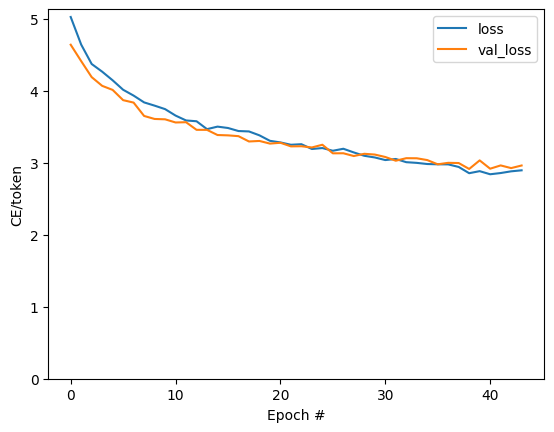

In [54]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

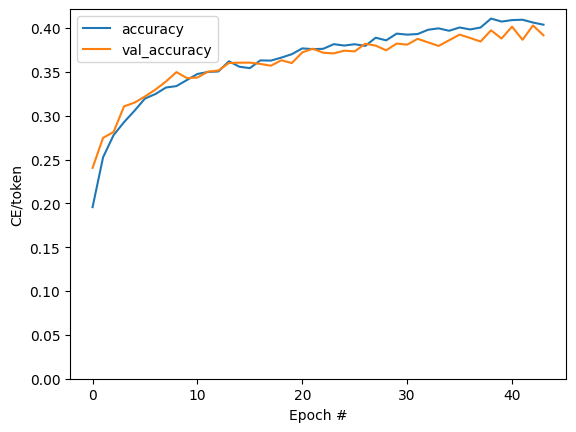

In [55]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## アテンションプロット

次に、トレーニング済みのモデルを使用して、画像に `simple_gen` メソッドを実行します。

In [56]:
result = model.simple_gen(image, temperature=0.0)
result

'a man in a red wetsuit is surfing'

出力をトークンに分割し直します。

In [57]:
str_tokens = result.split()
str_tokens.append('[END]')

`DecoderLayers` はそれぞれ、`CrossAttention` レイヤーのアテンションスコアをキャッシュします。各アテンションマップの形状は `(batch=1, heads, sequence, image)` です。

In [58]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 2, 9, 49]), TensorShape([1, 2, 9, 49])]

したがって、`batch` 軸に沿ってマップをスタックし、`(batch, heads)` 軸で平均しながら、`image` 軸を `height, width` に分割し直します。


In [59]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')

シーケンス予測ごとに、多につのアテンションマップを得られました。各マップの値の和は `1` になります。

In [60]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(9,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>

したがって、出力の各トークンを生成する際にモデルが注意を向けていた場所は以下です。

In [61]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)
    
    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

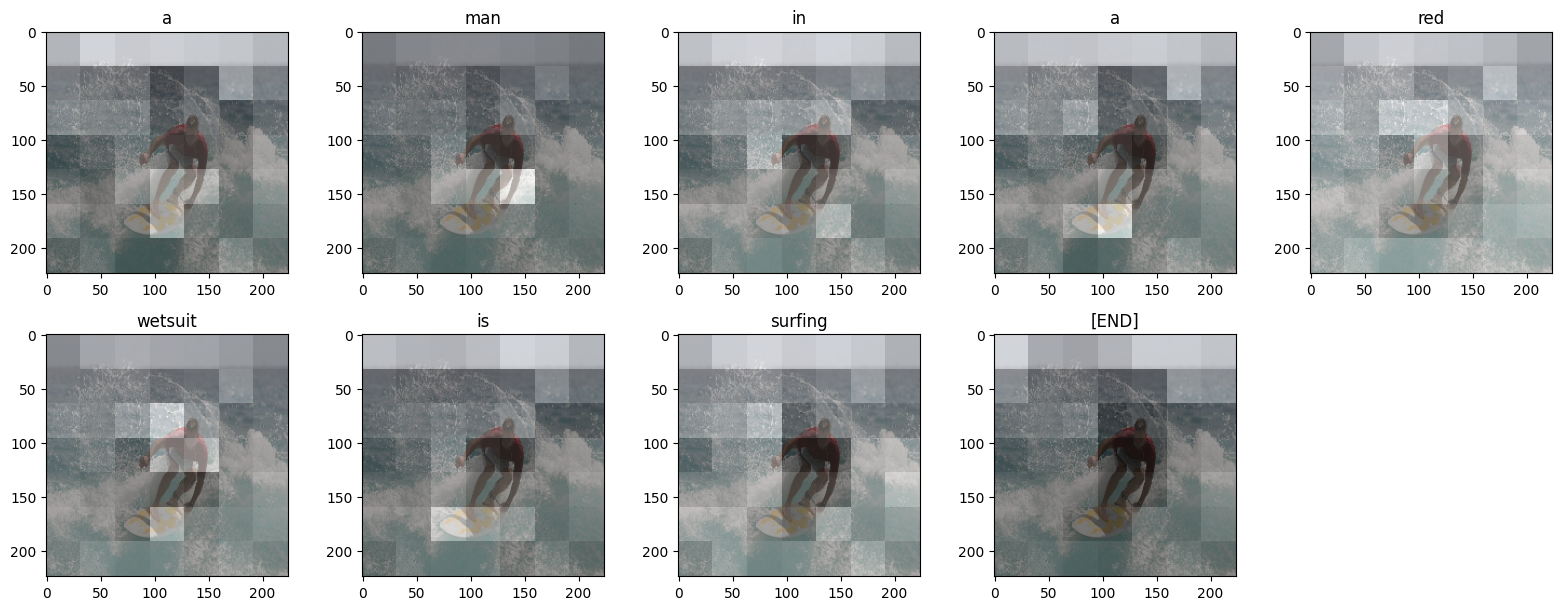

In [62]:
plot_attention_maps(image/255, str_tokens, attention_maps)

次に、これをより使いやすい関数にまとめます。

In [63]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')
  
  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)


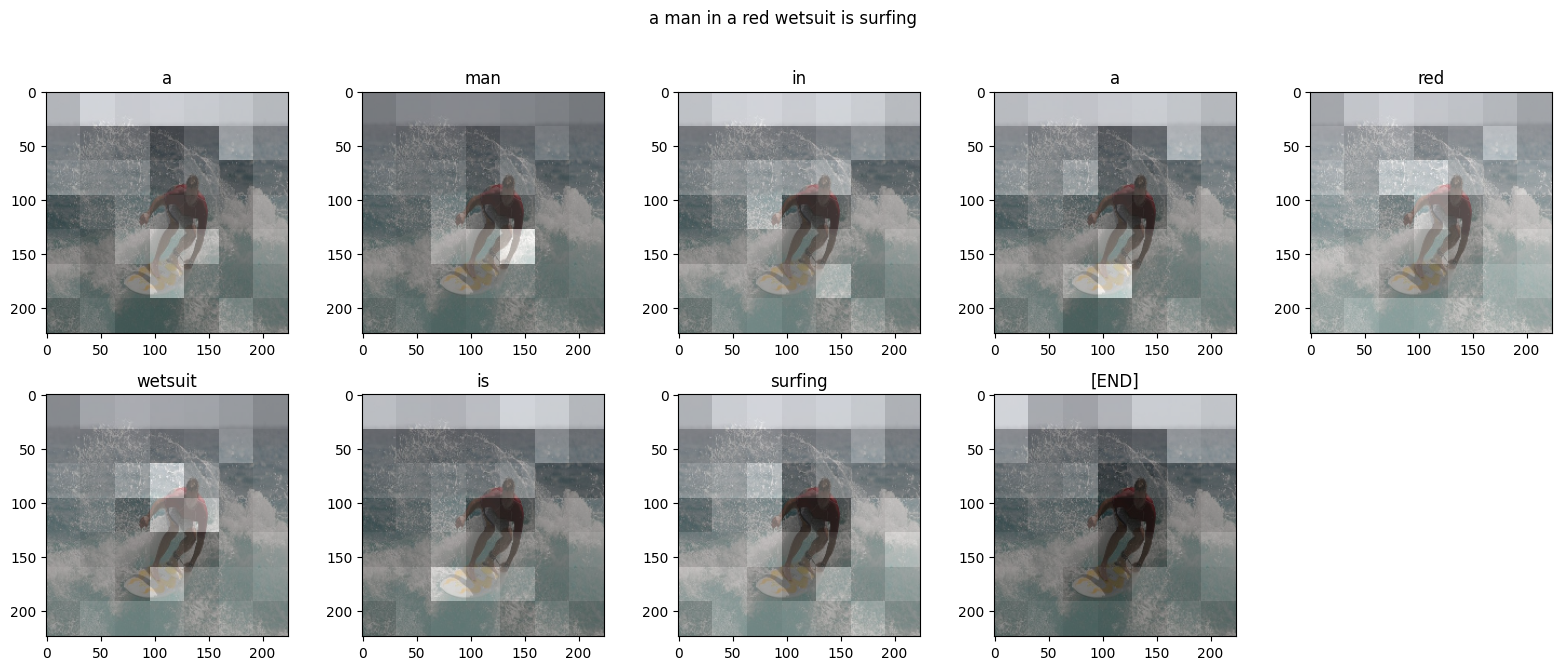

In [64]:
run_and_show_attention(model, image)

## あなた独自の画像でためそう

トレーニングしたばかりのモデルで独自の画像にキャプションを付ける方法を以下に示します。比較的少量のデータでトレーニングされているので、使用する画像がトレーニングデータと異なることがあることに注意してください（奇妙な結果がでるかもしれません！）


 8192/67460 [==>...........................] - ETA: 0s

67460/67460 [==============================] - 0s 0us/step


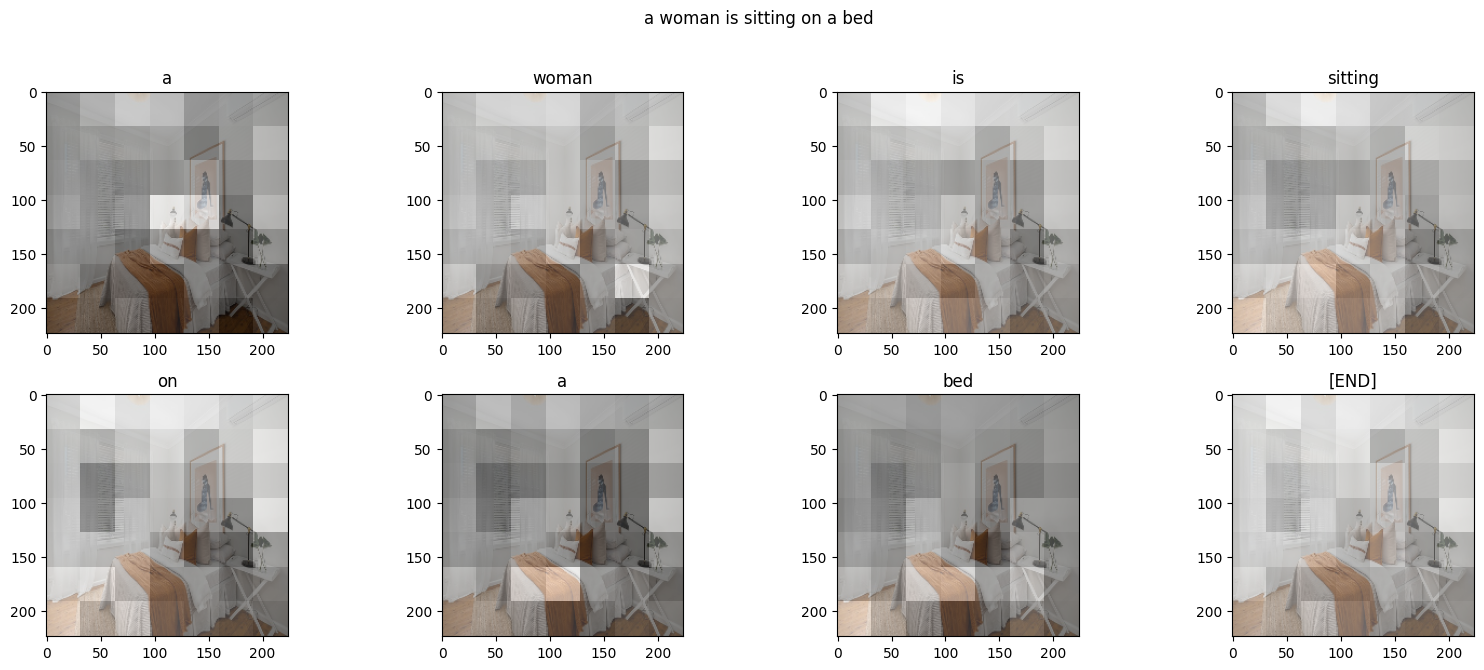

In [65]:
image_url = 'https://tensorflow.org/images/bedroom_hrnet_tutorial.jpg'
image_path = tf.keras.utils.get_file(origin=image_url)
image = load_image(image_path)

run_and_show_attention(model, image)